# Analysis 2/14/25

- Empirical p-value & FDR calculation based on null distribution of NT gRNAs
    - One or two sided test?
- Manual generation of LFC values based on RPM with psuedocount of 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [13]:
#loading in barcode counts

ABE_counts = pd.read_csv('mageck/ABE_bc_counts.txt', sep='\t')
CBE_counts = pd.read_csv('mageck/CBE_bc_counts.txt', sep='\t')


#and normalize to generate RPM values
samples_CBE = list(CBE_counts.columns[2:])

CBE_RPM = CBE_counts.copy()

#add pseudocount of 1 to each sample
#and normalize + calculate RPM
pseudocount = 1
for k in samples_CBE:
    col = np.asarray(CBE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    CBE_RPM[k] = rpm


#and do the same for ABE
ABE_RPM = ABE_counts.copy()
samples_ABE = list(ABE_counts.columns[2:])

pseudocount = 1
for k in samples_ABE:
    col = np.asarray(ABE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    ABE_RPM[k] = rpm

In [11]:
CBE_RPM[CBE_RPM['gene'].isin(['non_target', 'safe_target'])]

sgRNA         gene  spleen1  spleen2  spleen3  spleen4  spleen5  \
12225  gRNA_13286  safe_target    109.0    360.0   2502.0    679.0    553.0   
12226  gRNA_13287  safe_target    575.0   1641.0    433.0     98.0   1312.0   
12227  gRNA_13288  safe_target    666.0    557.0    338.0    956.0    287.0   
12228  gRNA_13289  safe_target   1852.0    357.0   4372.0    814.0   1632.0   
12229  gRNA_13290  safe_target    904.0    586.0    682.0    527.0   2036.0   
...           ...          ...      ...      ...      ...      ...      ...   
12656  gRNA_13727   non_target   2551.0    484.0   2301.0   3015.0   1354.0   
12657  gRNA_13728   non_target   2444.0   3319.0   1626.0   3885.0   2259.0   
12658  gRNA_13729   non_target    243.0     16.0    184.0    581.0     46.0   
12659  gRNA_13730   non_target   1988.0    771.0    325.0    375.0    533.0   
12660  gRNA_13731   non_target    218.0    150.0    622.0    326.0    625.0   

       spleen6  spleen7  spleen8  ...  input_rep1  input_rep2  input_rep3  \
12225    438.0    363.0    423.0  ...       860.0      1178.0       723.0   
12226    240.0    111.0    162.0  ...      1065.0       638.0       257.0   
12227    370.0    458.0   4946.0  ...       941.0      1031.0       904.0   
12228    696.0   2505.0    157.0  ...      1402.0      1698.0      1732.0   
12229   1114.0   1084.0    195.0  ...       255.0      1026.0       593.0   
...        ...      ...      ...  ...         ...         ...         ...   
12656   1306.0   5112.0   4653.0  ...      3532.0      2263.0      4724.0   
12657   2554.0   1304.0   2591.0  ...      1411.0      1774.0     12119.0   
12658      0.0    448.0    596.0  ...       400.0      2001.0      6009.0   
12659    528.0    127.0    155.0  ...      1794.0      1343.0      1929.0   
12660    707.0     52.0    390.0  ...       596.0       525.0      2427.0   

       d5_rep1  d5_rep2  d5_rep3  d15_rep1  d15_rep2  d15_rep3  plasmidlib  
12225    423.0    413.0    838.0     491.0    3468.0     679.0       769.0  
12226    362.0     91.0    859.0      40.0     260.0     148.0       396.0  
12227    264.0   4055.0   1194.0     644.0     503.0     313.0       622.0  
12228   1168.0   1286.0   1922.0    1671.0    3489.0    1729.0       849.0  
12229    214.0     73.0    809.0     189.0     322.0     251.0       460.0  
...        ...      ...      ...       ...       ...       ...         ...  
12656   2240.0   2987.0   2708.0    1460.0    1711.0     994.0      1118.0  
12657   2586.0    649.0   1199.0    3568.0    4353.0    3232.0      1443.0  
12658    293.0    278.0    612.0    1373.0    2645.0     370.0       687.0  
12659   1321.0   1970.0   1127.0    2203.0     129.0     533.0      1154.0  
12660    379.0    142.0    807.0     729.0     524.0     432.0       542.0  

[436 rows x 41 columns]

In [25]:
import numpy as np
from scipy.stats import combine_pvalues


def one_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target']):
    ''' 
    condition_of_interest = name of condition (e.g. "spleen")
    samp_of_interest = list of all replicates ["spleen1", "spleen2", "spleen3"]
    '''

    # null distribution from NT-gRNAs (e.g., log2 fold changes)


    #furthermore, add in the intron-targetting gRNAs to the distribution
    non_targ = LFC_df[LFC_df['gene'].isin(null)].reset_index(drop=True)
    #non_targ = LFC_df[LFC_df['gene'].isin(['NT'])].reset_index(drop=True)

    data = non_targ[samp_of_interest].to_numpy().flatten()
    nt_gRNA_values = data
    print(len(nt_gRNA_values))

    #targeting gRNAs with 3 replicates per guide
    #including NT gRNAs here for completeness even though they're in the null distribution
    gRNA_values = np.asarray(LFC_df[samp_of_interest])


    # Function to compute empirical p-values
    def empirical_p_value(observed, null_distribution):

        #S+1/N+1 for p-value calculation
        #Where is S=# of values more extreme than null (N)
        #S+1/N+1 for p-value calculation
        #Where is S=# of values more extreme than null (N)
        S = sum(null_distribution >= observed)
        N = len(null_distribution)
        p = (S+1)/(N+1)

        #return np.mean(null_distribution >= observed)
        return p

    # Compute p-values for each replicate separately
    p_values_per_replicate = np.array([
        [empirical_p_value(rep, nt_gRNA_values) for rep in gRNA] 
        for gRNA in gRNA_values
    ])

    # Combine p-values across replicates using Fisher's method
    combined_p_values = np.array([
        combine_pvalues(p_vals, method='fisher')[1]  # Extract p-value from Fisher's test
        for p_vals in p_values_per_replicate
    ])

    # Adjust for multiple testing (Benjamini-Hochberg FDR)
    from statsmodels.stats.multitest import multipletests
    adjusted_p_values = multipletests(combined_p_values, method='fdr_bh')[1]

    # Output results
    LFC_df[f'p_high_unadjusted_{condition_of_interest}'] = combined_p_values
    LFC_df[f'FDR_high_{condition_of_interest}'] = adjusted_p_values

    return LFC_df #, p_values_per_replicate

In [87]:
import numpy as np
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import multipletests

def two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target']):
    ''' 
    condition_of_interest = name of condition (e.g. "spleen")
    samp_of_interest = list of all replicates ["spleen1", "spleen2", "spleen3"]
    '''

    # Construct the null distribution
    non_targ = LFC_df[LFC_df['gene'].isin(null)].reset_index(drop=True)
    nt_gRNA_values = non_targ[samp_of_interest].to_numpy().flatten()

    # Targeting gRNAs (including NT for completeness)
    gRNA_values = np.asarray(LFC_df[samp_of_interest])

    # Function to compute empirical two-tailed p-values
    def empirical_p_value(observed, null_distribution):
        S_high = sum(null_distribution >= observed)
        S_low = sum(null_distribution <= observed)
        N = len(null_distribution)

        # Compute two-sided p-value
        p_high = (S_high + 1) / (N + 1)
        p_low = (S_low + 1) / (N + 1)
        return p_high, p_low

    # Compute p-values for each replicate separately (two-tailed)
    p_values_high = np.array([
        [empirical_p_value(rep, nt_gRNA_values)[0] for rep in gRNA] 
        for gRNA in gRNA_values
    ])
    p_values_low = np.array([
        [empirical_p_value(rep, nt_gRNA_values)[1] for rep in gRNA] 
        for gRNA in gRNA_values
    ])

    # Combine p-values across replicates using Fisher's method
    combined_p_values_high = np.array([
        combine_pvalues(p_vals, method='fisher')[1] for p_vals in p_values_high
    ])
    combined_p_values_low = np.array([
        combine_pvalues(p_vals, method='fisher')[1] for p_vals in p_values_low
    ])

    # Adjust for multiple testing (Benjamini-Hochberg FDR)
    adjusted_p_values_high = multipletests(combined_p_values_high, method='fdr_bh')[1]
    adjusted_p_values_low = multipletests(combined_p_values_low, method='fdr_bh')[1]

    # Store results in the dataframe
    LFC_df[f'p_high_unadjusted_{condition_of_interest}'] = combined_p_values_high
    LFC_df[f'p_low_unadjusted_{condition_of_interest}'] = combined_p_values_low
    LFC_df[f'FDR_high_{condition_of_interest}'] = adjusted_p_values_high
    LFC_df[f'FDR_low_{condition_of_interest}'] = adjusted_p_values_low

    return LFC_df


In [127]:
CBE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],
 'plasmid_lib':['plasmidlib']}

ABE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],
 'plasmid_lib':['plasmidlib']}

edit_info =pd.read_csv('master_table_unfiltered.csv')[['gRNA_id', 'gene_name_m', 'sensor_reads', 'corr_perc', 'target_base_edit_perc', 'byproduct_INDEL_perc', 'byproduct_sub_perc', 'Editor', 'classification', 'HGVSp_h', 'HGVSp_m']]
ABE_edit_info = edit_info[edit_info['Editor']=='ABE']
CBE_edit_info = edit_info[edit_info['Editor']=='CBE']

In [89]:
#can try with using d5 as t0 as well
t0_comparison = ['input_rep1', 'input_rep2', 'input_rep3']

dmso_median = np.median(ABE_RPM[t0_comparison], axis=1)
dmso_avg = np.average(ABE_RPM[t0_comparison], axis=1)


df_holder = []
for condition_of_interest in list(ABE_samp_dict.keys()):

#condition_of_interest = 'KI-CDK9d-32_1000nM'
    samp_of_interest = ABE_samp_dict[condition_of_interest]

    #calculate log2fc
    lfc_list = []
    for k in samp_of_interest:
        col = ABE_RPM[k]
        lfc = np.log2(col/dmso_median)

        lfc_list.append(lfc)

    lfc_table = pd.DataFrame(dict(zip(samp_of_interest, lfc_list)))
    lfc_table[f'LFC_avg_{condition_of_interest}'] = np.average(lfc_table[samp_of_interest], axis=1)
    lfc_table[f'LFC_median_{condition_of_interest}'] = np.median(lfc_table[samp_of_interest], axis=1)
    lfc_table['Input_median'] = dmso_median
    ids = ABE_RPM[['sgRNA', 'gene']]

    LFC_df = pd.concat((ids, lfc_table), axis=1)
    #LFC_df = one_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    LFC_df = two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    df_holder.append(LFC_df)

In [128]:
combined_LFC_ABE = pd.concat(df_holder, axis=1)
combined_LFC_ABE = combined_LFC_ABE.loc[:,~combined_LFC_ABE.columns.duplicated()].copy()
combined_LFC_ABE = combined_LFC_ABE.rename(columns = {'sgRNA':'gRNA_id', 'gene':'Gene'})
combined_LFC_ABE_edit = pd.merge(combined_LFC_ABE, ABE_edit_info, on='gRNA_id')

combined_LFC_ABE_edit.sort_values(by='FDR_low_spleen')[list(combined_LFC_ABE.columns[:13]) + ['target_base_edit_perc']][:10]

gRNA_id     Gene   spleen1   spleen2   spleen3   spleen4  \
1027  gRNA_13007      Vhl -5.522186 -7.954741 -6.852688 -1.850604   
226    gRNA_2494   Ctnnb1 -2.238856 -3.021354 -3.591726 -3.351482   
407    gRNA_4141    Fbxw7 -2.148976 -2.545553 -3.408396 -3.144226   
25      gRNA_671   Arid1a -3.481979 -1.666607 -2.543993 -4.467769   
221    gRNA_2458   Ctnnb1 -2.974894 -1.523964 -3.519522 -2.639341   
216    gRNA_2440     Ctcf -2.267264 -1.761775 -3.189127 -4.146675   
875   gRNA_11449  Smarca4 -1.295408 -2.047242 -3.355822 -3.909229   
512    gRNA_5776     Jak2 -2.262699 -2.639760 -3.311431 -1.606431   
188    gRNA_2215   Crebbp -2.288168 -3.280151 -1.033708 -1.650450   
190    gRNA_2240   Crebbp -2.129589 -2.253097 -0.902096 -4.842945   

      LFC_avg_spleen  LFC_median_spleen  Input_median  \
1027       -5.545055          -6.187437    235.136502   
226        -3.050854          -3.186418    784.914902   
407        -2.811788          -2.844889   1123.279978   
25         -3.040087          -3.012986    628.853436   
221        -2.664430          -2.807117    583.279661   
216        -2.841210          -2.728195   1391.679996   
875        -2.651925          -2.701532    853.968999   
512        -2.455080          -2.451230    626.119291   
188        -2.063119          -1.969309    524.811137   
190        -2.531932          -2.191343   1007.532571   

      p_high_unadjusted_spleen  p_low_unadjusted_spleen  FDR_high_spleen  \
1027                  0.999999                 0.000027              1.0   
226                   1.000000                 0.000020              1.0   
407                   0.999999                 0.000065              1.0   
25                    0.999997                 0.000084              1.0   
221                   0.999987                 0.000168              1.0   
216                   0.999992                 0.000149              1.0   
875                   0.999905                 0.000325              1.0   
512                   0.999981                 0.000416              1.0   
188                   0.999627                 0.001970              1.0   
190                   0.999489                 0.001930              1.0   

      FDR_low_spleen  target_base_edit_perc  
1027        0.014197              99.504950  
226         0.014197              36.756757  
407         0.022515              92.645215  
25          0.022515              90.340136  
221         0.029951              51.130435  
216         0.029951              73.255055  
875         0.049706              57.357860  
512         0.055608              39.332461  
188         0.203900              83.058104  
190         0.203900              95.858241

In [102]:
#can try with using d5 as t0 as well
t0_comparison = ['input_rep1', 'input_rep2', 'input_rep3']

dmso_median = np.median(CBE_RPM[t0_comparison], axis=1)
dmso_avg = np.average(CBE_RPM[t0_comparison], axis=1)


df_holder2 = []
for condition_of_interest in list(CBE_samp_dict.keys()):

#condition_of_interest = 'KI-CDK9d-32_1000nM'
    samp_of_interest = CBE_samp_dict[condition_of_interest]

    #calculate log2fc
    lfc_list = []
    for k in samp_of_interest:
        col = CBE_RPM[k]
        lfc = np.log2(col/dmso_median)

        lfc_list.append(lfc)

    lfc_table = pd.DataFrame(dict(zip(samp_of_interest, lfc_list)))
    lfc_table[f'LFC_avg_{condition_of_interest}'] = np.average(lfc_table[samp_of_interest], axis=1)
    lfc_table[f'LFC_median_{condition_of_interest}'] = np.median(lfc_table[samp_of_interest], axis=1)
    lfc_table['Input_median'] = dmso_median
    ids = CBE_RPM[['sgRNA', 'gene']]

    LFC_df = pd.concat((ids, lfc_table), axis=1)
    #LFC_df = one_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    LFC_df = two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    df_holder2.append(LFC_df)

In [129]:
combined_LFC = pd.concat(df_holder2, axis=1)
combined_LFC = combined_LFC.loc[:,~combined_LFC.columns.duplicated()].copy()
combined_LFC = combined_LFC.rename(columns = {'sgRNA':'gRNA_id', 'gene':'Gene'})
combined_LFC_CBE_edit = pd.merge(combined_LFC, CBE_edit_info, on='gRNA_id')



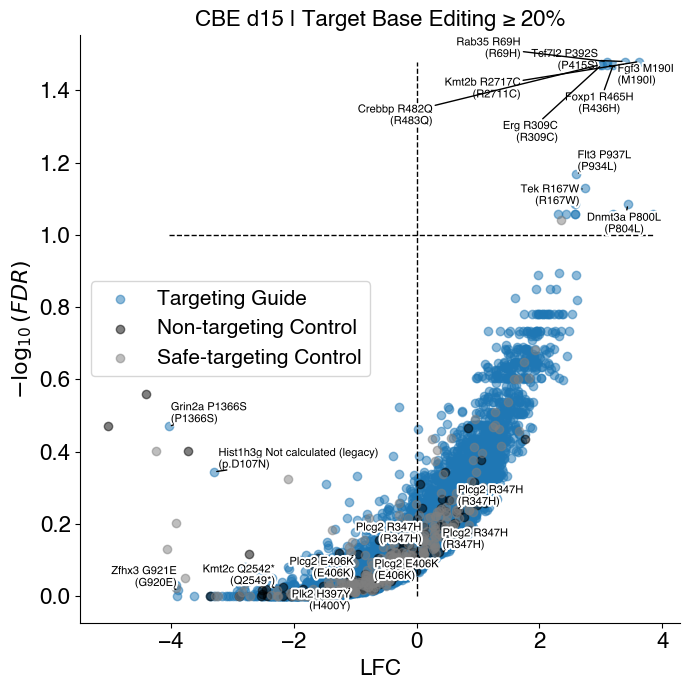

In [224]:
condition_of_interest = 'd15'
edit_cutoff = 20

samp_of_interest = CBE_samp_dict[condition_of_interest]
other_cols = ['Input_median', f'LFC_avg_{condition_of_interest}',f'LFC_median_{condition_of_interest}', 
              f'p_high_unadjusted_{condition_of_interest}',f'p_low_unadjusted_{condition_of_interest}',
              f'FDR_high_{condition_of_interest}',f'FDR_low_{condition_of_interest}',
              'gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'target_base_edit_perc', 'sensor_reads', 'classification']

subset_CBE = combined_LFC_CBE_edit[samp_of_interest + other_cols]

min_FDR = []
for i, val in subset_CBE.iterrows():
    FDR_low = -np.log10(val[f'FDR_low_{condition_of_interest}'])
    FDR_high = -np.log10(val[f'FDR_high_{condition_of_interest}'])
    min_FDR.append(max(FDR_low, FDR_high))

subset_CBE['-log10(FDR)'] = min_FDR

subset_targ = subset_CBE[subset_CBE['classification']=='targeting guide']
subset_NT = subset_CBE[subset_CBE['classification']=='non-targeting control']
subset_ST = subset_CBE[subset_CBE['classification']=='safe-targeting control']

#and then filter based on editing info
subset_targ = subset_targ[subset_targ['target_base_edit_perc']>=edit_cutoff]

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(data=subset_targ, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:blue', alpha=.5, label='Targeting Guide')
ax.scatter(data=subset_NT, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='black', alpha=.5, label='Non-targeting Control')
ax.scatter(data=subset_ST, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:grey', alpha=.5, label='Safe-targeting Control')

ax.legend(fontsize=15)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_ylabel("$-\log_{10}({FDR})$", fontsize=16)
ax.set_xlabel('LFC', fontsize=16)
ax.set_title(f'CBE {condition_of_interest} | Target Base Editing ≥ {edit_cutoff}%', fontsize=16)

bounds = [min(subset_targ[f'LFC_median_{condition_of_interest}']), max(subset_targ[f'LFC_median_{condition_of_interest}'])]
ax.plot(bounds,[1,1], linestyle='dashed', color='black', linewidth=1)
ax.plot([0,0],[0,max(subset_targ['-log10(FDR)'])], linestyle='dashed', color='black', linewidth=1)

#and then add labels to top and bottom enrichers
num_to_plot = 10
top_enrichers = subset_targ.sort_values(by=f'FDR_high_{condition_of_interest}')[:num_to_plot]
top_depleters = subset_targ.sort_values(by=f'FDR_low_{condition_of_interest}')[:num_to_plot]

tops = pd.concat((top_enrichers, top_depleters)).fillna(' ')

#first top enrichers
x = list(tops[f'LFC_median_{condition_of_interest}'])
y = list(tops['-log10(FDR)'])
t = [f"{val['Gene']} {val['HGVSp_m']}\n({val['HGVSp_h'].replace('delins','')})" for i, val in tops.iterrows()]

texts = [ax.text(x[i], y[i], t[i], fontsize=8, color='black', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                            foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

adjust_text(texts,only_move={'points':'xy', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()
#fig.savefig(f'figures/{condition_of_interest}_CBE_volcano.png', dpi=300)

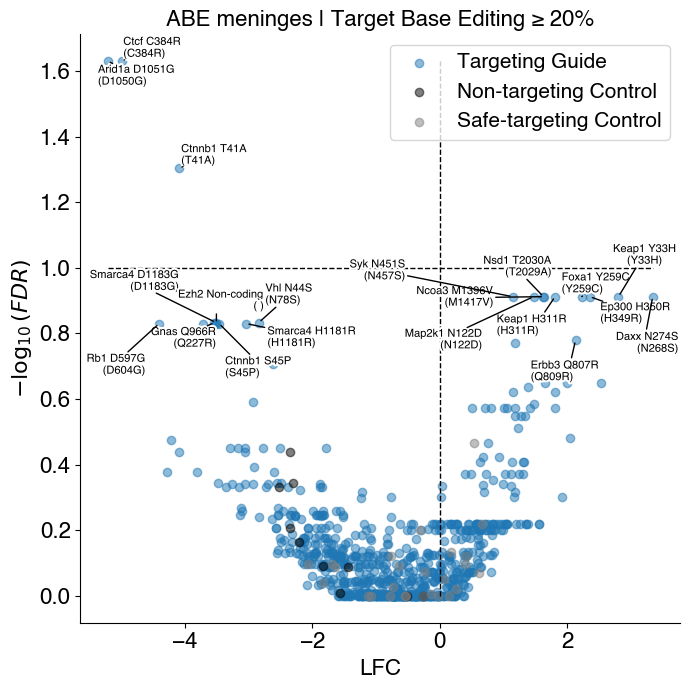

In [ ]:
condition_of_interest = 'meninges'
edit_cutoff = 20


samp_of_interest = ABE_samp_dict[condition_of_interest]
other_cols = ['Input_median', f'LFC_avg_{condition_of_interest}',f'LFC_median_{condition_of_interest}', 
              f'p_high_unadjusted_{condition_of_interest}',f'p_low_unadjusted_{condition_of_interest}',
              f'FDR_high_{condition_of_interest}',f'FDR_low_{condition_of_interest}',
              'gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'target_base_edit_perc', 'sensor_reads', 'classification']

subset_ABE = combined_LFC_ABE_edit[samp_of_interest + other_cols]

min_FDR = []
for i, val in subset_ABE.iterrows():
    FDR_low = -np.log10(val[f'FDR_low_{condition_of_interest}'])
    FDR_high = -np.log10(val[f'FDR_high_{condition_of_interest}'])
    min_FDR.append(max(FDR_low, FDR_high))

subset_ABE['-log10(FDR)'] = min_FDR

subset_targ = subset_ABE[subset_ABE['classification']=='targeting guide']
subset_NT = subset_ABE[subset_ABE['classification']=='non-targeting control']
subset_ST = subset_ABE[subset_ABE['classification']=='safe-targeting control']

#and then filter based on editing info
subset_targ = subset_targ[subset_targ['target_base_edit_perc']>=edit_cutoff]

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(data=subset_targ, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:blue', alpha=.5, label='Targeting Guide')
ax.scatter(data=subset_NT, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='black', alpha=.5, label='Non-targeting Control')
ax.scatter(data=subset_ST, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:grey', alpha=.5, label='Safe-targeting Control')

ax.legend(fontsize=15)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_ylabel("$-\log_{10}({FDR})$", fontsize=16)
ax.set_xlabel('LFC', fontsize=16)
ax.set_title(f'ABE {condition_of_interest} | Target Base Editing ≥ {edit_cutoff}%', fontsize=16)

bounds = [min(subset_targ[f'LFC_median_{condition_of_interest}']), max(subset_targ[f'LFC_median_{condition_of_interest}'])]
ax.plot(bounds,[1,1], linestyle='dashed', color='black', linewidth=1)
ax.plot([0,0],[0,max(subset_targ['-log10(FDR)'])], linestyle='dashed', color='black', linewidth=1)

#and then add labels to top and bottom enrichers
num_to_plot = 10
top_enrichers = subset_targ.sort_values(by=f'FDR_high_{condition_of_interest}')[:num_to_plot]
top_depleters = subset_targ.sort_values(by=f'FDR_low_{condition_of_interest}')[:num_to_plot]

tops = pd.concat((top_enrichers, top_depleters)).fillna(' ')

#first top enrichers
x = list(tops[f'LFC_median_{condition_of_interest}'])
y = list(tops['-log10(FDR)'])
t = [f"{val['Gene']} {val['HGVSp_m']}\n({val['HGVSp_h'].replace('delins','')})" for i, val in tops.iterrows()]

texts = [ax.text(x[i], y[i], t[i], fontsize=8, color='black', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                            foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

adjust_text(texts,only_move={'points':'xy', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()
#fig.savefig(f'figures/{condition_of_interest}_ABE_volcano.png', dpi=300)

# Possible updates

Possibly add in cutoff based on #input sequencing reads (on raw reads)

# Pairwise comparisons

In [ ]:
#combined_LFC_ABE_edit.to_csv('ABE_LFC_FDR_df.csv', index=False)
#combined_LFC_CBE_edit.to_csv('CBE_LFC_FDR_df.csv', index=False)

In [2]:
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')

In [3]:
CBE_samp_dict2 = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}

ABE_samp_dict2 = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}


In [9]:
KO[KO['classification'] == 'non-targeting control']

d5_rep1   d5_rep2   d5_rep3         classification
12538 -1.190888 -1.907469  1.697949  non-targeting control
12539 -1.292464 -2.692621 -0.851171  non-targeting control
12540 -2.635230 -1.961367 -0.408511  non-targeting control
12541 -0.829908 -1.407883  0.028490  non-targeting control
12542 -1.715199 -0.231604 -0.682738  non-targeting control
...         ...       ...       ...                    ...
12656 -0.519091  0.211997 -0.208725  non-targeting control
12657  0.501346 -1.175372 -0.570151  non-targeting control
12658 -2.809669 -2.569170 -1.712850  non-targeting control
12659 -0.065926  0.826330 -0.258133  non-targeting control
12660 -0.810634 -1.904568  0.314470  non-targeting control

[123 rows x 4 columns]

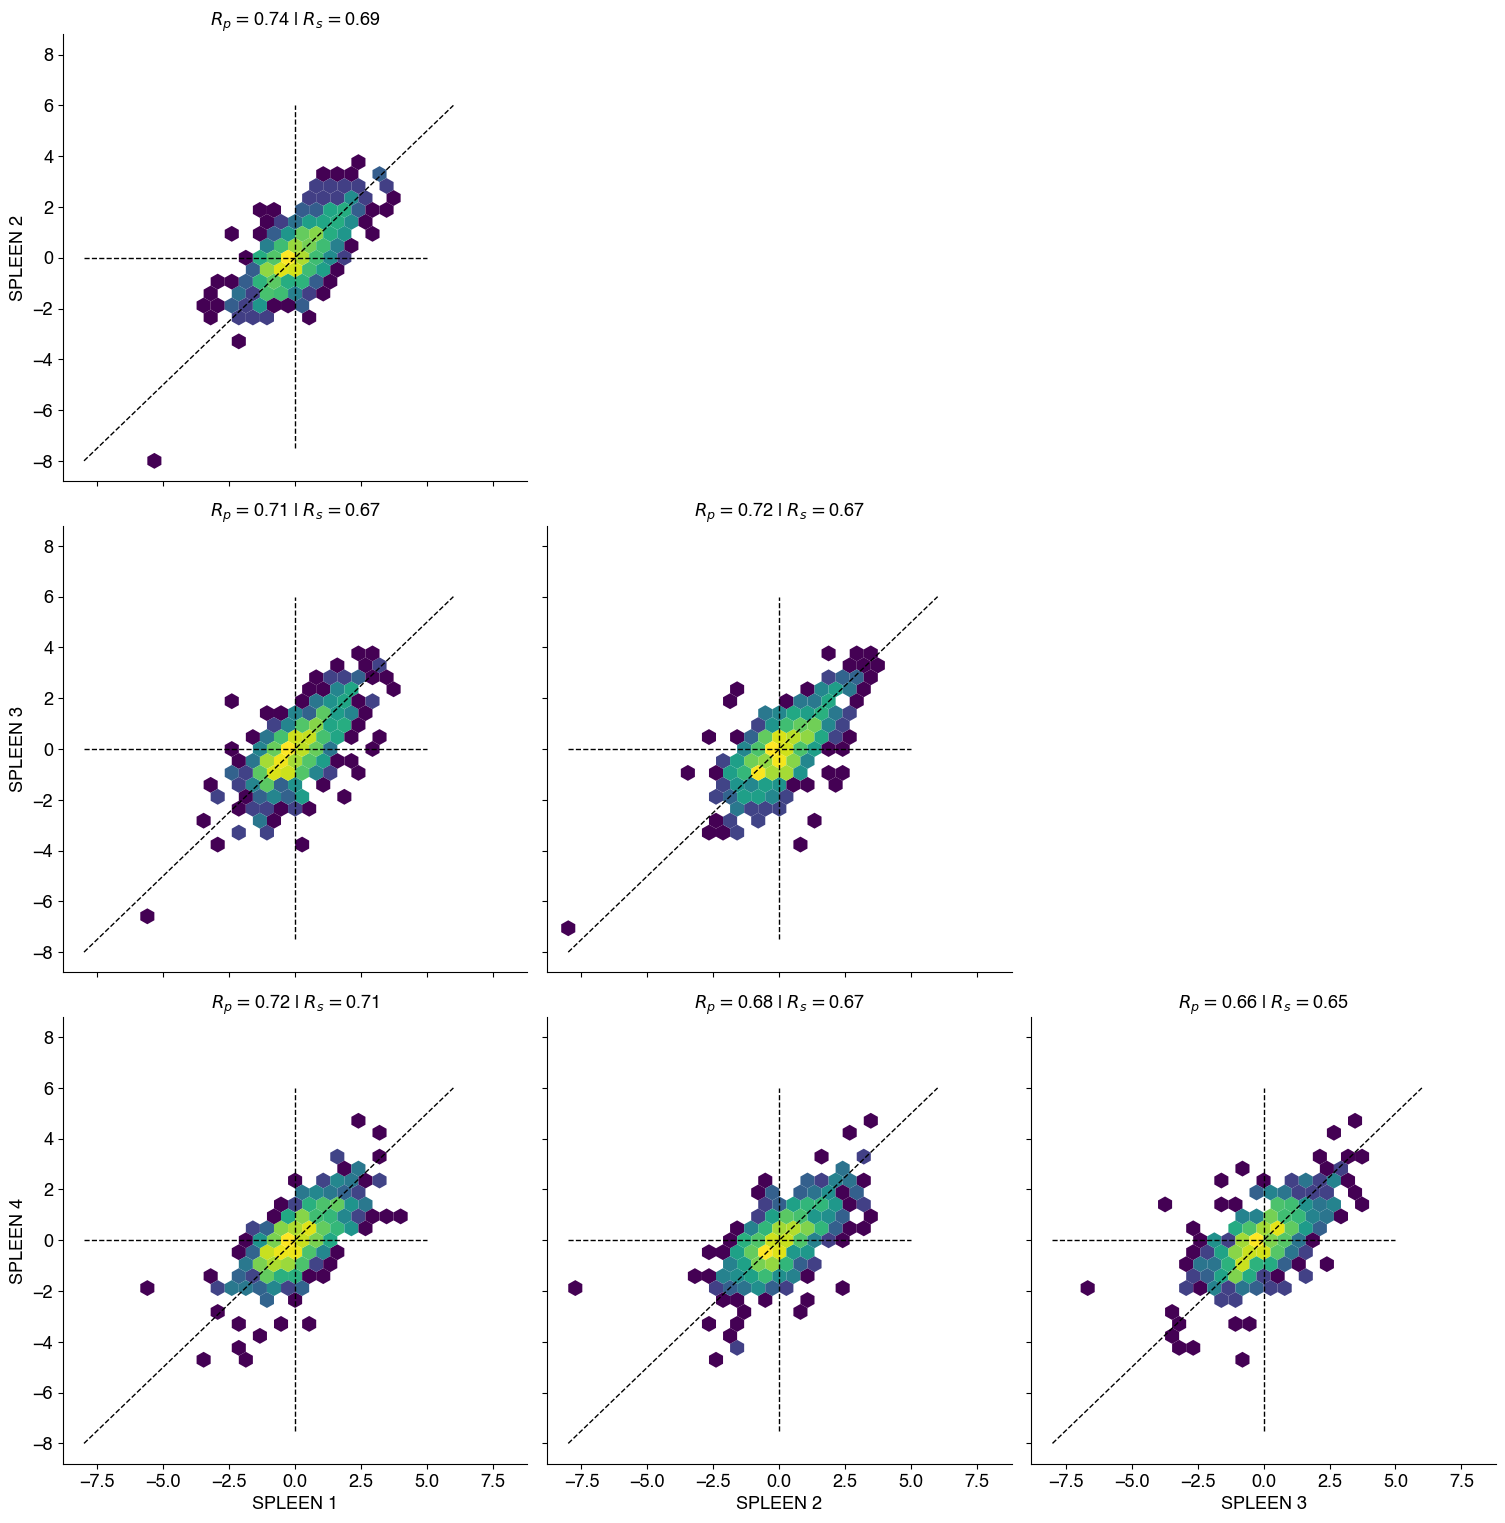

In [53]:
COI = 'spleen'
min_edit = 50
samples = list(ABE_samp_dict2[COI])

s2 = samples +  ['classification', 'target_base_edit_perc']
KO = ABE_LFC[s2]

KO = KO[KO['target_base_edit_perc']>= min_edit]

fig, ax = plt.subplots(len(samples),len(samples),figsize=(20,20), sharex=True, sharey=True)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']


s_dict = {'LFC_d15': 'LFC In Vitro', 'LFC_spleen': 'LFC Spleen', 'LFC_bone': 'LFC Bone', 'LFC_meninges': 'LFC Meninges'}
for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        ax[row][col].hexbin(KO[samp2], KO[samp], bins='log', gridsize=30, linewidth=0, extent = (-8, 8, -8, 8))

        ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)


        if samp[-2:]=='10':
            j1 = f'{samp[:-2].upper()} {samp[-2:]}'
        elif '_' in samp:
            j1 = samp.split('_')[0].upper() + ' ' + samp.split('_')[1].upper()
        else:
            j1 = f'{samp[:-1].upper()} {samp[-1:]}'

        if samp2[-2:]=='10':
            j2 = f'{samp2[:-2].upper()} {samp2[-2:]}'
        elif '_' in samp2:
            j2 = samp2.split('_')[0].upper() + ' ' + samp2.split('_')[1].upper()
        else:
            j2 = f'{samp2[:-1].upper()} {samp2[-1:]}'


        ax[row][0].set_ylabel(j1, fontsize=13)
        ax[len(samples)-1][col].set_xlabel(j2, fontsize=13)
    #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

        ax[row][col].spines[['top', 'right']].set_visible(False)

        ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

        spear = np.round(scipy.stats.spearmanr(KO[samp2], KO[samp]).statistic, 2)
        pear = np.round(scipy.stats.pearsonr(KO[samp2], KO[samp]).statistic, 2)

        ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}', fontsize=13)


        if row<=col:
            fig.delaxes(ax[row][col])

fig.tight_layout()
#fig.savefig(f'figures/{COI}_pairwise_comp_CBE.pdf')

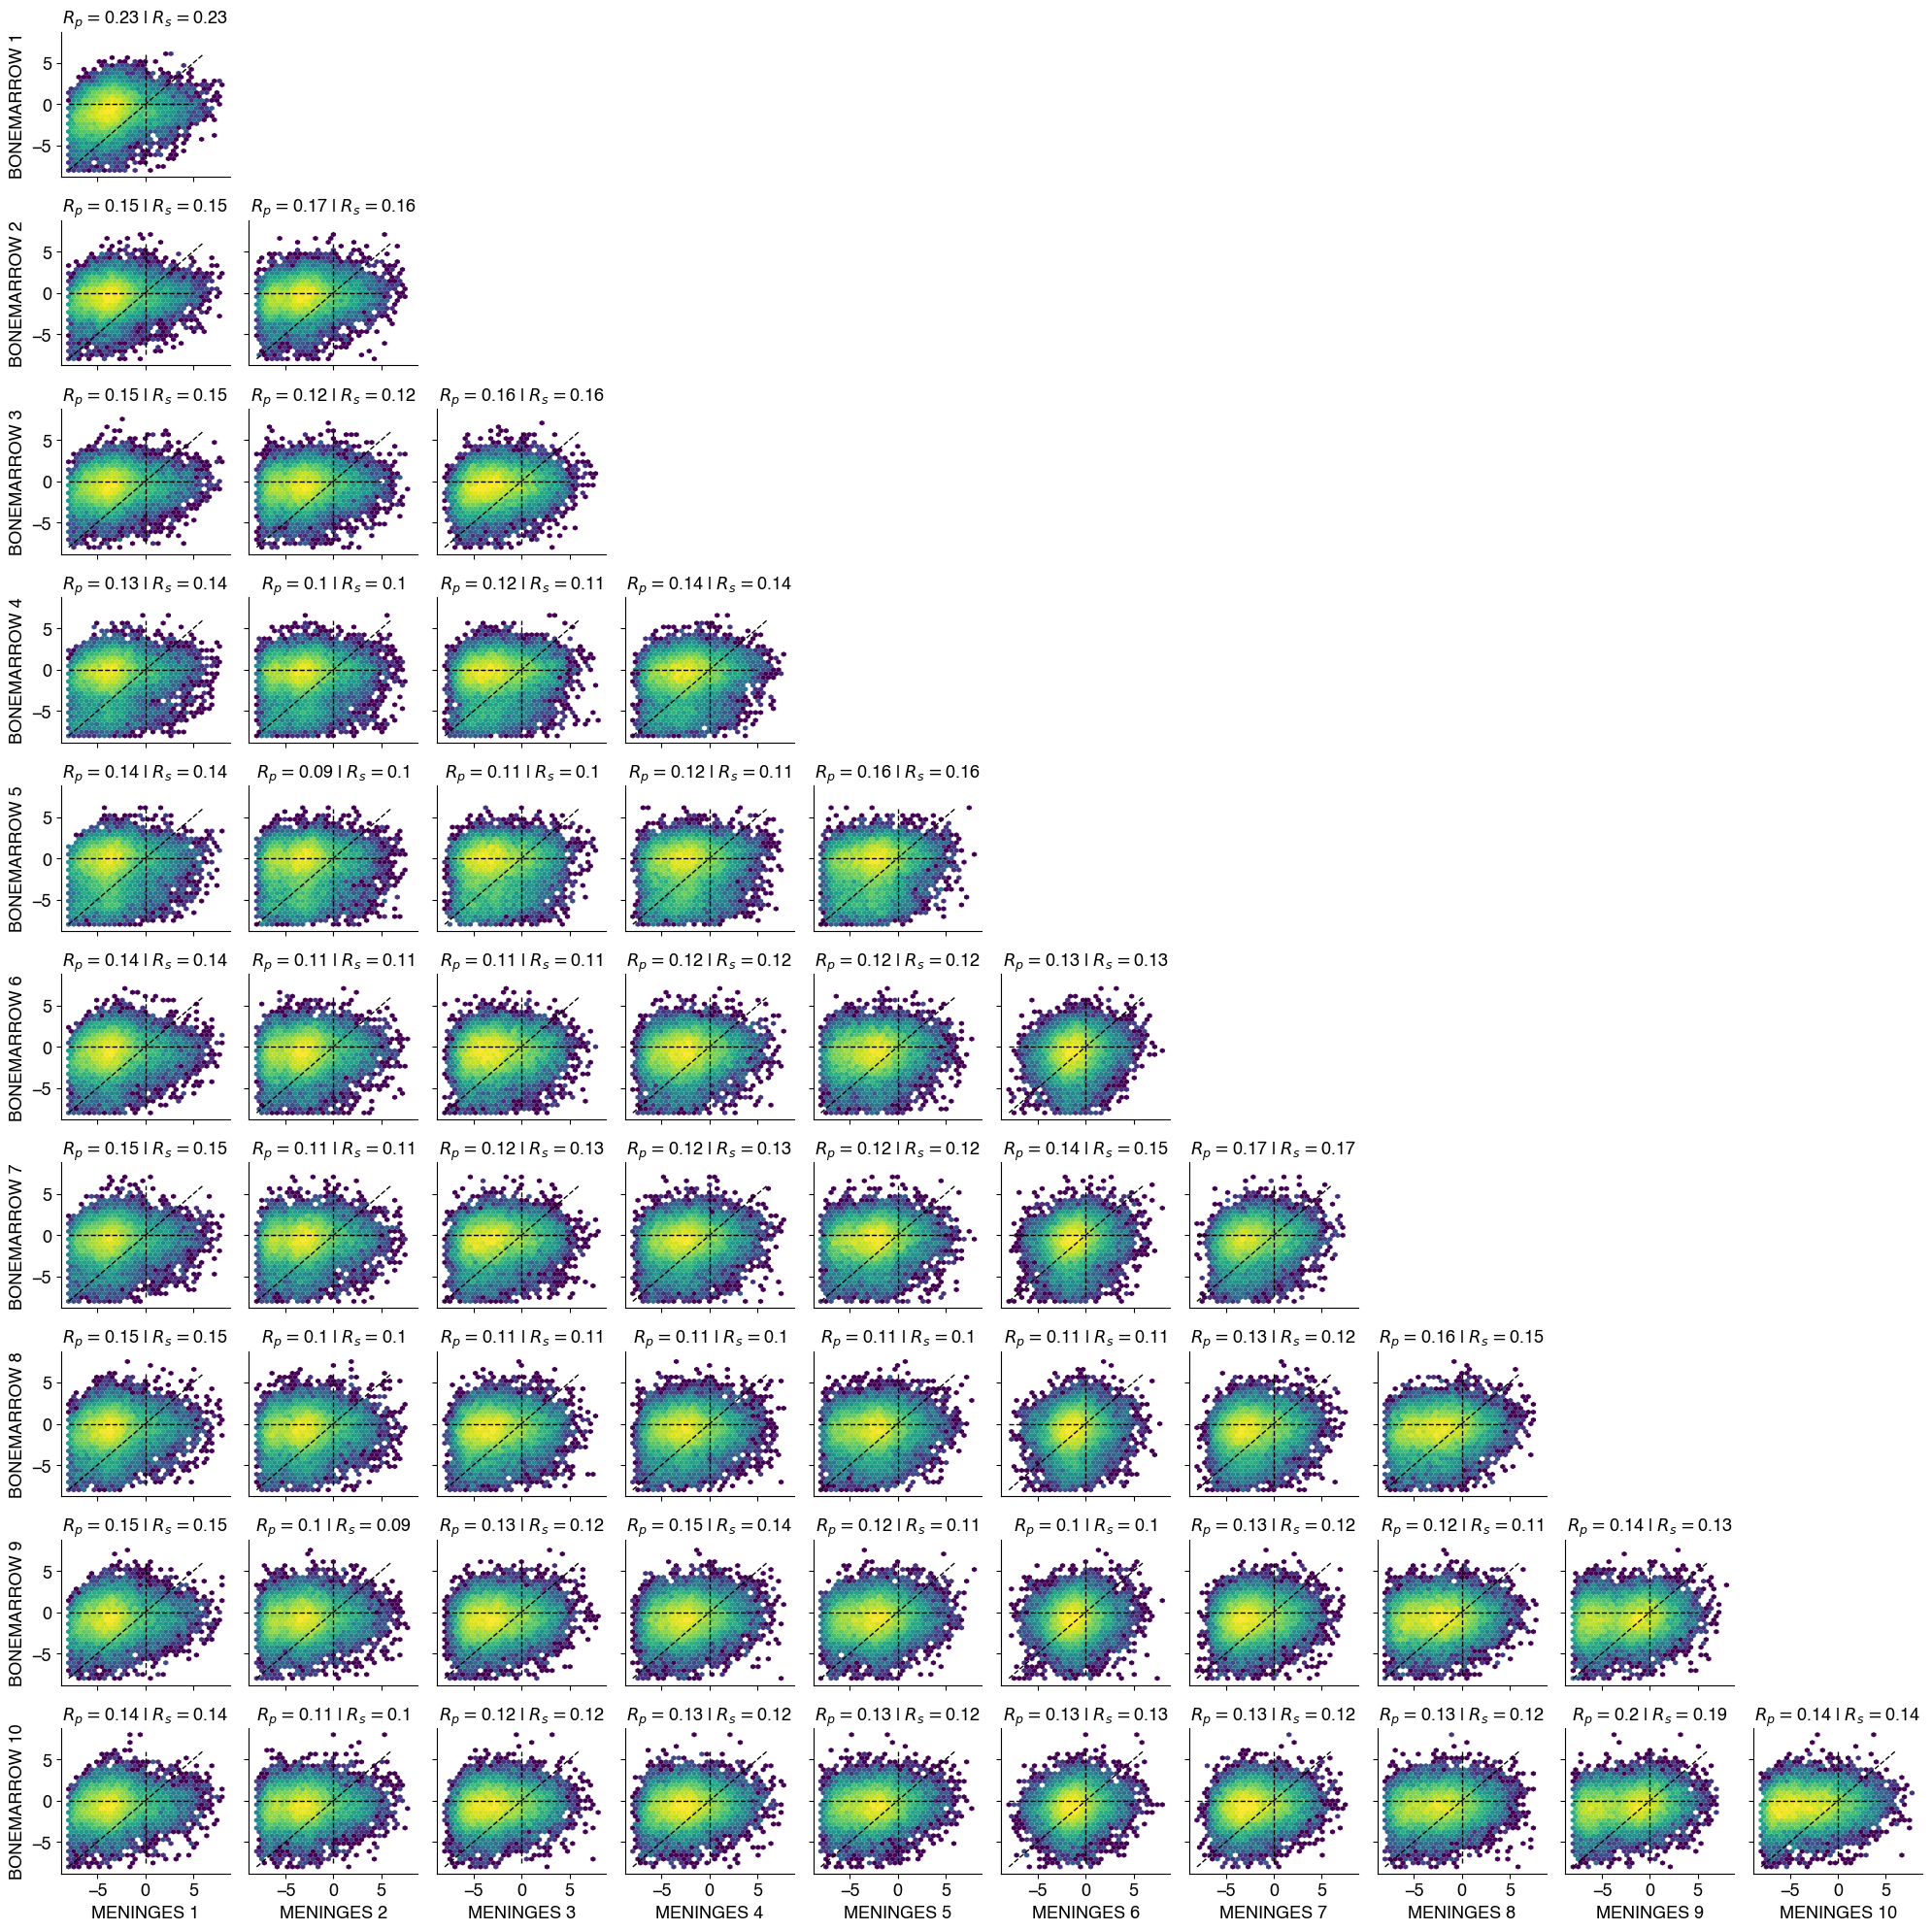

In [300]:
#and then pairwise comparisons among different samples

COI_1 = 'bonemarrow'
COI_2 = 'meninges'
samples1 = list(CBE_samp_dict2[COI_1])
samples2 = list(CBE_samp_dict2[COI_2])
KO = CBE_LFC[samples1 + samples2]

fig, ax = plt.subplots(len(samples1),len(samples2),figsize=(20,20), sharex=True, sharey=True)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']


s_dict = {'LFC_d15': 'LFC In Vitro', 'LFC_spleen': 'LFC Spleen', 'LFC_bone': 'LFC Bone', 'LFC_meninges': 'LFC Meninges'}
for idx, samp in enumerate(samples1):

    row = idx
    for idx2, samp2 in enumerate(samples2):
        col = idx2
        ax[row][col].hexbin(KO[samp2], KO[samp], bins='log', gridsize=30, linewidth=0, extent = (-8, 8, -8, 8))

        ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)


        if samp[-2:]=='10':
            j1 = f'{samp[:-2].upper()} {samp[-2:]}'
        elif '_' in samp:
            j1 = samp.split('_')[0].upper() + ' ' + samp.split('_')[1].upper()
        else:
            j1 = f'{samp[:-1].upper()} {samp[-1:]}'

        if samp2[-2:]=='10':
            j2 = f'{samp2[:-2].upper()} {samp2[-2:]}'
        elif '_' in samp2:
            j2 = samp2.split('_')[0].upper() + ' ' + samp2.split('_')[1].upper()
        else:
            j2 = f'{samp2[:-1].upper()} {samp2[-1:]}'


        ax[row][0].set_ylabel(j1, fontsize=13)
        ax[len(samples1)-1][col].set_xlabel(j2, fontsize=13)
    #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

        ax[row][col].spines[['top', 'right']].set_visible(False)

        ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

        spear = np.round(scipy.stats.spearmanr(KO[samp2], KO[samp]).statistic, 2)
        pear = np.round(scipy.stats.pearsonr(KO[samp2], KO[samp]).statistic, 2)

        ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}', fontsize=13)


        if row<col:
            fig.delaxes(ax[row][col])

fig.tight_layout()
#fig.savefig(f'figures/{COI_1}_{COI_2}_pairwise_comp_CBE.pdf')

# Pairwise comparisons with read counts

Note that pairwise correlations between raw read counts are equivalent to comparisons between RPM values because the transformation is linear. 

In [30]:
ABE_counts = pd.read_csv('mageck/ABE_bc_counts.txt', sep='\t')
CBE_counts = pd.read_csv('mageck/CBE_bc_counts.txt', sep='\t')

#and normalize to generate RPM values
samples_CBE = list(CBE_counts.columns[2:])

CBE_RPM = CBE_counts.copy()

#add pseudocount of 1 to each sample
#and normalize + calculate RPM
pseudocount = 1
for k in samples_CBE:
    col = np.asarray(CBE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    CBE_RPM[k] = rpm


#and do the same for ABE
ABE_RPM = ABE_counts.copy()
samples_ABE = list(ABE_counts.columns[2:])

pseudocount = 1
for k in samples_ABE:
    col = np.asarray(ABE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    ABE_RPM[k] = rpm

In [31]:
ABE_counts

sgRNA        gene  spleen1  spleen2  spleen3  spleen4  bonemarrow1  \
0         gRNA_1        Abl1     62.0    180.0    160.0    233.0        339.0   
1         gRNA_2        Abl1     65.0    247.0    274.0     20.0        258.0   
2         gRNA_3        Abl1     75.0    158.0     83.0     88.0        244.0   
3        gRNA_67        Ago2     89.0     91.0     72.0     26.0         79.0   
4        gRNA_84        Akt1    237.0    588.0    389.0    388.0        660.0   
...          ...         ...      ...      ...      ...      ...          ...   
1065  gRNA_13604  non_target   1311.0   2168.0    798.0   1324.0        731.0   
1066  gRNA_13605  non_target    248.0    953.0    197.0    222.0        201.0   
1067  gRNA_13606  non_target    293.0    618.0    173.0    247.0       2123.0   
1068  gRNA_13607  non_target     55.0    531.0    330.0    320.0        524.0   
1069  gRNA_13608  non_target     88.0    550.0     68.0    138.0        190.0   

      bonemarrow2  bonemarrow3  bonemarrow4  ...  input_rep1  input_rep2  \
0           178.0        500.0        114.0  ...        24.0       365.0   
1           199.0        334.0         22.0  ...         2.0       262.0   
2           339.0        113.0         57.0  ...         2.0       216.0   
3            77.0         84.0         41.0  ...        31.0       197.0   
4           729.0        431.0        154.0  ...       265.0       505.0   
...           ...          ...          ...  ...         ...         ...   
1065       1798.0        867.0        725.0  ...       588.0       754.0   
1066        373.0        510.0         74.0  ...       296.0       467.0   
1067       1662.0        968.0        304.0  ...      1289.0       952.0   
1068        265.0        454.0        977.0  ...       258.0       504.0   
1069       2119.0       1008.0         29.0  ...        99.0       313.0   

      input_rep3  d5_rep1  d5_rep2  d5_rep3  d15_rep1  d15_rep2  d15_rep3  \
0          404.0    321.0    388.0    525.0     521.0     253.0     178.0   
1           56.0    142.0    128.0    121.0     180.0      23.0      18.0   
2          145.0    206.0     46.0    259.0     315.0     198.0      98.0   
3           56.0     72.0     91.0     88.0      31.0      41.0      68.0   
4          331.0    503.0   1028.0    426.0     589.0     458.0     880.0   
...          ...      ...      ...      ...       ...       ...       ...   
1065       975.0    402.0    450.0    734.0     737.0     602.0     648.0   
1066       663.0    400.0    697.0    500.0     408.0     338.0     527.0   
1067      1399.0    896.0    934.0    859.0    1070.0    1102.0    1386.0   
1068       739.0    749.0    646.0    481.0     824.0     444.0     765.0   
1069       208.0    196.0    133.0    150.0     256.0     111.0     210.0   

      plasmidlib  
0          212.0  
1          121.0  
2          145.0  
3          456.0  
4          796.0  
...          ...  
1065       769.0  
1066       501.0  
1067      1195.0  
1068       551.0  
1069       162.0  

[1070 rows x 26 columns]

PearsonRResult(statistic=0.6832938398351603, pvalue=4.7039707772062e-148)

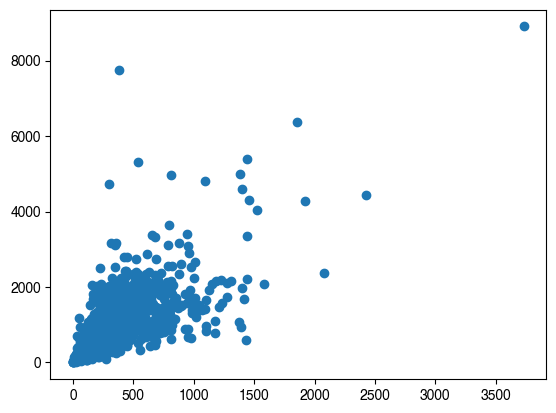

In [475]:
x,y = ABE_counts['spleen1'], ABE_counts['spleen2']\

plt.scatter(x,y)
scipy.stats.pearsonr(x,y)

PearsonRResult(statistic=0.6832938398351606, pvalue=4.703970777204595e-148)

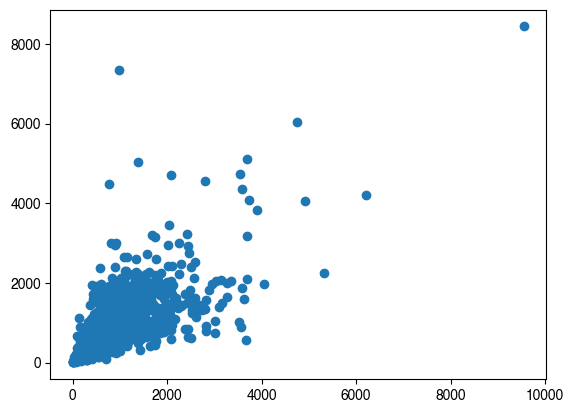

In [477]:
x,y = ABE_RPM['spleen1'], ABE_RPM['spleen2']

plt.scatter(x,y)
scipy.stats.pearsonr(x,y)

PearsonRResult(statistic=0.8780332892311589, pvalue=0.0)

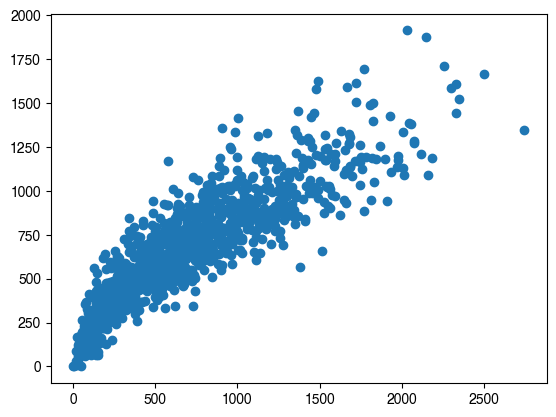

In [45]:
x,y = ABE_counts['input_rep3'], ABE_counts['input_rep2']

plt.scatter(x,y)
scipy.stats.pearsonr(x,y)

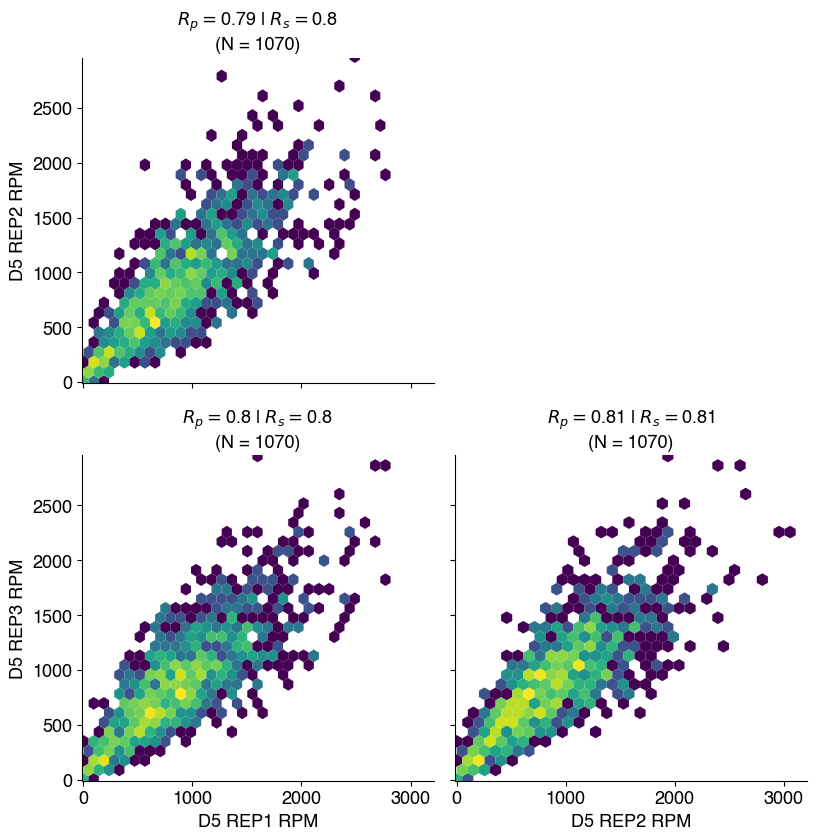

In [41]:
COI = 'd5'
min_rpm_cutoff = 0
samples = list(ABE_samp_dict2[COI])
KO = ABE_RPM[samples]

fig, ax = plt.subplots(len(samples),len(samples),figsize=(12,12), sharex=True, sharey=True)

for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):

        if samp != samp2:
            col = idx2

            #apply the minimum counts cutoff here
            df_threshold = KO[[samp, samp2]]
            df_threshold = df_threshold[(df_threshold[samp]>=min_rpm_cutoff) & (df_threshold[samp2]>=min_rpm_cutoff)]
            

            ax[row][col].hexbin(df_threshold[samp2], df_threshold[samp], bins='log', gridsize=30, linewidth=0) #, extent = (-8, 8, -8, 8))

            #ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
            #ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
            #ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)

            if samp[-2:]=='10':
                j1 = f'{samp[:-2].upper()} {samp[-2:]}'
            elif '_' in samp:
                j1 = samp.split('_')[0].upper() + ' ' + samp.split('_')[1].upper()
            else:
                j1 = f'{samp[:-1].upper()} {samp[-1:]}'

            if samp2[-2:]=='10':
                j2 = f'{samp2[:-2].upper()} {samp2[-2:]}'
            elif '_' in samp2:
                j2 = samp2.split('_')[0].upper() + ' ' + samp2.split('_')[1].upper()
            else:
                j2 = f'{samp2[:-1].upper()} {samp2[-1:]}'


            ax[row][0].set_ylabel(j1 + ' RPM', fontsize=13)
            ax[len(samples)-1][col].set_xlabel(j2 + ' RPM', fontsize=13)
        #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
        #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
        #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

            ax[row][col].spines[['top', 'right']].set_visible(False)

            ax[row][col].set_ylim(-10,)
            ax[row][col].set_xlim(-10,)

            ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

            spear = np.round(scipy.stats.spearmanr(df_threshold[samp2], df_threshold[samp]).statistic, 2)
            pear = np.round(scipy.stats.pearsonr(df_threshold[samp2], df_threshold[samp]).statistic, 2)

            ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}\n(N = {len(df_threshold)})', fontsize=13)

        #else:
        #    print(f'{row}_{col}-else')
        #    fig.delaxes(ax[row][col])
        #    print(f'success')

            if row<=col:
                #print(f'{row}_{col}-if')
                fig.delaxes(ax[row][col])
                #print(f'success')

for idx, samp in enumerate(samples):
    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        if row==col:
            fig.delaxes(ax[row][col])

fig.tight_layout()

#fig.savefig(f'figures/{COI}_min_RPM_{min_rpm_cutoff}_ABE.pdf')

In [578]:
KO

d5_rep1     d5_rep2     d5_rep3
0      134.972572   82.919012   55.983879
1       81.668187   38.780772   77.604893
2      330.682801   57.958076  133.087125
3      281.877502  464.577814  217.062943
4       22.299816    7.488281   10.835589
...           ...         ...         ...
13237  122.013249   41.885668   57.187833
13238   21.810785   22.464843   49.010977
13239   45.186470   31.779533   66.869633
13240   58.292502   63.193785  137.852777
13241   95.263250   68.733895   95.463550

[13242 rows x 3 columns]

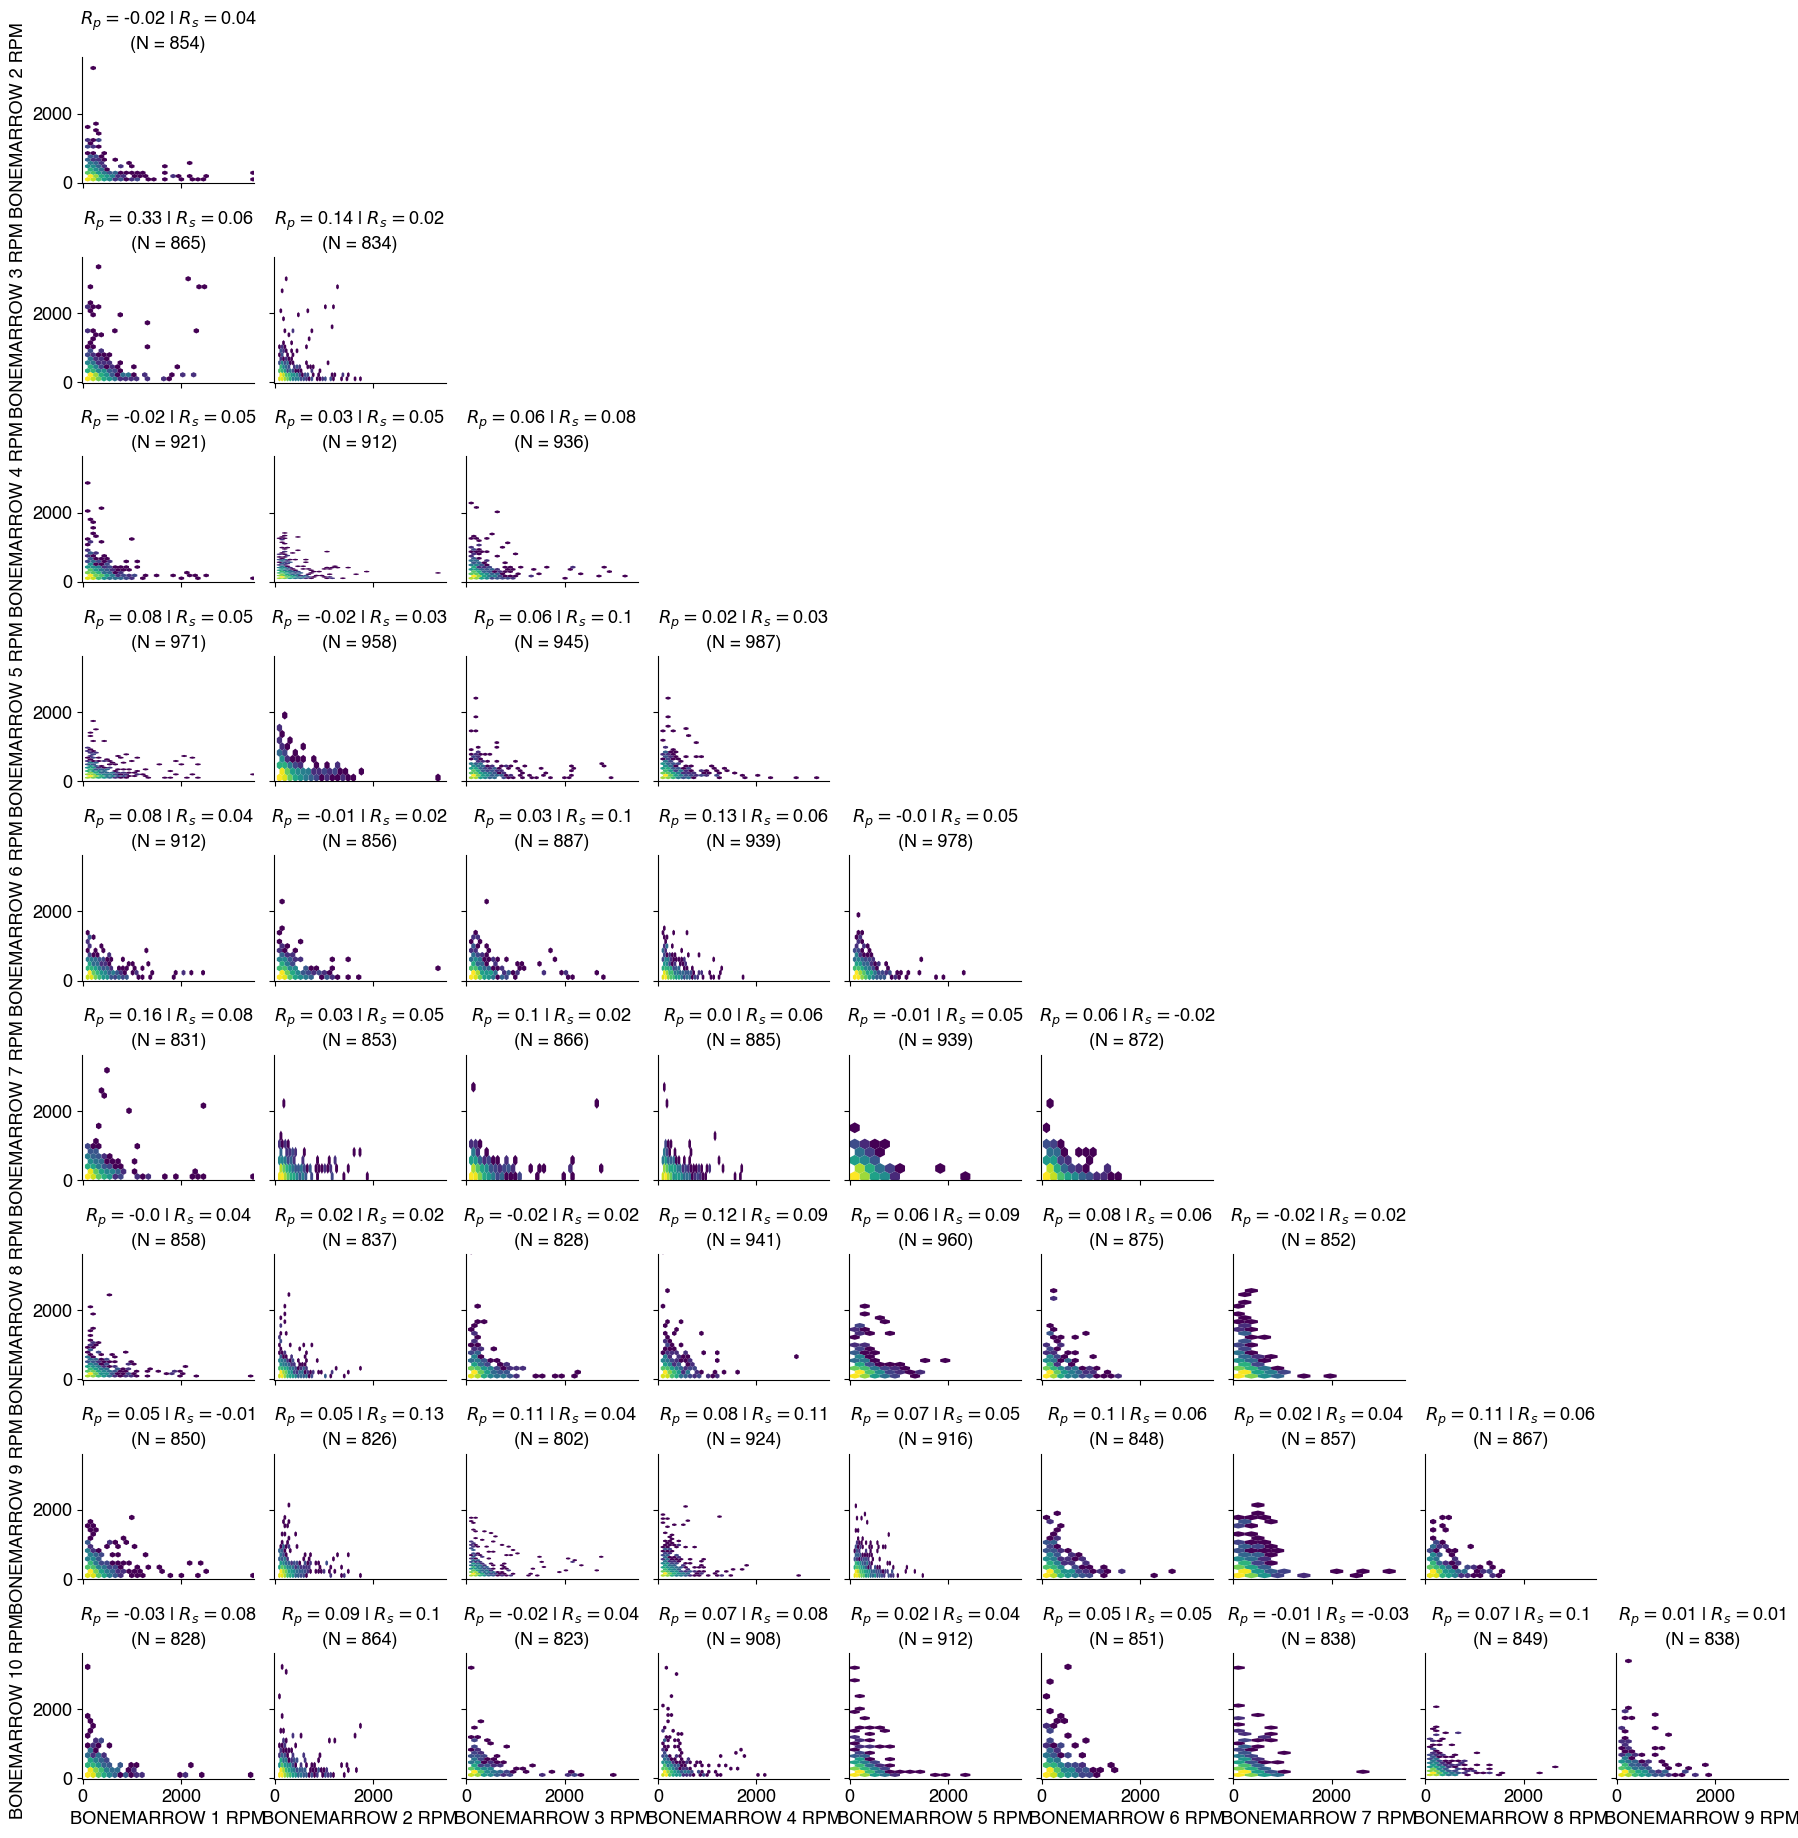

In [ ]:
COI = 'bonemarrow'
min_rpm_cutoff = 100
samples = list(CBE_samp_dict2[COI])
KO = CBE_RPM[samples]

fig, ax = plt.subplots(len(samples),len(samples),figsize=(20,20), sharex=True, sharey=True)

for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):

        if samp != samp2:
            col = idx2

            #apply the minimum counts cutoff here
            df_threshold = KO[[samp, samp2]]
            df_threshold = df_threshold[(df_threshold[samp]>=min_rpm_cutoff) & (df_threshold[samp2]>=min_rpm_cutoff)]
            

            ax[row][col].hexbin(df_threshold[samp2], df_threshold[samp], bins='log', gridsize=30, linewidth=0) #, extent = (-8, 8, -8, 8))
            #ax[row][col].scatter(df_threshold[samp2], df_threshold[samp], alpha=.2) #, bins='log', gridsize=30, linewidth=0)

            #ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
            #ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
            #ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)

            if samp[-2:]=='10':
                j1 = f'{samp[:-2].upper()} {samp[-2:]}'
            elif '_' in samp:
                j1 = samp.split('_')[0].upper() + ' ' + samp.split('_')[1].upper()
            else:
                j1 = f'{samp[:-1].upper()} {samp[-1:]}'

            if samp2[-2:]=='10':
                j2 = f'{samp2[:-2].upper()} {samp2[-2:]}'
            elif '_' in samp2:
                j2 = samp2.split('_')[0].upper() + ' ' + samp2.split('_')[1].upper()
            else:
                j2 = f'{samp2[:-1].upper()} {samp2[-1:]}'


            ax[row][0].set_ylabel(j1 + ' RPM', fontsize=13)
            ax[len(samples)-1][col].set_xlabel(j2 + ' RPM', fontsize=13)
        #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
        #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
        #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

            ax[row][col].spines[['top', 'right']].set_visible(False)

            ax[row][col].set_ylim(-10,)
            ax[row][col].set_xlim(-10,)

            ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

            spear = np.round(scipy.stats.spearmanr(df_threshold[samp2], df_threshold[samp]).statistic, 2)
            pear = np.round(scipy.stats.pearsonr(df_threshold[samp2], df_threshold[samp]).statistic, 2)

            ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}\n(N = {len(df_threshold)})', fontsize=13)

        #else:
        #    print(f'{row}_{col}-else')
        #    fig.delaxes(ax[row][col])
        #    print(f'success')

            if row<=col:
                #print(f'{row}_{col}-if')
                fig.delaxes(ax[row][col])
                #print(f'success')

for idx, samp in enumerate(samples):
    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        if row==col:
            fig.delaxes(ax[row][col])

fig.tight_layout()

#fig.savefig(f'figures/{COI}_min_RPM_{min_rpm_cutoff}_CBE.pdf')

# Validation gRNA selection

In [62]:
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')

In [195]:
FDR_cutoff = 0.1
#meninges_specific = CBE_LFC[(CBE_LFC['FDR_high_meninges']<=FDR_cutoff) & (CBE_LFC['FDR_high_spleen']<=FDR_cutoff) & (CBE_LFC['FDR_high_bonemarrow']<=FDR_cutoff) & (CBE_LFC['FDR_high_d15']>FDR_cutoff)]

COI = 'FDR_low_spleen'
min_edit = 20
type_hit = 'general' #'general'ABE_LFC

#general hits
if type_hit=='general':
    meninges_specific = CBE_LFC[(CBE_LFC[COI]<=FDR_cutoff) & (CBE_LFC['target_base_edit_perc']>=min_edit)]

#tissue specific hits
elif type_hit=='tissue_specific':
    s1 = ['FDR_high_bonemarrow', 'FDR_high_spleen', 'FDR_high_meninges', 'FDR_high_d15']
    s1.remove(COI)
    assert len(s1)==3
    meninges_specific = CBE_LFC[(CBE_LFC[COI]<=FDR_cutoff) & (CBE_LFC[s1[0]]>FDR_cutoff) & (CBE_LFC[s1[1]]>FDR_cutoff) & (CBE_LFC[s1[2]]>FDR_cutoff) & (CBE_LFC['target_base_edit_perc']>=min_edit)]



meninges_specific = meninges_specific[~meninges_specific['Gene'].isin(['safe_target', 'non_target'])]
meninges_specific = meninges_specific.sort_values(by=COI,ascending=True)[:15]

CBE_samp_dict3 = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}


meninges_specific['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in meninges_specific.iterrows()]

#get meninges
l1 = list(CBE_samp_dict3['meninges'])
melted_1 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l1, 
                     var_name='tissue', value_name='LFC')
melted_1['tissue'] = "Meninges"

#spleen
l2 = list(CBE_samp_dict3['spleen'])
melted_2 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc', 'sensor_reads','Input_median', 'Name'], value_vars=l2, 
                     var_name='tissue', value_name='LFC')
melted_2['tissue'] = 'Spleen'

#bm
l3 = list(CBE_samp_dict3['bonemarrow'])
melted_3 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l3, 
                     var_name='tissue', value_name='LFC')
melted_3['tissue'] = 'Bone Marrow'

#in vitro
l4 = list(CBE_samp_dict3['d15'])
melted_4 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc', 'sensor_reads','Input_median', 'Name'], value_vars=l4, 
                     var_name='tissue', value_name='LFC')
melted_4['tissue'] = 'In Vitro D15'


plotting_df = pd.concat((melted_1, melted_2, melted_3, melted_4))
t = plotting_df.drop_duplicates(subset='gRNA_id')[['target_base_edit_perc', 'corr_perc', 'sensor_reads', 'Name']]


In [198]:
meninges_specific #[meninges_specific['Gene']=='Ptprt']

gRNA_id      Gene   spleen1   spleen2   spleen3   spleen4   spleen5  \
12908  gRNA_14079     Ikzf1 -0.817666 -2.436358 -3.129097 -8.740571 -8.290631   
10612  gRNA_11491   Smarca4 -2.448312 -6.226481 -8.175561 -2.190844 -2.773326   
948      gRNA_996       Atm -4.217838 -3.089750 -8.766750 -0.310509 -5.431629   
9202    gRNA_9963     Ptprs -3.240145 -2.855084 -3.038629  0.222678 -4.861361   
10579  gRNA_11458   Smarca4 -7.459539 -7.811444  0.727317 -5.208766 -6.817720   
10219  gRNA_11051     Sesn2 -5.961085 -0.046204 -6.262070 -7.032241 -5.734304   
8394    gRNA_9136      Pim1 -8.478231 -2.980470 -2.980474 -0.718607 -3.302434   
11554  gRNA_12489      Top1 -5.825108 -6.177012 -6.126092 -4.311301 -6.183289   
581      gRNA_607    Arid1a -9.480992 -3.064712 -3.949086 -1.675630 -2.012625   
8501    gRNA_9243     Plcg2 -7.885259 -4.429809 -0.475437 -2.847890 -2.161292   
12891  gRNA_14062  Hist1h3g -4.337101 -2.258372 -2.879331 -5.073838 -3.134922   
2416    gRNA_2653      Dis3 -8.995033 -8.346937  1.054922 -2.100404 -1.148643   
11935  gRNA_12953      Upf1 -4.439887  0.205264 -2.997647 -3.677053 -3.607385   
11130  gRNA_12042    Stat5a -8.638284 -0.408988 -0.455452 -3.461512 -3.867182   
12752  gRNA_13923    Cdkn2a -2.952235 -2.362243 -2.033541 -8.271318 -1.790160   

        spleen6   spleen7   spleen8  ...  sensor_reads  corr_perc  \
12908 -2.451830 -6.858721 -9.048024  ...           702   6.410256   
10612 -7.904919  0.386694 -5.083260  ...           433  54.734411   
948   -4.174180 -4.448621 -2.850021  ...           299   0.000000   
9202  -3.396018 -7.129891 -2.918314  ...             8  12.500000   
10579 -2.734994  1.166415 -4.931257  ...             4  50.000000   
10219 -6.991428 -2.311672 -2.847841  ...           512   0.000000   
8394  -3.864717 -4.010425 -3.534912  ...          3172  16.582598   
11554  1.284101 -5.129891  1.790637  ...             4  25.000000   
581   -3.926372 -3.903132 -2.007852  ...            10  60.000000   
8501  -4.215162 -4.235846 -2.950985  ...             6   0.000000   
12891 -2.401827 -1.678947 -4.846955  ...           964   9.336100   
2416   0.255396 -4.840384 -3.265117  ...           228  67.982456   
11935 -8.408829 -2.229314 -0.582170  ...           104   0.000000   
11130 -7.668626 -0.653048 -3.184003  ...            33   0.000000   
12752 -6.645542 -3.005100 -1.828902  ...            12   8.333333   

       target_base_edit_perc  byproduct_INDEL_perc  byproduct_sub_perc  \
12908              81.623932              0.142450           78.347578   
10612              98.845266              0.461894           44.803695   
948                83.612040              0.334448           90.635452   
9202               50.000000              0.000000           50.000000   
10579             100.000000              0.000000           50.000000   
10219              91.796875              0.000000           99.414062   
8394               27.805801              0.346784           59.363178   
11554             100.000000              0.000000           75.000000   
581               100.000000              0.000000           40.000000   
8501              100.000000              0.000000          100.000000   
12891              86.618257              0.414938           87.863071   
2416               99.122807              0.877193           30.701754   
11935              35.576923              0.000000          100.000000   
11130              57.575758              0.000000          100.000000   
12752             100.000000              0.000000           91.666667   

       Editor   classification       HGVSp_h                  HGVSp_m  \
12908     CBE  targeting guide       p.R208*  Not calculated (legacy)   
10612     CBE  targeting guide         A945T                    A945T   
948       CBE  targeting guide        E2444K                   E2454K   
9202      CBE  targeting guide         A429V                    A416V   
10579     CBE  targeting guide  R1415delins*              

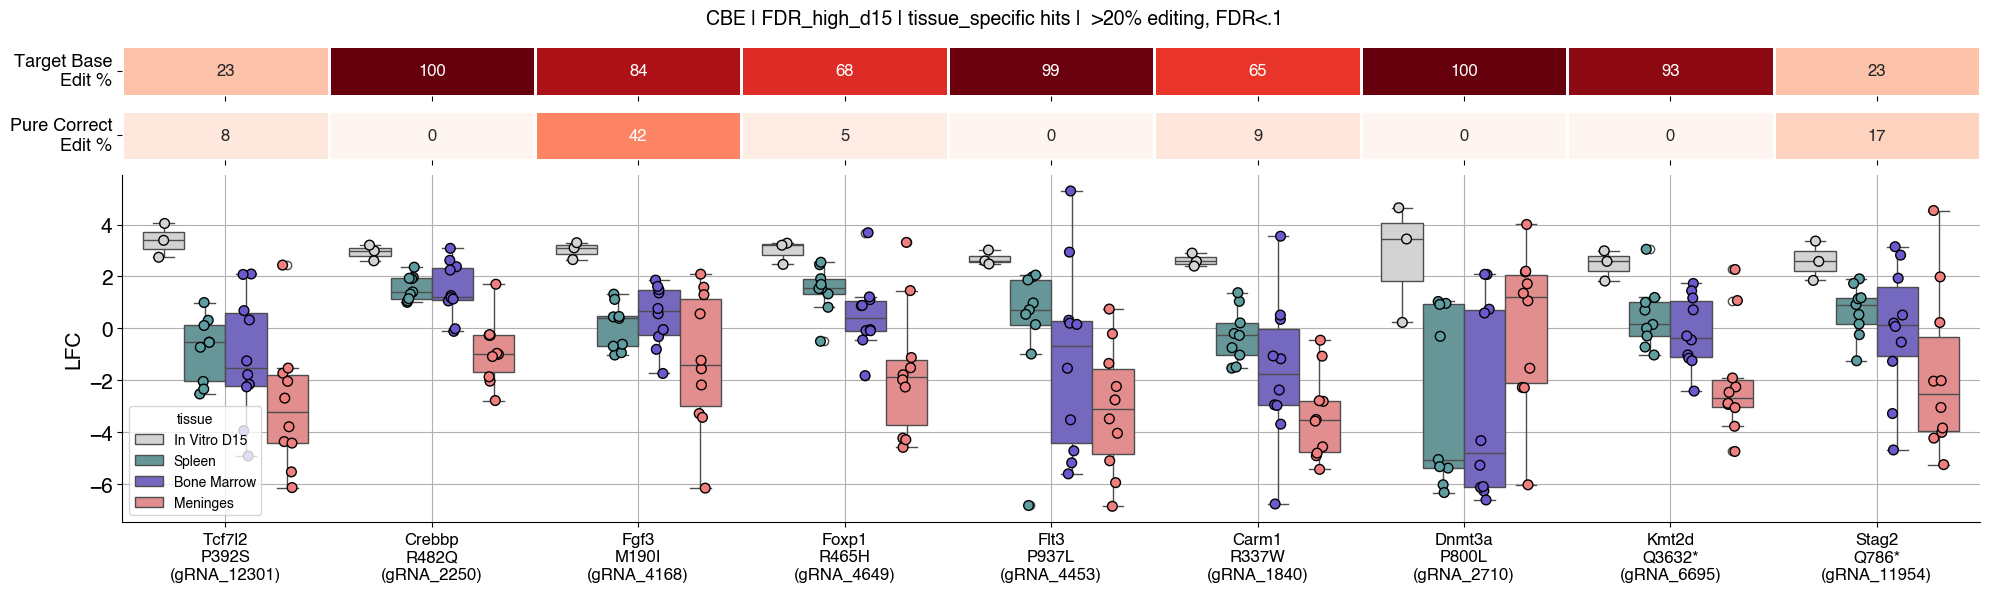

In [191]:
fig, ax = plt.subplots(3,1,figsize=(20,6), height_ratios=[1,1,7])
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro D15', 'Spleen', 'Bone Marrow', 'Meninges']

sns.stripplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], palette=palette, hue_order = ho)

sns.heatmap([np.asarray(t['target_base_edit_perc'])], ax=ax[0], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')
sns.heatmap([np.asarray(t['corr_perc'])], ax=ax[1], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')

#ax[1].plot([0,9.5],[0,0])
ax[2].grid()
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].set_yticklabels(['Target Base\nEdit %'], rotation=0, fontsize=13)
ax[1].set_yticklabels(['Pure Correct\nEdit %'], rotation=0, fontsize=13)

ax[2].set_ylabel('LFC', fontsize=15)
ax[2].set_xlabel('')
ax[2].set_xticklabels(t['Name'])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].tick_params(axis='x', which='major', labelsize=12)
ax[2].tick_params(axis='y', which='major', labelsize=15)

fig.suptitle(f'CBE | {COI} | {type_hit} hits |  >20% editing, FDR<.1', fontsize=14)

fig.tight_layout()

In [ ]:
####ABE
#same for ABE
ABE_samp_dict3 = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}


In [162]:
FDR_cutoff = 0.1
#meninges_specific = CBE_LFC[(CBE_LFC['FDR_high_meninges']<=FDR_cutoff) & (CBE_LFC['FDR_high_spleen']<=FDR_cutoff) & (CBE_LFC['FDR_high_bonemarrow']<=FDR_cutoff) & (CBE_LFC['FDR_high_d15']>FDR_cutoff)]

COI = 'FDR_high_spleen'
min_edit = 20
type_hit = 'general' #'general'ABE_LFC

#general hits
if type_hit=='general':
    meninges_specific = ABE_LFC[(ABE_LFC[COI]<=FDR_cutoff) & (ABE_LFC['target_base_edit_perc']>=min_edit)]

#tissue specific hits
elif type_hit=='tissue_specific':
    s1 = ['FDR_high_bonemarrow', 'FDR_high_spleen', 'FDR_high_meninges', 'FDR_high_d15']
    s1.remove(COI)
    assert len(s1)==3
    meninges_specific = ABE_LFC[(ABE_LFC[COI]<=FDR_cutoff) & (ABE_LFC[s1[0]]>FDR_cutoff) & (ABE_LFC[s1[1]]>FDR_cutoff) & (ABE_LFC[s1[2]]>FDR_cutoff) & (ABE_LFC['target_base_edit_perc']>=min_edit)]

meninges_specific = meninges_specific[~meninges_specific['Gene'].isin(['safe_target', 'non_target'])]

meninges_specific = meninges_specific.sort_values(by=COI,ascending=True)[:15]

meninges_specific['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in meninges_specific.iterrows()]

#get meninges
l1 = list(ABE_samp_dict3['meninges'])
melted_1 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc', 'sensor_reads', 'Input_median','Name'], value_vars=l1, 
                     var_name='tissue', value_name='LFC')
melted_1['tissue'] = "Meninges"

#spleen
l2 = list(ABE_samp_dict3['spleen'])
melted_2 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l2, 
                     var_name='tissue', value_name='LFC')
melted_2['tissue'] = 'Spleen'

#bm
l3 = list(ABE_samp_dict3['bonemarrow'])
melted_3 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l3, 
                     var_name='tissue', value_name='LFC')
melted_3['tissue'] = 'Bone Marrow'

#in vitro
l4 = list(ABE_samp_dict3['d15'])
melted_4 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l4, 
                     var_name='tissue', value_name='LFC')
melted_4['tissue'] = 'In Vitro D15'


plotting_df = pd.concat((melted_1, melted_2, melted_3, melted_4))
t = plotting_df.drop_duplicates(subset='gRNA_id')[['target_base_edit_perc', 'corr_perc','sensor_reads', 'Name']]


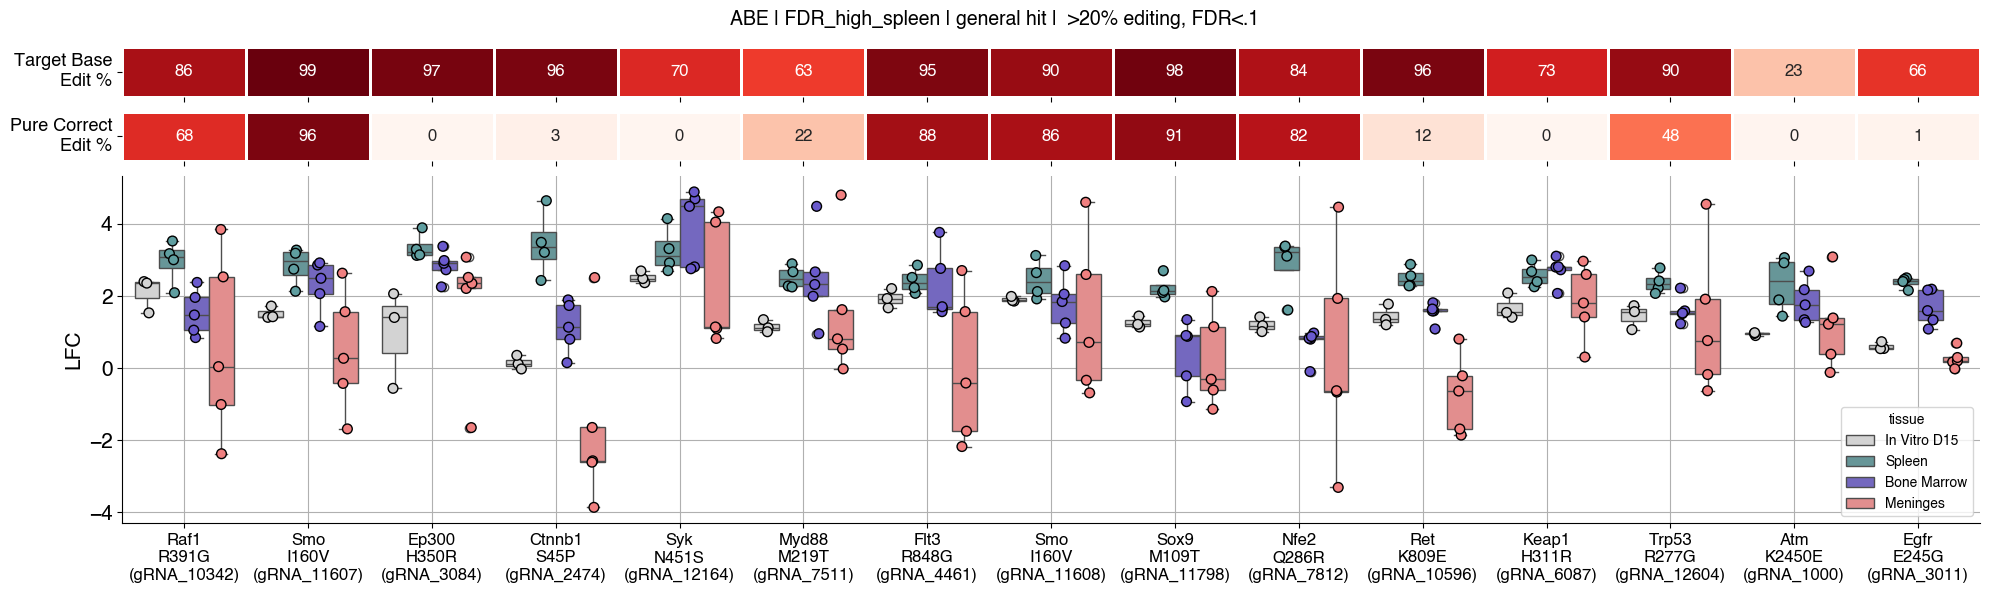

In [166]:
fig, ax = plt.subplots(3,1,figsize=(20,6), height_ratios=[1,1,7])
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro D15', 'Spleen', 'Bone Marrow', 'Meninges']

sns.stripplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], palette=palette, hue_order = ho)

sns.heatmap([np.asarray(t['target_base_edit_perc'])], ax=ax[0], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')
sns.heatmap([np.asarray(t['corr_perc'])], ax=ax[1], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')

#ax[1].plot([0,9.5],[0,0])
ax[2].grid()
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].set_yticklabels(['Target Base\nEdit %'], rotation=0, fontsize=13)
ax[1].set_yticklabels(['Pure Correct\nEdit %'], rotation=0, fontsize=13)

ax[2].set_ylabel('LFC', fontsize=15)
ax[2].set_xlabel('')
ax[2].set_xticklabels(t['Name'])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].tick_params(axis='x', which='major', labelsize=12)
ax[2].tick_params(axis='y', which='major', labelsize=15)


fig.suptitle(f'ABE | {COI} | {type_hit} hits |  >20% editing, FDR<.1', fontsize=14)

fig.tight_layout()

In [112]:
FDR_cutoff = 0.1
#meninges_specific = CBE_LFC[(CBE_LFC['FDR_high_meninges']<=FDR_cutoff) & (CBE_LFC['FDR_high_spleen']<=FDR_cutoff) & (CBE_LFC['FDR_high_bonemarrow']<=FDR_cutoff) & (CBE_LFC['FDR_high_d15']>FDR_cutoff)]

COI = 'FDR_low_meninges'
min_edit = 20

m = ABE_LFC[(ABE_LFC['FDR_low_meninges']<=FDR_cutoff) & (ABE_LFC['target_base_edit_perc']>=min_edit)]
m.sort_values(by='FDR_low_meninges')[:50]

gRNA_id    Gene   spleen1   spleen2   spleen3   spleen4  \
25    gRNA_671  Arid1a -3.481979 -1.666607 -2.543993 -4.467769   
216  gRNA_2440    Ctcf -2.267264 -1.761775 -3.189127 -4.146675   
226  gRNA_2494  Ctnnb1 -2.238856 -3.021354 -3.591726 -3.351482   

     LFC_avg_spleen  LFC_median_spleen  Input_median  \
25        -3.040087          -3.012986    628.853436   
216       -2.841210          -2.728195   1391.679996   
226       -3.050854          -3.186418    784.914902   

     p_high_unadjusted_spleen  ...  gene_name_m  sensor_reads  corr_perc  \
25                   0.999997  ...       Arid1a           735  83.673469   
216                  0.999992  ...         Ctcf          1533  14.742335   
226                  1.000000  ...       Ctnnb1           370   0.000000   

     target_base_edit_perc  byproduct_INDEL_perc  byproduct_sub_perc  Editor  \
25               90.340136                   0.0           11.972789     ABE   
216              73.255055                   0.0           73.255055     ABE   
226              36.756757                   0.0           87.837838     ABE   

      classification  HGVSp_h  HGVSp_m  
25   targeting guide   D1050G   D1051G  
216  targeting guide    C384R    C384R  
226  targeting guide     T41A     T41A  

[3 rows x 70 columns]

In [252]:
ABE_set = ['gRNA_10342','gRNA_2474', 'gRNA_12604','gRNA_2494','gRNA_2458','gRNA_12164','gRNA_11607','gRNA_12386', 'gRNA_13271', 'gRNA_13607']
CBE_set = ['gRNA_12312','gRNA_10131','gRNA_10211','gRNA_4802','gRNA_8280','gRNA_11491', 'gRNA_13292']


FDR_cutoff = 0.1
#meninges_specific = CBE_LFC[(CBE_LFC['FDR_high_meninges']<=FDR_cutoff) & (CBE_LFC['FDR_high_spleen']<=FDR_cutoff) & (CBE_LFC['FDR_high_bonemarrow']<=FDR_cutoff) & (CBE_LFC['FDR_high_d15']>FDR_cutoff)]

COI = 'ABE Selected gRNAs'

meninges_specific = ABE_LFC[ABE_LFC['gRNA_id'].isin(ABE_set)]

meninges_specific['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in meninges_specific.iterrows()]

#get meninges
l1 = list(ABE_samp_dict3['meninges'])
melted_1 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc', 'sensor_reads', 'Input_median','Name'], value_vars=l1, 
                     var_name='tissue', value_name='LFC')
melted_1['tissue'] = "Meninges"

#spleen
l2 = list(ABE_samp_dict3['spleen'])
melted_2 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l2, 
                     var_name='tissue', value_name='LFC')
melted_2['tissue'] = 'Spleen'

#bm
l3 = list(ABE_samp_dict3['bonemarrow'])
melted_3 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l3, 
                     var_name='tissue', value_name='LFC')
melted_3['tissue'] = 'Bone Marrow'

#in vitro
l4 = list(ABE_samp_dict3['d15'])
melted_4 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l4, 
                     var_name='tissue', value_name='LFC')
melted_4['tissue'] = 'In Vitro D15'


plotting_df = pd.concat((melted_1, melted_2, melted_3, melted_4))
t = plotting_df.drop_duplicates(subset='gRNA_id')[['target_base_edit_perc', 'corr_perc','sensor_reads', 'Name']]


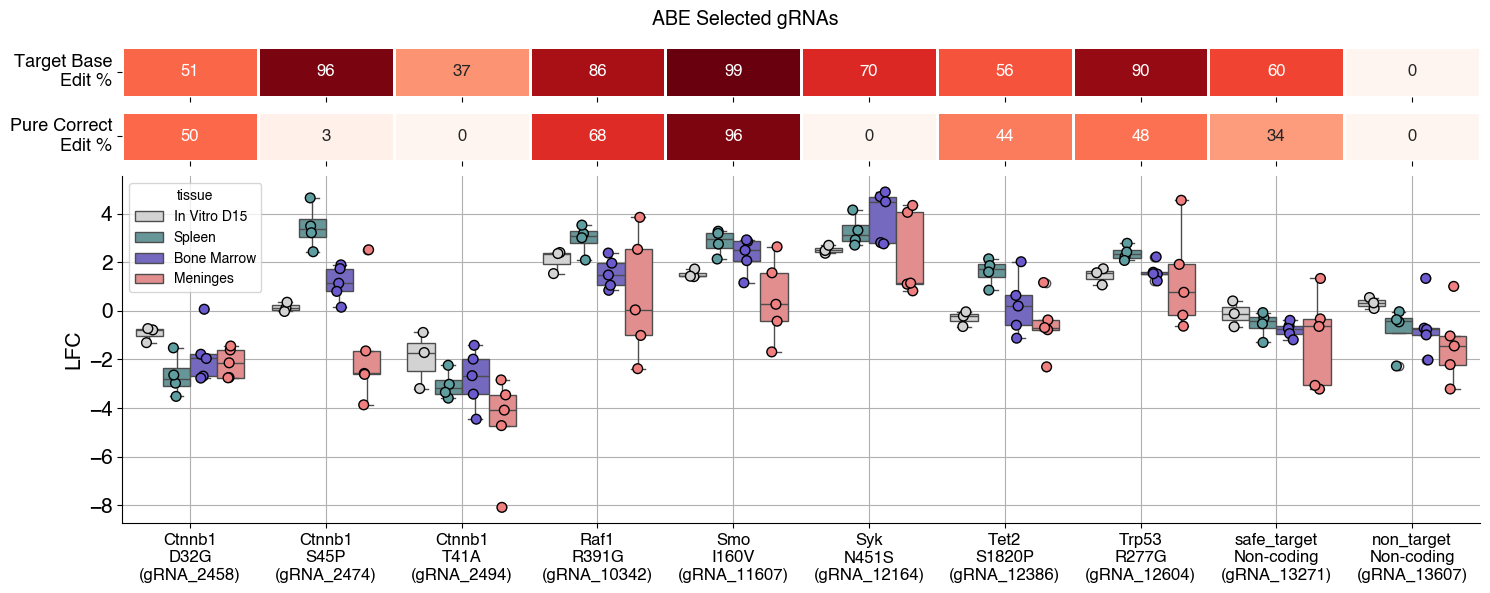

In [253]:
fig, ax = plt.subplots(3,1,figsize=(15,6), height_ratios=[1,1,7])
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro D15', 'Spleen', 'Bone Marrow', 'Meninges']

sns.stripplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], palette=palette, hue_order = ho)

sns.heatmap([np.asarray(t['target_base_edit_perc'])], ax=ax[0], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')
sns.heatmap([np.asarray(t['corr_perc'])], ax=ax[1], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')

#ax[1].plot([0,9.5],[0,0])
ax[2].grid()
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].set_yticklabels(['Target Base\nEdit %'], rotation=0, fontsize=13)
ax[1].set_yticklabels(['Pure Correct\nEdit %'], rotation=0, fontsize=13)

ax[2].set_ylabel('LFC', fontsize=15)
ax[2].set_xlabel('')
ax[2].set_xticklabels(t['Name'])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].tick_params(axis='x', which='major', labelsize=12)
ax[2].tick_params(axis='y', which='major', labelsize=15)


fig.suptitle(f'{COI}', fontsize=14)

fig.tight_layout()

In [238]:
#and then CBE
FDR_cutoff = 0.1
#meninges_specific = CBE_LFC[(CBE_LFC['FDR_high_meninges']<=FDR_cutoff) & (CBE_LFC['FDR_high_spleen']<=FDR_cutoff) & (CBE_LFC['FDR_high_bonemarrow']<=FDR_cutoff) & (CBE_LFC['FDR_high_d15']>FDR_cutoff)]

COI = 'CBE Selected gRNAs'

meninges_specific = CBE_LFC[CBE_LFC['gRNA_id'].isin(CBE_set)]

meninges_specific['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in meninges_specific.iterrows()]

#get meninges
l1 = list(CBE_samp_dict3['meninges'])
melted_1 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc', 'sensor_reads', 'Input_median','Name'], value_vars=l1, 
                     var_name='tissue', value_name='LFC')
melted_1['tissue'] = "Meninges"

#spleen
l2 = list(CBE_samp_dict3['spleen'])
melted_2 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l2, 
                     var_name='tissue', value_name='LFC')
melted_2['tissue'] = 'Spleen'

#bm
l3 = list(CBE_samp_dict3['bonemarrow'])
melted_3 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l3, 
                     var_name='tissue', value_name='LFC')
melted_3['tissue'] = 'Bone Marrow'

#in vitro
l4 = list(CBE_samp_dict3['d15'])
melted_4 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l4, 
                     var_name='tissue', value_name='LFC')
melted_4['tissue'] = 'In Vitro D15'


plotting_df = pd.concat((melted_1, melted_2, melted_3, melted_4))
t = plotting_df.drop_duplicates(subset='gRNA_id')[['target_base_edit_perc', 'corr_perc','sensor_reads', 'Name']]



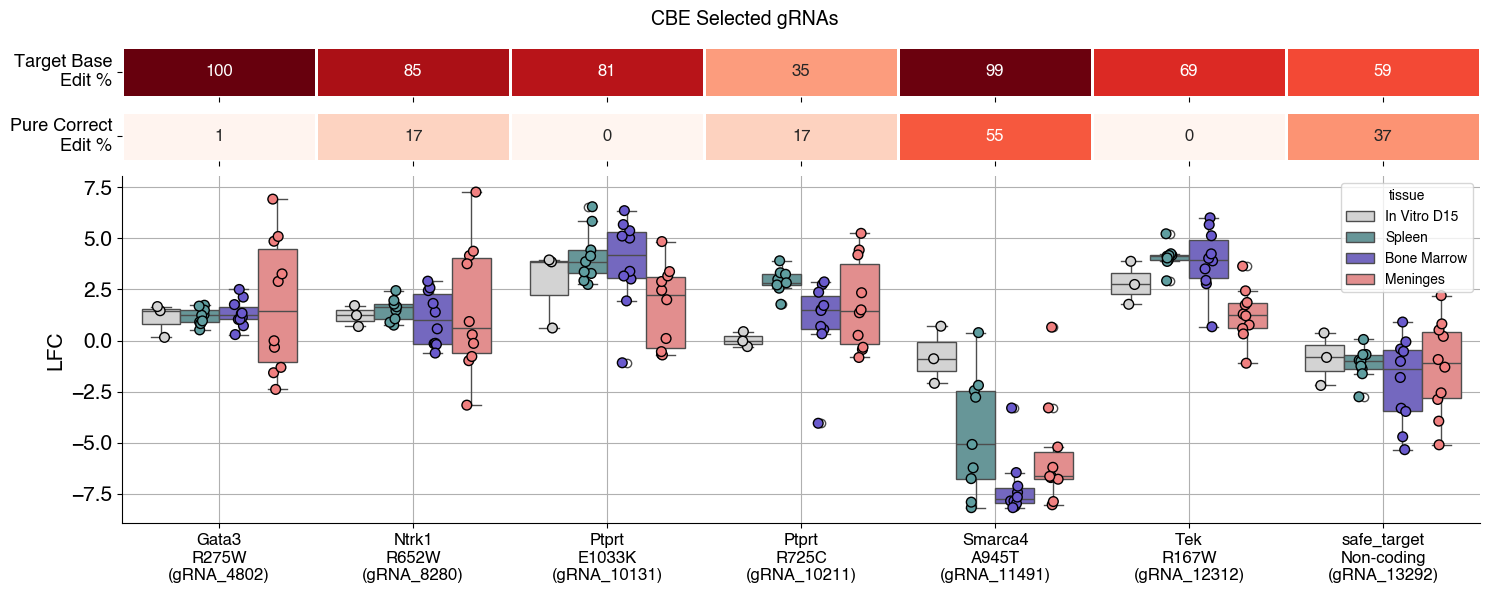

In [240]:
fig, ax = plt.subplots(3,1,figsize=(15,6), height_ratios=[1,1,7])
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro D15', 'Spleen', 'Bone Marrow', 'Meninges']

sns.stripplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=plotting_df, x='gRNA_id', y='LFC', hue='tissue', ax=ax[2], palette=palette, hue_order = ho)

sns.heatmap([np.asarray(t['target_base_edit_perc'])], ax=ax[0], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')
sns.heatmap([np.asarray(t['corr_perc'])], ax=ax[1], cmap='Reds', cbar=False, vmin=0, vmax=100, linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f')

#ax[1].plot([0,9.5],[0,0])
ax[2].grid()
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].set_yticklabels(['Target Base\nEdit %'], rotation=0, fontsize=13)
ax[1].set_yticklabels(['Pure Correct\nEdit %'], rotation=0, fontsize=13)

ax[2].set_ylabel('LFC', fontsize=15)
ax[2].set_xlabel('')
ax[2].set_xticklabels(t['Name'])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].tick_params(axis='x', which='major', labelsize=12)
ax[2].tick_params(axis='y', which='major', labelsize=15)


fig.suptitle(f'{COI}', fontsize=14)

fig.tight_layout()

In [254]:
meninges_specific[['Gene','Input_median']]

Gene  Input_median
221        Ctnnb1    583.279661
225        Ctnnb1    126.599178
226        Ctnnb1    784.914902
772          Raf1    101.279342
886           Smo    253.487392
919           Syk    135.796817
930          Tet2   1115.531313
988         Trp53    275.473543
1045  safe_target   1145.866474
1068   non_target    690.371707

# Checking input counts

In [278]:
ABE_counts = pd.read_csv('mageck/ABE_bc_counts.txt', sep='\t')
CBE_counts = pd.read_csv('mageck/CBE_bc_counts.txt', sep='\t')

ABE_set = ['gRNA_10342','gRNA_2474', 'gRNA_12604','gRNA_2494','gRNA_2458','gRNA_12164','gRNA_11607','gRNA_12386', 'gRNA_13271', 'gRNA_13607']
CBE_set = ['gRNA_12312','gRNA_10131','gRNA_10211','gRNA_4802','gRNA_8280','gRNA_11491', 'gRNA_13292']


print(ABE_counts[ABE_counts['sgRNA'].isin(ABE_set)][['sgRNA', 'input_rep1', 'input_rep2', 'input_rep3']])

print(ABE_RPM[ABE_RPM['sgRNA'].isin(ABE_set)][['sgRNA', 'input_rep1', 'input_rep2', 'input_rep3']])

           sgRNA  input_rep1  input_rep2  input_rep3
221    gRNA_2458       173.0       660.0       450.0
225    gRNA_2474        54.0       358.0        73.0
226    gRNA_2494       340.0       607.0       496.0
772   gRNA_10342        43.0       138.0        52.0
886   gRNA_11607       105.0       392.0       195.0
919   gRNA_12164        69.0        89.0       104.0
930   gRNA_12386       299.0       815.0      1005.0
988   gRNA_12604        89.0       451.0       212.0
1045  gRNA_13271       220.0       865.0       885.0
1068  gRNA_13607       258.0       504.0       739.0
           sgRNA  input_rep1   input_rep2   input_rep3
221    gRNA_2458  400.513762   903.635046   583.279661
225    gRNA_2474  126.599178   490.779095    95.704423
226    gRNA_2494  784.914902   831.180194   642.771600
772   gRNA_10342  101.279342   190.023104    68.545060
886   gRNA_11607  243.991143   537.259566   253.487392
919   gRNA_12164  161.126226   123.036542   135.796817
930   gRNA_12386  690.540970  11

In [280]:
print(ABE_counts[ABE_counts['sgRNA'].isin(ABE_set)][['sgRNA', 'spleen1', 'spleen2', 'spleen3', 'spleen4']])

print(ABE_RPM[ABE_RPM['sgRNA'].isin(ABE_set)][['sgRNA', 'spleen1', 'spleen2', 'spleen3', 'spleen4']])

           sgRNA  spleen1  spleen2  spleen3  spleen4
221    gRNA_2458     28.0    213.0     24.0     55.0
225    gRNA_2474    266.0   1500.0    576.0   1895.0
226    gRNA_2494     64.0    101.0     31.0     45.0
772   gRNA_10342    357.0    858.0    573.0    257.0
886   gRNA_11607    958.0   1793.0   1134.0    664.0
919   gRNA_12164    527.0   1083.0    434.0   1440.0
930   gRNA_12386   1921.0   4277.0    989.0   2020.0
988   gRNA_12604    502.0   1994.0    723.0    692.0
1045  gRNA_13271    366.0    490.0    389.0    651.0
1068  gRNA_13607     55.0    531.0    330.0    320.0
           sgRNA      spleen1      spleen2      spleen3      spleen4
221    gRNA_2458    74.189860   202.823416    50.862216    93.617306
225    gRNA_2474   683.058362  1422.607229  1173.899952  3169.614497
226    gRNA_2494   166.287616    96.672843    65.103637    76.899930
772   gRNA_10342   915.861024   814.136982  1167.796486   431.308302
886   gRNA_11607  2453.381906  1700.304709  2309.144620  1111.705507
919

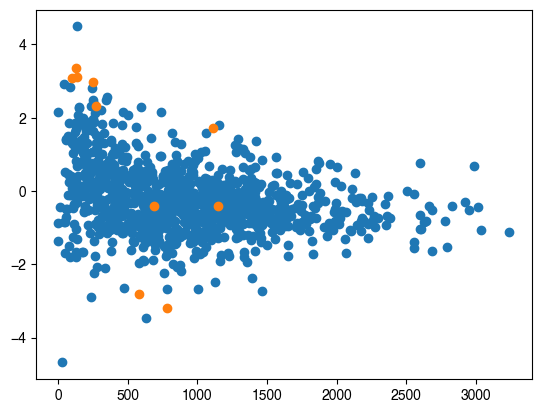

In [ ]:
x,y = ABE_LFC['Input_median'], ABE_LFC['LFC_median_bonemarrow']
plt.scatter(x,y)


ABE_set = ['gRNA_10342','gRNA_2474', 'gRNA_12604','gRNA_2494','gRNA_2458','gRNA_12164','gRNA_11607','gRNA_12386', 'gRNA_13271', 'gRNA_13607']
CBE_set = ['gRNA_12312','gRNA_10131','gRNA_10211','gRNA_4802','gRNA_8280','gRNA_11491', 'gRNA_13292']

ABE_sub = ABE_LFC[ABE_LFC['gRNA_id'].isin(ABE_set)]

x1, y1 = ABE_sub['Input_median'], ABE_sub['LFC_median_spleen']
plt.scatter(x1,y1)

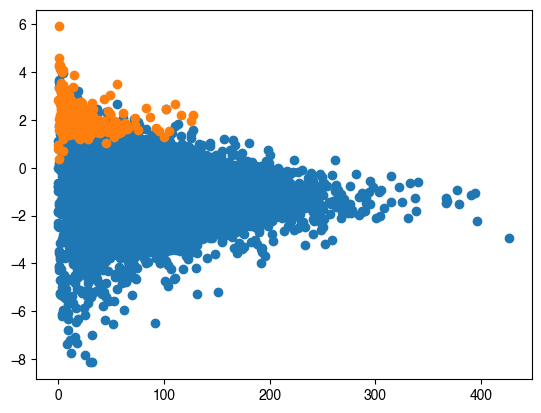

In [293]:
x,y = CBE_LFC['Input_median'], CBE_LFC['LFC_median_bonemarrow']
plt.scatter(x,y)


ABE_set = ['gRNA_10342','gRNA_2474', 'gRNA_12604','gRNA_2494','gRNA_2458','gRNA_12164','gRNA_11607','gRNA_12386', 'gRNA_13271', 'gRNA_13607']
CBE_set = ['gRNA_12312','gRNA_10131','gRNA_10211','gRNA_4802','gRNA_8280','gRNA_11491', 'gRNA_13292']

#CBE_sub = CBE_LFC[CBE_LFC['gRNA_id'].isin(CBE_set)]
CBE_sub = CBE_LFC[CBE_LFC['FDR_high_spleen']<.1]
x1, y1 = CBE_sub['Input_median'], CBE_sub['LFC_avg_spleen']
plt.scatter(x1,y1)

In [271]:
print(np.median(CBE_counts[['input_rep1', 'input_rep2', 'input_rep3']], axis=0))
print(np.median(ABE_counts[['input_rep1', 'input_rep2', 'input_rep3']], axis=0))

[1199.  1293.  1523.5]
[304.5 672.5 654. ]


In [ ]:
CBE_counts[CBE_counts['sgRNA'].isin(CBE_set)][['sgRNA', 'input_rep1', 'input_rep2', 'input_rep3']]

sgRNA  input_rep1  input_rep2  input_rep3
4337    gRNA_4802      1457.0      1131.0      1549.0
7614    gRNA_8280       244.0       389.0       704.0
9365   gRNA_10131        70.0        19.0        37.0
9444   gRNA_10211       166.0       307.0       227.0
10612  gRNA_11491        18.0       385.0       355.0
11384  gRNA_12312        60.0       200.0       145.0
12231  gRNA_13292      1352.0       891.0       774.0

In [260]:
CBE_RPM[CBE_RPM['sgRNA'].isin(CBE_set)][['sgRNA', 'input_rep1', 'input_rep2', 'input_rep3']]

sgRNA  input_rep1  input_rep2  input_rep3
4337    gRNA_4802   79.602820   56.998149   51.519316
7614    gRNA_8280   13.376331   19.637172   23.432979
9365   gRNA_10131    3.876406    1.007034    1.263054
9444   gRNA_10211    9.117744   15.508330    7.578325
10612  gRNA_11491    1.037348   19.435765   11.832824
11384  gRNA_12312    3.330433   10.120696    4.852787
12231  gRNA_13292   73.870107   44.913736   25.759658

# Ordering gRNAs

In [243]:
comb_set = ABE_set + CBE_set

lib = pd.read_csv('MBESv2_CORRECTED.csv')

selected = lib[lib['gRNA_id'].isin(comb_set)].reset_index(drop=True)
selected

gRNA_id mutation_idx gene_name_h           gene_id_h  \
0    gRNA_2458         2045      CTNNB1  ENSG00000168036.12   
1    gRNA_2474         2060      CTNNB1  ENSG00000168036.12   
2    gRNA_2494         2072      CTNNB1  ENSG00000168036.12   
3    gRNA_4802         4019       GATA3  ENSG00000107485.11   
4    gRNA_8280         6867       NTRK1   ENSG00000198400.7   
5   gRNA_10131         8343       PTPRT   ENSG00000196090.8   
6   gRNA_10211         8417       PTPRT   ENSG00000196090.8   
7   gRNA_10342         8561        RAF1   ENSG00000132155.7   
8   gRNA_11491         9553     SMARCA4  ENSG00000127616.13   
9   gRNA_11607         9633         SMO   ENSG00000128602.5   
10  gRNA_12164        10049         SYK  ENSG00000165025.10   
11  gRNA_12312        10178         TEK  ENSG00000120156.16   
12  gRNA_12386        10241        TET2   ENSG00000168769.8   
13  gRNA_12604        10448        TP53  ENSG00000141510.11   
14  gRNA_13271      safe_12         NaN                 NaN   
15  gRNA_13292      safe_33         NaN                 NaN   
16  gRNA_13607         nt_9         NaN                 NaN   

              tx_id_h  chr_h  exon_num_h strand_h match      start_h  ...  \
0   ENST00000349496.5   chr3        14.0        +  True   41266098.0  ...   
1   ENST00000349496.5   chr3        14.0        +  True   41266136.0  ...   
2   ENST00000349496.5   chr3        14.0        +  True   41266124.0  ...   
3   ENST00000346208.3  chr10         5.0        +  True    8106003.0  ...   
4   ENST00000524377.1   chr1        17.0        +  True  156849053.0  ...   
5   ENST00000373187.1  chr20        31.0        -  True   40743883.0  ...   
6   ENST00000373187.1  chr20        31.0        -  True   40911144.0  ...   
7   ENST00000251849.4   chr3        16.0        -  True   12633229.0  ...   
8   ENST00000344626.4  chr19        34.0        +  True   11132617.0  ...   
9   ENST00000249373.3   chr7        12.0        +  True  128843359.0  ...   
10  ENST00000375746.1   chr9        13.0        +  True   93640041.0  ...   
11  ENST00000380036.4   chr9        23.0        +  True   27169498.0  ...   
12  ENST00000380013.4   chr4         9.0        +  True  106197359.0  ...   
13  ENST00000269305.4  chr17        10.0        -  True    7577100.0  ...   
14                NaN    NaN         NaN      NaN   NaN          NaN  ...   
15                NaN    NaN         NaN      NaN   NaN          NaN  ...   
16                NaN    NaN         NaN      NaN   NaN          NaN  ...   

    contains_polyT_terminator contains_RE_site num_potential_vars  \
0                       False            False                1.0   
1                       False            False                1.0   
2                       False            False                1.0   
3                       False            False                1.0   
4                       False            False                1.0   
5                       False            False                1.0   
6                       False            False                1.0   
7                       False            False                1.0   
8                       False            False                1.0   
9                       False            False                1.0   
10                      False            False                1.0   
11                      False            False                1.0   
12                      False            False                1.0   
13                      False            False                1.0   
14                      False            False                NaN   
15                      False            False                NaN   
16                      False            False                NaN   

            classification Genome_version       Hamming_BC   Pool  \
0          targeting guide         GrCm39  ACACAAGGAACACAA  F1-R1   
1          targeting guide         GrCm39  GATGCAACTATTAGA  F1-R1   
2          targeting guide         

In [245]:
selected['Protospacer']

0     GGGATTCTGGAATCCATTCT
1     GGGGAAGGAGCTGTGGTGGT
2     GACCACCACAGCTCCTTCCC
3     GGTGGCGGCGAGATGGTACC
4     GGCACCGGGATCTGGCCACA
5     GGGGGCTCTGTTTCTATTAG
6     GTGTGCGTCTGGCTACAAAA
7     GCCTTCAGGAACGAGGTGGC
8     GGGTGCATTGAACCACTGTT
9     GTGCCATTGTGGAGCGGGAG
10    GCTCAACAAGTACCTGCAGC
11    GTGCCCCGGCATGAAGTACC
12    GAAGTGAGATCCTGGTGGGG
13    GCTGGGAGAGACCGCCGTAC
14    GAGATAGAAAAGGCAGGAAG
15    GATTGCCTAGCAGAAAGAGG
16    GTTCGTGCATCGCGGGGTTT
Name: Protospacer, dtype: object

In [247]:
import Bio.Seq 

topoligos = []
botoligos = []
for i, val in selected.iterrows():
    p = val['Protospacer']
    p_rc = str(Bio.Seq.Seq(p).reverse_complement())
    top_oligo = 'CACC' + p
    bot_oligo = 'AAAC' + p_rc
    topoligos.append(top_oligo)
    botoligos.append(bot_oligo)

selected['top_oligo'] = topoligos
selected['bot_oligo'] = botoligos

topside = pd.DataFrame(dict(zip(['gRNA_id', 'top_oligo'], [selected['gRNA_id'], selected['top_oligo']])))
topside['name'] = [f"gRNA_{i.split('_')[-1]}_T" for i in topside['gRNA_id']]
topside = topside[['name', 'top_oligo']]

botside = pd.DataFrame(dict(zip(['gRNA_id', 'top_oligo'], [selected['gRNA_id'], selected['bot_oligo']])))
botside['name'] = [f"gRNA_{i.split('_')[-1]}_B" for i in botside['gRNA_id']]
botside = botside[['name', 'top_oligo']]

pd.concat((topside, botside))

name                 top_oligo
0    gRNA_2458_T  CACCGGGATTCTGGAATCCATTCT
1    gRNA_2474_T  CACCGGGGAAGGAGCTGTGGTGGT
2    gRNA_2494_T  CACCGACCACCACAGCTCCTTCCC
3    gRNA_4802_T  CACCGGTGGCGGCGAGATGGTACC
4    gRNA_8280_T  CACCGGCACCGGGATCTGGCCACA
5   gRNA_10131_T  CACCGGGGGCTCTGTTTCTATTAG
6   gRNA_10211_T  CACCGTGTGCGTCTGGCTACAAAA
7   gRNA_10342_T  CACCGCCTTCAGGAACGAGGTGGC
8   gRNA_11491_T  CACCGGGTGCATTGAACCACTGTT
9   gRNA_11607_T  CACCGTGCCATTGTGGAGCGGGAG
10  gRNA_12164_T  CACCGCTCAACAAGTACCTGCAGC
11  gRNA_12312_T  CACCGTGCCCCGGCATGAAGTACC
12  gRNA_12386_T  CACCGAAGTGAGATCCTGGTGGGG
13  gRNA_12604_T  CACCGCTGGGAGAGACCGCCGTAC
14  gRNA_13271_T  CACCGAGATAGAAAAGGCAGGAAG
15  gRNA_13292_T  CACCGATTGCCTAGCAGAAAGAGG
16  gRNA_13607_T  CACCGTTCGTGCATCGCGGGGTTT
0    gRNA_2458_B  AAACAGAATGGATTCCAGAATCCC
1    gRNA_2474_B  AAACACCACCACAGCTCCTTCCCC
2    gRNA_2494_B  AAACGGGAAGGAGCTGTGGTGGTC
3    gRNA_4802_B  AAACGGTACCATCTCGCCGCCACC
4    gRNA_8280_B  AAACTGTGGCCAGATCCCGGTGCC
5   gRNA_10131_B  AAACCTAATAGAAACAGAGCCCCC
6   gRNA_10211_B  AAACTTTTGTAGCCAGACGCACAC
7   gRNA_10342_B  AAACGCCACCTCGTTCCTGAAGGC
8   gRNA_11491_B  AAACAACAGTGGTTCAATGCACCC
9   gRNA_11607_B  AAACCTCCCGCTCCACAATGGCAC
10  gRNA_12164_B  AAACGCTGCAGGTACTTGTTGAGC
11  gRNA_12312_B  AAACGGTACTTCATGCCGGGGCAC
12  gRNA_12386_B  AAACCCCCACCAGGATCTCACTTC
13  gRNA_12604_B  AAACGTACGGCGGTCTCTCCCAGC
14  gRNA_13271_B  AAACCTTCCTGCCTTTTCTATCTC
15  gRNA_13292_B  AAACCCTCTTTCTGCTAGGCAATC
16  gRNA_13607_B  AAACAAACCCCGCGATGCACGAAC

# Validation gRNA analysis

In [485]:
validation = pd.read_excel('B-ALL validation.xlsx')

#exclude gRNA 4
validation = validation[validation['sgRNA']!='ABE4']

holder = []
for i in np.unique(validation['sgRNA']):
    initial_perc = validation[(validation['sgRNA']==i) & (validation['Timepoint']=='Initial')]['Percent_population'].values[0]
    subset = validation[validation['sgRNA']==i]
    subset['FoldChange'] = np.asarray(subset['Percent_population'])/initial_perc
    subset['LFC'] = np.log2(np.asarray(subset['Percent_population'])/initial_perc)
    holder.append(subset)

validation_lfc = pd.concat(holder)


gRNA_dict = {'ABE2':'gRNA_13607',
'ABE1':	'gRNA_12604',
'ABE8':	'gRNA_2474',
'ABE15': 'gRNA_12386',
'ABE3':	'gRNA_2458',
'ABE17':'gRNA_11607',
'CBE13': 'gRNA_10211',
'CBE14':'gRNA_4802',
'CBE16':'gRNA_13292',
'ABE6':	'gRNA_10342',
'ABE10': 'gRNA_12164',
'CBE9':	'gRNA_12312',
'CBE11':'gRNA_8280',
'CBE12':'gRNA_10131'}
#'ABE12':'gRNA_31',


validation_lfc['gRNA_id'] = [gRNA_dict[i] for i in validation_lfc['sgRNA']]

ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
ABE_info = ABE_LFC[['gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'classification']]
ABE_info['Editor']='ABE'

CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
CBE_info = CBE_LFC[['gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'classification']]
CBE_info['Editor']='CBE'

comb_info = pd.concat((ABE_info, CBE_info))

validation_merged = pd.merge(validation_lfc, comb_info, on='gRNA_id')

validation_merged['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in validation_merged.iterrows()]
validation_merged


sgRNA  Percent_population Timepoint       Tissue  FoldChange       LFC  \
0    ABE1                16.6   Initial     In Vitro    1.000000  0.000000   
1    ABE1                22.6     Final     In Vitro    1.361446  0.445140   
2    ABE1                25.2     Final     In Vitro    1.518072  0.602240   
3    ABE1                20.8     Final     In Vitro    1.253012  0.325400   
4    ABE1                69.6     Final       Spleen    4.192771  2.067904   
..    ...                 ...       ...          ...         ...       ...   
246  CBE9                18.8     Final  Bone Marrow    1.553719  0.635726   
247  CBE9                29.2     Final     Meninges    2.413223  1.270961   
248  CBE9                22.7     Final     Meninges    1.876033  0.907685   
249  CBE9                36.0     Final     Meninges    2.975207  1.572990   
250  CBE9                 8.9     Final     Meninges    0.735537 -0.443130   

        gRNA_id   Gene HGVSp_m HGVSp_h   classification Editor  \
0    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
1    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
2    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
3    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
4    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
..          ...    ...     ...     ...              ...    ...   
246  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
247  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
248  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
249  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
250  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   

                           Name  
0    Trp53\nR277G\n(gRNA_12604)  
1    Trp53\nR277G\n(gRNA_12604)  
2    Trp53\nR277G\n(gRNA_12604)  
3    Trp53\nR277G\n(gRNA_12604)  
4    Trp53\nR277G\n(gRNA_12604)  
..                          ...  
246    Tek\nR167W\n(gRNA_12312)  
247    Tek\nR167W\n(gRNA_12312)  
248    Tek\nR167W\n(gRNA_12312)  
249    Tek\nR167W\n(gRNA_12312)  
250    Tek\nR167W\n(gRNA_12312)  

[251 rows x 13 columns]

In [454]:
np.unique(validation_merged['sgRNA'])

array(['ABE1', 'ABE10', 'ABE15', 'ABE17', 'ABE2', 'ABE3', 'ABE6', 'ABE8',
       'CBE11', 'CBE12', 'CBE13', 'CBE14', 'CBE16', 'CBE9'], dtype=object)

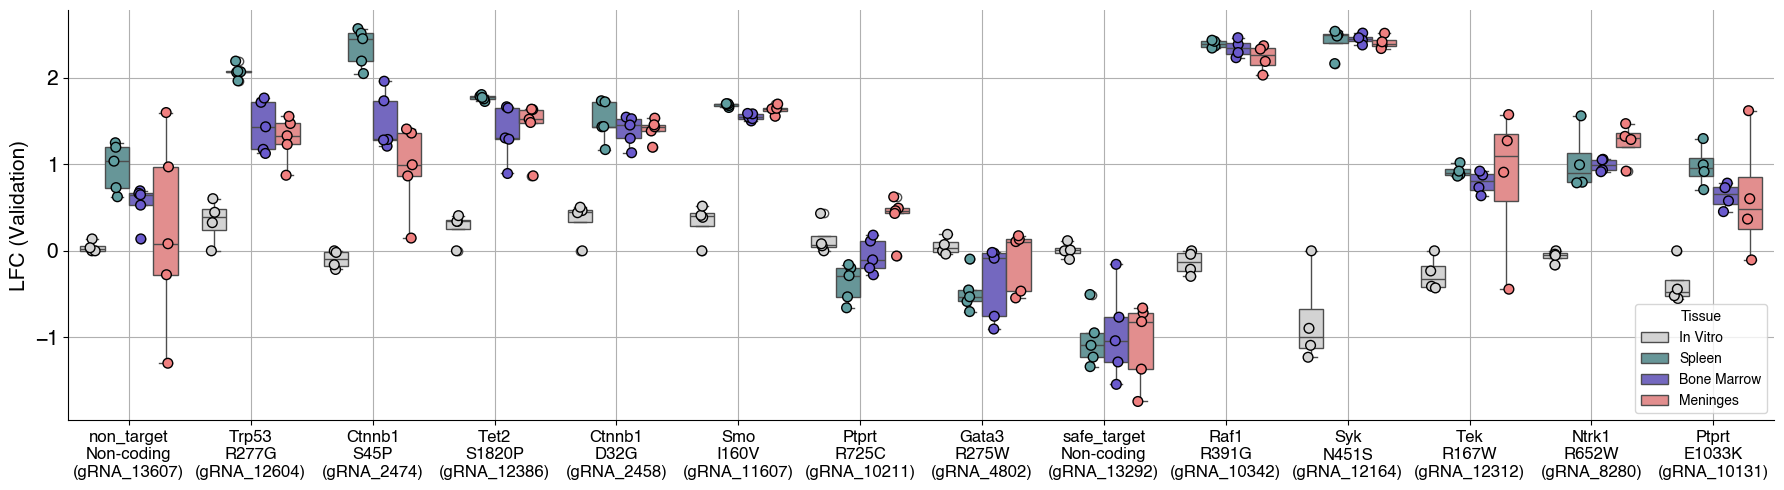

In [484]:
fig, ax = plt.subplots(1,1,figsize=(18,5))
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']


#order = ['gRNA_13607', 'gRNA_12604', 'gRNA_2474',  'gRNA_12386', 'gRNA_2458', 'gRNA_11607', 'gRNA_10211', 'gRNA_4802', 'gRNA_13292']
order = gRNA_dict.values()
sns.stripplot(data=validation_merged, x='gRNA_id', y='LFC', hue='Tissue', ax=ax,  order=order,dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=validation_merged, x='gRNA_id', y='LFC', hue='Tissue', ax=ax, order=order, palette=palette, hue_order = ho)

#ax[1].plot([0,9.5],[0,0])
name_dict = dict(zip(validation_merged['gRNA_id'], validation_merged['Name']))

ax.set_ylabel('LFC (Validation)', fontsize=15)
ax.set_xlabel('')
ax.set_xticklabels([name_dict[i] for i in order])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=15)

ax.grid()

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']


order = ['gRNA_13607', 'gRNA_12604', 'gRNA_2474',  'gRNA_12386', 'gRNA_2458', 'gRNA_11607', 'gRNA_10211', 'gRNA_4802', 'gRNA_13292']
sns.stripplot(data=validation_merged, x='gRNA_id', y='LFC', hue='Tissue', ax=ax,  order=order,dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=validation_merged, x='gRNA_id', y='LFC', hue='Tissue', ax=ax, order=order, palette=palette, hue_order = ho)

#ax[1].plot([0,9.5],[0,0])
name_dict = dict(zip(validation_merged['gRNA_id'], validation_merged['Name']))

ax.set_ylabel('LFC (Validation)', fontsize=15)
ax.set_xlabel('')
ax.set_xticklabels([name_dict[i] for i in order])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=15)

ax.grid()

fig.tight_layout()

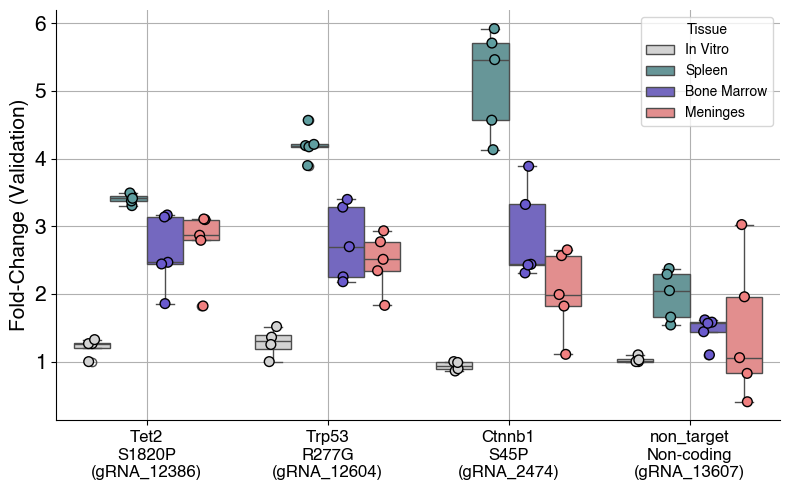

In [265]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']


order = ['gRNA_12386', 'gRNA_12604',  'gRNA_2474','gRNA_13607']
sns.stripplot(data=validation_merged, x='gRNA_id', y='FoldChange', hue='Tissue', ax=ax, order=order, dodge=True, legend=False, edgecolor='black', linewidth=1, s=7, palette=palette, hue_order = ho)
sns.boxplot(data=validation_merged, x='gRNA_id', y='FoldChange', hue='Tissue', ax=ax, order=order,palette=palette, hue_order = ho)

#ax[1].plot([0,9.5],[0,0])
name_dict = dict(zip(validation_merged['gRNA_id'], validation_merged['Name']))

ax.set_ylabel('Fold-Change (Validation)', fontsize=15)
ax.set_xlabel('')
ax.set_xticklabels([name_dict[i] for i in order])

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=15)

ax.grid()

fig.tight_layout()

In [486]:
#and do the comparison
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
ABE_LFC['Editor']='ABE'
CBE_LFC['Editor']='CBE'

a2 = pd.concat((ABE_LFC, CBE_LFC))
screen_data = a2[a2['gRNA_id'].isin(order)]

sp = ['spleen1', 'spleen2', 'spleen3', 'spleen4', 'spleen5', 'spleen6','spleen7', 'spleen8', 'spleen9']
bm = ['bonemarrow1', 'bonemarrow2','bonemarrow3', 'bonemarrow4', 'bonemarrow5','bonemarrow6', 'bonemarrow7','bonemarrow8', 'bonemarrow9', 'bonemarrow10']
men = ['meninges1', 'meninges2', 'meninges3','meninges4', 'meninges5','meninges6', 'meninges7','meninges8', 'meninges9', 'meninges10']
iv = ['d15_rep1','d15_rep2', 'd15_rep3']


sp_std = []
bm_std = []
men_std = []
iv_std = []
for i, val in screen_data.iterrows():
    g = val['gRNA_id']
    subset = screen_data[screen_data['gRNA_id']==g]
    sp1 = np.asarray(subset[sp].dropna(axis=1))
    men1 = np.asarray(subset[men].dropna(axis=1))
    bm1 = np.asarray(subset[bm].dropna(axis=1))
    iv1 = np.asarray(subset[iv].dropna(axis=1))

    sp_std.append(np.std(sp1))
    bm_std.append(np.std(bm1))
    men_std.append(np.std(men1))
    iv_std.append(np.std(iv1))

screen_data['spleen_std'] = sp_std
screen_data['bm_std'] = bm_std
screen_data['meninges_std'] = men_std
screen_data['iv_std'] = iv_std

screen_data_medians = screen_data[['gRNA_id', 'LFC_median_meninges', 'LFC_median_spleen', 'LFC_median_bonemarrow', 'LFC_median_d15', 'Editor', 'spleen_std', 'bm_std', 'meninges_std', 'iv_std']]


data_val = pd.DataFrame(dict(zip(['gRNA_id', 'median_Meninges', 'median_Spleen', 'median_In Vitro', 'median_Bone Marrow'], [order, np.zeros(len(order)),np.zeros(len(order)),np.zeros(len(order)),np.zeros(len(order))])))

for guide in order:

    subset = validation_merged[(validation_merged['gRNA_id']==guide) & (validation_merged['Timepoint']=='Final')]

    for k in ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']:
        lfcs = subset[subset['Tissue']==k]['LFC']
        med = np.median(lfcs)
        std = np.std(lfcs)

        data_val.loc[data_val['gRNA_id']==guide, f'median_{k}'] = med
        data_val.loc[data_val['gRNA_id']==guide, f'std_{k}'] = std

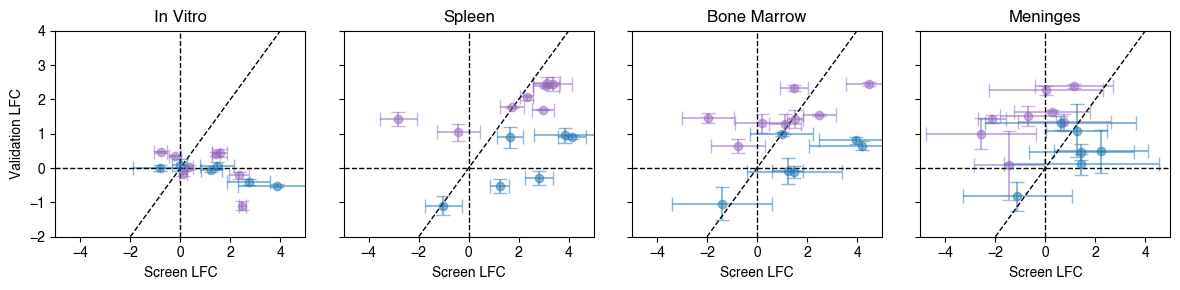

In [ ]:
#m1 = pd.merge(screen_data_medians[screen_data_medians['gRNA_id']!='gRNA_2458'], data_val, on='gRNA_id')

m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')
m1_ABE = m1[m1['Editor']=='ABE']
m1_CBE = m1[m1['Editor']=='CBE']

fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)


#first plot ABE in errorbar format
ax[0].errorbar(m1_ABE['LFC_median_d15'], m1_ABE['median_In Vitro'], xerr=m1_ABE['iv_std'], yerr=m1_ABE['std_In Vitro'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[0].errorbar(m1_CBE['LFC_median_d15'], m1_CBE['median_In Vitro'], xerr=m1_CBE['iv_std'], yerr=m1_CBE['std_In Vitro'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[0].set_title('In Vitro')

ax[1].errorbar(m1_ABE['LFC_median_spleen'], m1_ABE['median_Spleen'], xerr=m1_ABE['spleen_std'], yerr=m1_ABE['std_Spleen'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1].errorbar(m1_CBE['LFC_median_spleen'], m1_CBE['median_Spleen'], xerr=m1_CBE['spleen_std'], yerr=m1_CBE['std_Spleen'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[1].set_title('Spleen')


ax[2].errorbar(m1_ABE['LFC_median_bonemarrow'], m1_ABE['median_Bone Marrow'], xerr=m1_ABE['bm_std'], yerr=m1_ABE['std_Bone Marrow'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[2].errorbar(m1_CBE['LFC_median_bonemarrow'], m1_CBE['median_Bone Marrow'], xerr=m1_CBE['bm_std'], yerr=m1_CBE['std_Bone Marrow'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[2].set_title('Bone Marrow')


ax[3].errorbar(m1_ABE['LFC_median_meninges'], m1_ABE['median_Meninges'], xerr=m1_ABE['meninges_std'], yerr=m1_ABE['std_Meninges'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[3].errorbar(m1_CBE['LFC_median_meninges'], m1_CBE['median_Meninges'], xerr=m1_CBE['meninges_std'], yerr=m1_CBE['std_Meninges'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[3].set_title('Meninges')

ax[0].set_ylabel('Validation LFC')


for i in range(4):
    ax[i].set_xlabel('Screen LFC')
    ax[i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)


ax[0].set_xlim(-5,5)
ax[1].set_ylim(-2,4)
fig.tight_layout()



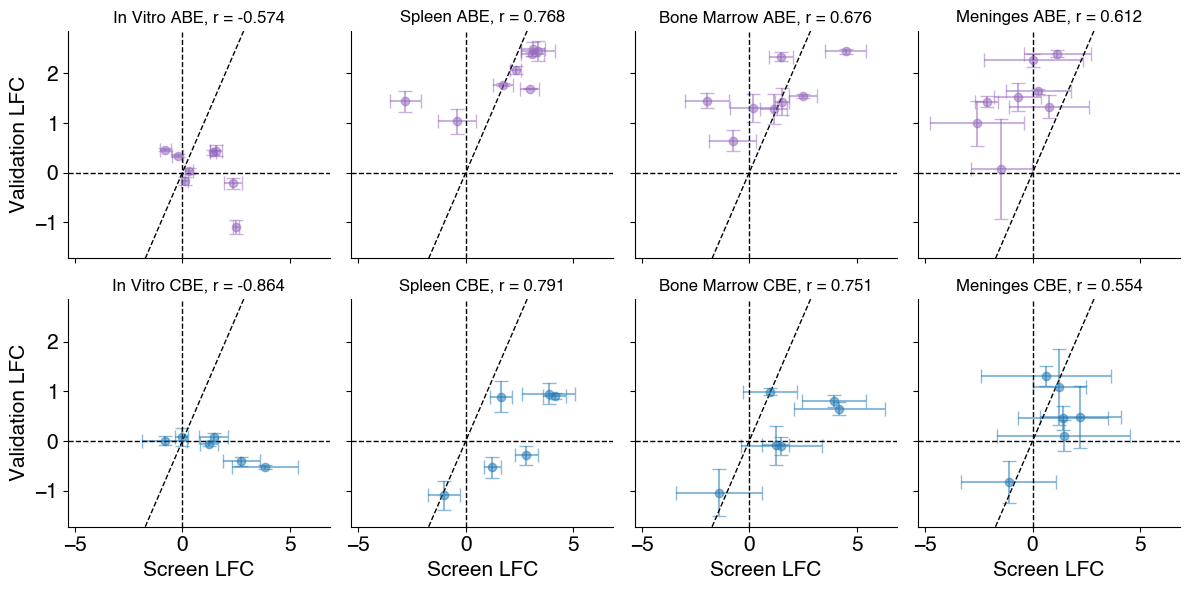

In [508]:
#m1 = pd.merge(screen_data_medians[screen_data_medians['gRNA_id']!='gRNA_2458'], data_val, on='gRNA_id')

m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')
m1_ABE = m1[m1['Editor']=='ABE']
m1_CBE = m1[m1['Editor']=='CBE']

fig, ax = plt.subplots(2,4, figsize=(12,6), sharex=True, sharey=True)


#first plot ABE in errorbar format
ax[0][0].errorbar(m1_ABE['LFC_median_d15'], m1_ABE['median_In Vitro'], xerr=m1_ABE['iv_std'], yerr=m1_ABE['std_In Vitro'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][0].errorbar(m1_CBE['LFC_median_d15'], m1_CBE['median_In Vitro'], xerr=m1_CBE['iv_std'], yerr=m1_CBE['std_In Vitro'], color='tab:blue',fmt='o', capsize=5, alpha=.5)

a1_p = np.round(scipy.stats.pearsonr(m1_ABE['LFC_median_d15'], m1_ABE['median_In Vitro']).statistic,3)
a2_p = np.round(scipy.stats.pearsonr(m1_CBE['LFC_median_d15'], m1_CBE['median_In Vitro']).statistic,3)
ax[0][0].set_title(f'In Vitro ABE, r = {a1_p}')
ax[1][0].set_title(f'In Vitro CBE, r = {a2_p}')


ax[0][1].errorbar(m1_ABE['LFC_median_spleen'], m1_ABE['median_Spleen'], xerr=m1_ABE['spleen_std'], yerr=m1_ABE['std_Spleen'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][1].errorbar(m1_CBE['LFC_median_spleen'], m1_CBE['median_Spleen'], xerr=m1_CBE['spleen_std'], yerr=m1_CBE['std_Spleen'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
a1_p = np.round(scipy.stats.pearsonr(m1_ABE['LFC_median_spleen'], m1_ABE['median_Spleen']).statistic,3)
a2_p = np.round(scipy.stats.pearsonr(m1_CBE['LFC_median_spleen'], m1_CBE['median_Spleen']).statistic,3)
ax[0][1].set_title(f'Spleen ABE, r = {a1_p}')
ax[1][1].set_title(f'Spleen CBE, r = {a2_p}')


ax[0][2].errorbar(m1_ABE['LFC_median_bonemarrow'], m1_ABE['median_Bone Marrow'], xerr=m1_ABE['bm_std'], yerr=m1_ABE['std_Bone Marrow'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][2].errorbar(m1_CBE['LFC_median_bonemarrow'], m1_CBE['median_Bone Marrow'], xerr=m1_CBE['bm_std'], yerr=m1_CBE['std_Bone Marrow'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
a1_p = np.round(scipy.stats.pearsonr(m1_ABE['LFC_median_bonemarrow'], m1_ABE['median_Bone Marrow']).statistic,3)
a2_p = np.round(scipy.stats.pearsonr(m1_CBE['LFC_median_bonemarrow'], m1_CBE['median_Bone Marrow']).statistic,3)
ax[0][2].set_title(f'Bone Marrow ABE, r = {a1_p}')
ax[1][2].set_title(f'Bone Marrow CBE, r = {a2_p}')


ax[0][3].errorbar(m1_ABE['LFC_median_meninges'], m1_ABE['median_Meninges'], xerr=m1_ABE['meninges_std'], yerr=m1_ABE['std_Meninges'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][3].errorbar(m1_CBE['LFC_median_meninges'], m1_CBE['median_Meninges'], xerr=m1_CBE['meninges_std'], yerr=m1_CBE['std_Meninges'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
a1_p = np.round(scipy.stats.pearsonr(m1_ABE['LFC_median_meninges'], m1_ABE['median_Meninges']).statistic,3)
a2_p = np.round(scipy.stats.pearsonr(m1_CBE['LFC_median_meninges'], m1_CBE['median_Meninges']).statistic,3)
ax[0][3].set_title(f'Meninges ABE, r = {a1_p}')
ax[1][3].set_title(f'Meninges CBE, r = {a2_p}')


ax[0][0].set_ylabel('Validation LFC', fontsize=15)
ax[1][0].set_ylabel('Validation LFC', fontsize=15)


for i in range(4):
    ax[1][i].set_xlabel('Screen LFC', fontsize=15)
    ax[0][i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[1][i].axvline(0, color='black', linestyle='dashed', linewidth=1)

    ax[0][i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[1][i].axhline(0, color='black', linestyle='dashed', linewidth=1)

    ax[0][i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)
    ax[1][i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)

    #ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
    ax[0][i].spines[['top', 'right']].set_visible(False)
    ax[1][i].spines[['top', 'right']].set_visible(False)

    ax[0][i].tick_params(axis='both', which='major', labelsize=15)
    ax[1][i].tick_params(axis='both', which='major', labelsize=15)

    #ax.tick_params(axis='y', which='major', labelsize=15)


#ax[0].set_xlim(-5,5)
#ax[1].set_ylim(-2,4)
fig.tight_layout()

In [510]:
import numpy as np

def weighted_pearson_corr(x, y, var_x, var_y):
    """
    Compute the weighted Pearson correlation between x and y,
    accounting for their individual measurement variances.

    Parameters:
    - x: array-like, observed values for X
    - y: array-like, observed values for Y
    - var_x: array-like, variances of x (same length as x)
    - var_y: array-like, variances of y (same length as y)

    Returns:
    - weighted Pearson correlation coefficient
    """
    x = np.asarray(x)
    y = np.asarray(y)
    var_x = np.asarray(var_x)
    var_y = np.asarray(var_y)

    # Calculate weights as inverse of total variance
    weights = 1.0 / (var_x + var_y)

    # Weighted means
    wx_mean = np.average(x, weights=weights)
    wy_mean = np.average(y, weights=weights)

    # Weighted covariance and variances
    cov_xy = np.average((x - wx_mean) * (y - wy_mean), weights=weights)
    var_x_w = np.average((x - wx_mean) ** 2, weights=weights)
    var_y_w = np.average((y - wy_mean) ** 2, weights=weights)

    # Correlation
    corr = cov_xy / np.sqrt(var_x_w * var_y_w)

    return corr


x = m1_ABE['LFC_median_meninges']
y = m1_ABE['median_Meninges']
var_x = m1_ABE['meninges_std']**2
var_y = m1_ABE['std_Meninges']**2
weighted_pearson_corr(x, y, var_x, var_y)


0.47954191036926297

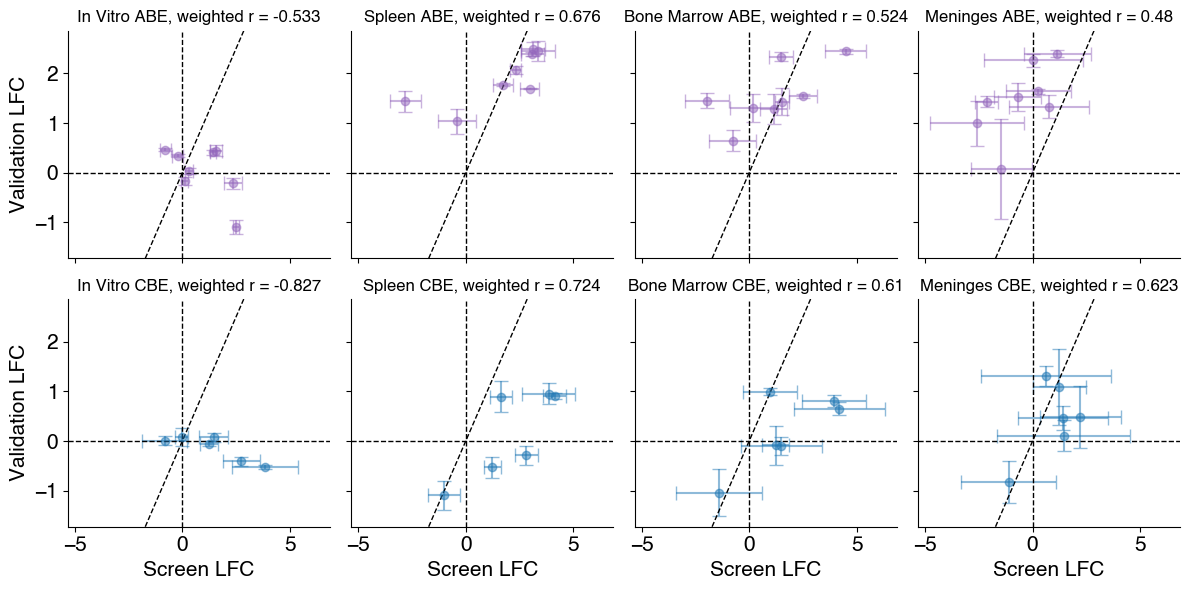

In [514]:
#m1 = pd.merge(screen_data_medians[screen_data_medians['gRNA_id']!='gRNA_2458'], data_val, on='gRNA_id')

m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')
m1_ABE = m1[m1['Editor']=='ABE']
m1_CBE = m1[m1['Editor']=='CBE']

fig, ax = plt.subplots(2,4, figsize=(12,6), sharex=True, sharey=True)


#first plot ABE in errorbar format
ax[0][0].errorbar(m1_ABE['LFC_median_d15'], m1_ABE['median_In Vitro'], xerr=m1_ABE['iv_std'], yerr=m1_ABE['std_In Vitro'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][0].errorbar(m1_CBE['LFC_median_d15'], m1_CBE['median_In Vitro'], xerr=m1_CBE['iv_std'], yerr=m1_CBE['std_In Vitro'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
x = m1_ABE['LFC_median_d15']
y = m1_ABE['median_In Vitro']
var_x = m1_ABE['iv_std']**2
var_y = m1_ABE['std_In Vitro']**2
a1_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)

x = m1_CBE['LFC_median_d15']
y = m1_CBE['median_In Vitro']
var_x = m1_CBE['iv_std']**2
var_y = m1_CBE['std_In Vitro']**2
a2_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)
ax[0][0].set_title(f'In Vitro ABE, weighted r = {a1_p}')
ax[1][0].set_title(f'In Vitro CBE, weighted r = {a2_p}')


ax[0][1].errorbar(m1_ABE['LFC_median_spleen'], m1_ABE['median_Spleen'], xerr=m1_ABE['spleen_std'], yerr=m1_ABE['std_Spleen'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][1].errorbar(m1_CBE['LFC_median_spleen'], m1_CBE['median_Spleen'], xerr=m1_CBE['spleen_std'], yerr=m1_CBE['std_Spleen'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
x = m1_ABE['LFC_median_spleen']
y = m1_ABE['median_Spleen']
var_x = m1_ABE['spleen_std']**2
var_y = m1_ABE['std_Spleen']**2
a1_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)

x = m1_CBE['LFC_median_spleen']
y = m1_CBE['median_Spleen']
var_x = m1_CBE['spleen_std']**2
var_y = m1_CBE['std_Spleen']**2
a2_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)
ax[0][1].set_title(f'Spleen ABE, weighted r = {a1_p}')
ax[1][1].set_title(f'Spleen CBE, weighted r = {a2_p}')


ax[0][2].errorbar(m1_ABE['LFC_median_bonemarrow'], m1_ABE['median_Bone Marrow'], xerr=m1_ABE['bm_std'], yerr=m1_ABE['std_Bone Marrow'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][2].errorbar(m1_CBE['LFC_median_bonemarrow'], m1_CBE['median_Bone Marrow'], xerr=m1_CBE['bm_std'], yerr=m1_CBE['std_Bone Marrow'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
x = m1_ABE['LFC_median_bonemarrow']
y = m1_ABE['median_Bone Marrow']
var_x = m1_ABE['bm_std']**2
var_y = m1_ABE['std_Bone Marrow']**2
a1_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)

x = m1_CBE['LFC_median_bonemarrow']
y = m1_CBE['median_Bone Marrow']
var_x = m1_CBE['bm_std']**2
var_y = m1_CBE['std_Bone Marrow']**2
a2_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)
ax[0][2].set_title(f'Bone Marrow ABE, weighted r = {a1_p}')
ax[1][2].set_title(f'Bone Marrow CBE, weighted r = {a2_p}')


ax[0][3].errorbar(m1_ABE['LFC_median_meninges'], m1_ABE['median_Meninges'], xerr=m1_ABE['meninges_std'], yerr=m1_ABE['std_Meninges'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1][3].errorbar(m1_CBE['LFC_median_meninges'], m1_CBE['median_Meninges'], xerr=m1_CBE['meninges_std'], yerr=m1_CBE['std_Meninges'], color='tab:blue',fmt='o', capsize=5, alpha=.5)


x = m1_ABE['LFC_median_meninges']
y = m1_ABE['median_Meninges']
var_x = m1_ABE['meninges_std']**2
var_y = m1_ABE['std_Meninges']**2
a1_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)

x = m1_CBE['LFC_median_meninges']
y = m1_CBE['median_Meninges']
var_x = m1_CBE['meninges_std']**2
var_y = m1_CBE['std_Meninges']**2
a2_p = np.round(weighted_pearson_corr(x, y, var_x, var_y), 3)

ax[0][3].set_title(f'Meninges ABE, weighted r = {a1_p}')
ax[1][3].set_title(f'Meninges CBE, weighted r = {a2_p}')


ax[0][0].set_ylabel('Validation LFC', fontsize=15)
ax[1][0].set_ylabel('Validation LFC', fontsize=15)


for i in range(4):
    ax[1][i].set_xlabel('Screen LFC', fontsize=15)
    ax[0][i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[1][i].axvline(0, color='black', linestyle='dashed', linewidth=1)

    ax[0][i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[1][i].axhline(0, color='black', linestyle='dashed', linewidth=1)

    ax[0][i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)
    ax[1][i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)

    #ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
    ax[0][i].spines[['top', 'right']].set_visible(False)
    ax[1][i].spines[['top', 'right']].set_visible(False)

    ax[0][i].tick_params(axis='both', which='major', labelsize=15)
    ax[1][i].tick_params(axis='both', which='major', labelsize=15)

    #ax.tick_params(axis='y', which='major', labelsize=15)


#ax[0].set_xlim(-5,5)
#ax[1].set_ylim(-2,4)
fig.tight_layout()

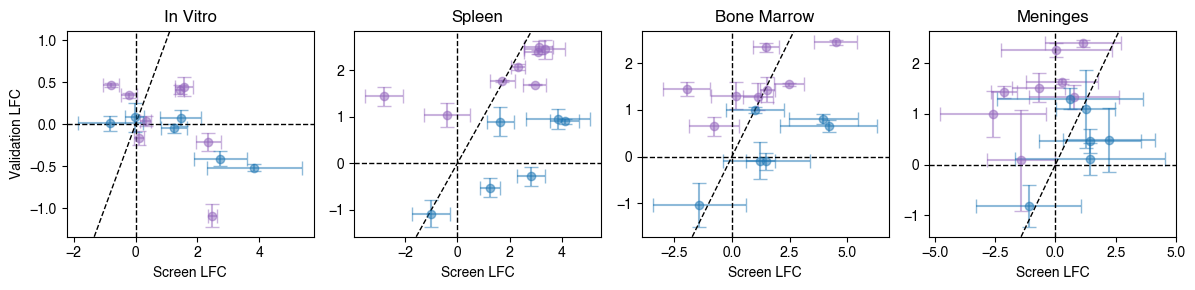

In [462]:
#m1 = pd.merge(screen_data_medians[screen_data_medians['gRNA_id']!='gRNA_2458'], data_val, on='gRNA_id')
m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')

m1_ABE = m1[m1['Editor']=='ABE']
m1_CBE = m1[m1['Editor']=='CBE']

fig, ax = plt.subplots(1,4, figsize=(12,3)) #, sharex=True, sharey=True)


#first plot ABE in errorbar format
ax[0].errorbar(m1_ABE['LFC_median_d15'], m1_ABE['median_In Vitro'], xerr=m1_ABE['iv_std'], yerr=m1_ABE['std_In Vitro'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[0].errorbar(m1_CBE['LFC_median_d15'], m1_CBE['median_In Vitro'], xerr=m1_CBE['iv_std'], yerr=m1_CBE['std_In Vitro'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[0].set_title('In Vitro')

ax[1].errorbar(m1_ABE['LFC_median_spleen'], m1_ABE['median_Spleen'], xerr=m1_ABE['spleen_std'], yerr=m1_ABE['std_Spleen'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1].errorbar(m1_CBE['LFC_median_spleen'], m1_CBE['median_Spleen'], xerr=m1_CBE['spleen_std'], yerr=m1_CBE['std_Spleen'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[1].set_title('Spleen')


ax[2].errorbar(m1_ABE['LFC_median_bonemarrow'], m1_ABE['median_Bone Marrow'], xerr=m1_ABE['bm_std'], yerr=m1_ABE['std_Bone Marrow'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[2].errorbar(m1_CBE['LFC_median_bonemarrow'], m1_CBE['median_Bone Marrow'], xerr=m1_CBE['bm_std'], yerr=m1_CBE['std_Bone Marrow'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[2].set_title('Bone Marrow')


ax[3].errorbar(m1_ABE['LFC_median_meninges'], m1_ABE['median_Meninges'], xerr=m1_ABE['meninges_std'], yerr=m1_ABE['std_Meninges'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[3].errorbar(m1_CBE['LFC_median_meninges'], m1_CBE['median_Meninges'], xerr=m1_CBE['meninges_std'], yerr=m1_CBE['std_Meninges'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[3].set_title('Meninges')

ax[0].set_ylabel('Validation LFC')


for i in range(4):
    ax[i].set_xlabel('Screen LFC')
    ax[i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)

fig.tight_layout()


In [481]:
#and now looking at every pairwise comparison

guide_list = []
editor_list = []
iv_comps = []
sp_comps = []
men_comps = []
bm_comps = []
#for i, val in screen_data_medians[(screen_data_medians['Editor']=='ABE') & (screen_data_medians['gRNA_id']!='gRNA_2458')].iterrows():
for i, val in screen_data_medians[(screen_data_medians['Editor']=='ABE')].iterrows():

    g = val['gRNA_id']
    editor_list.append(val['Editor'])
    guide_list.append(g)
    subset = screen_data[screen_data['gRNA_id']==g]
    sp1 = np.asarray(subset[sp].dropna(axis=1))
    men1 = np.asarray(subset[men].dropna(axis=1))
    bm1 = np.asarray(subset[bm].dropna(axis=1))
    iv1 = np.asarray(subset[iv].dropna(axis=1))

    validation_subset = validation_merged[(validation_merged['gRNA_id']==g) & (validation_merged['Timepoint']=='Final')]

    iv_subset = np.asarray(validation_subset[validation_subset['Tissue']=='In Vitro']['LFC'])
    i1 = []
    for k in iv_subset:
        for j in iv1[0]:
            i1.append([j, k])

    sp_subset = np.asarray(validation_subset[validation_subset['Tissue']=='Spleen']['LFC'])
    s1 = []
    for k in sp_subset:
        for j in sp1[0]:
            s1.append([j, k])
    
    bm_subset = np.asarray(validation_subset[validation_subset['Tissue']=='Bone Marrow']['LFC'])
    b1 = []
    for k in bm_subset:
        for j in bm1[0]:
            b1.append([j, k])

    m_subset = np.asarray(validation_subset[validation_subset['Tissue']=='Meninges']['LFC'])
    men2 = []
    for k in m_subset:
        for j in men1[0]:
            men2.append([j, k])

    iv_comps.append(i1)
    sp_comps.append(s1)
    bm_comps.append(b1)
    men_comps.append(men2)

In [482]:
iv_x = []
iv_y = []
for i in iv_comps:
    x = [k[0] for k in i]
    y = [k[1] for k in i]
    for j in x:
        iv_x.append(j)
    for j in y:
        iv_y.append(j)

sp_x = []
sp_y = []
for i in sp_comps:
    x = [k[0] for k in i]
    y = [k[1] for k in i]
    for j in x:
        sp_x.append(j)
    for j in y:
        sp_y.append(j)

bm_x = []
bm_y = []
for i in bm_comps:
    x = [k[0] for k in i]
    y = [k[1] for k in i]
    for j in x:
        bm_x.append(j)
    for j in y:
        bm_y.append(j)

m_x = []
m_y = []
for i in men_comps:
    x = [k[0] for k in i]
    y = [k[1] for k in i]
    for j in x:
        m_x.append(j)
    for j in y:
        m_y.append(j)

scipy.stats.pearsonr(m_x, m_y)

PearsonRResult(statistic=0.3904626732964917, pvalue=2.1628833783056884e-07)

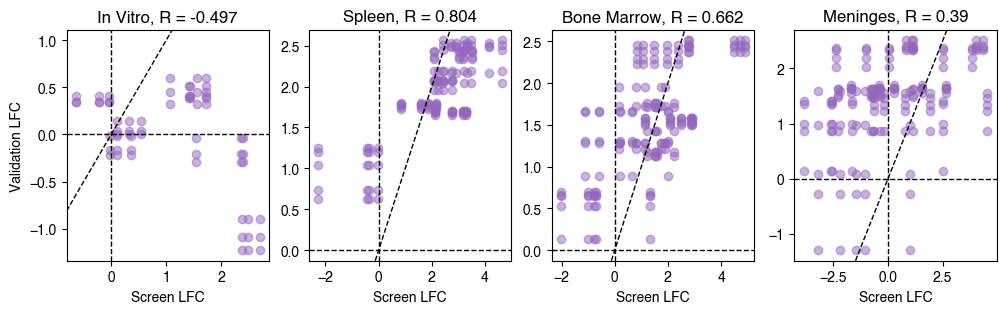

In [483]:
fig, ax = plt.subplots(1,4, figsize=(12,3)) #, sharex=True, sharey=True)

for idx, k in enumerate(editor_list):
    if k=='ABE':
        ax[0].scatter([i[0] for i in iv_comps[idx]], [i[1] for i in iv_comps[idx]], color='tab:purple', alpha=.5)
        ax[0].set_title('In Vitro')

        ax[1].scatter([i[0] for i in sp_comps[idx]], [i[1] for i in sp_comps[idx]], color='tab:purple', alpha=.5)
        ax[1].set_title('Spleen')

        ax[2].scatter([i[0] for i in bm_comps[idx]], [i[1] for i in bm_comps[idx]], color='tab:purple', alpha=.5)
        ax[2].set_title('Bone Marrow')

        ax[3].scatter([i[0] for i in men_comps[idx]], [i[1] for i in men_comps[idx]], color='tab:purple', alpha=.5)
        ax[3].set_title('Meninges')

    elif k=='CBE':
        ax[0].scatter([i[0] for i in iv_comps[idx]], [i[1] for i in iv_comps[idx]], color='tab:blue', alpha=.2)
        ax[0].set_title('In Vitro')

        ax[1].scatter([i[0] for i in sp_comps[idx]], [i[1] for i in sp_comps[idx]], color='tab:blue', alpha=.2)
        ax[1].set_title('Spleen')

        ax[2].scatter([i[0] for i in bm_comps[idx]], [i[1] for i in bm_comps[idx]], color='tab:blue', alpha=.2)
        ax[2].set_title('Bone Marrow')

        ax[3].scatter([i[0] for i in men_comps[idx]], [i[1] for i in men_comps[idx]], color='tab:blue', alpha=.2)
        ax[3].set_title('Meninges')

p_m = np.round(scipy.stats.pearsonr(m_x, m_y).statistic,3)
p_s = np.round(scipy.stats.pearsonr(sp_x, sp_y).statistic,3)
p_b = np.round(scipy.stats.pearsonr(bm_x, bm_y).statistic,3)
p_iv = np.round(scipy.stats.pearsonr(iv_x, iv_y).statistic,3)

ax[0].set_title(f'In Vitro, R = {p_iv}')
ax[1].set_title(f'Spleen, R = {p_s}')
ax[2].set_title(f'Bone Marrow, R = {p_b}')
ax[3].set_title(f'Meninges, R = {p_m}')

ax[0].set_ylabel('Validation LFC')
for i in range(4):
    ax[i].set_xlabel('Screen LFC')
    ax[i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)
        #ax[0].set_ylabel('Validation LFC')

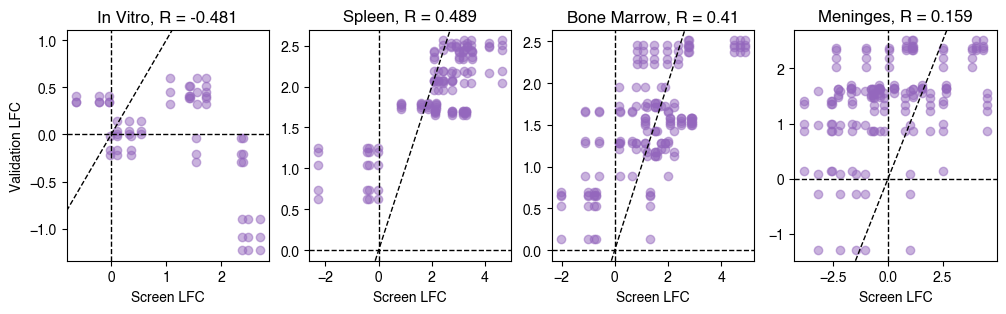

In [468]:
fig, ax = plt.subplots(1,4, figsize=(12,3)) #, sharex=True, sharey=True)

for idx, k in enumerate(editor_list):
    if k=='ABE':
        ax[0].scatter([i[0] for i in iv_comps[idx]], [i[1] for i in iv_comps[idx]], color='tab:purple', alpha=.5)
        ax[0].set_title('In Vitro')

        ax[1].scatter([i[0] for i in sp_comps[idx]], [i[1] for i in sp_comps[idx]], color='tab:purple', alpha=.5)
        ax[1].set_title('Spleen')

        ax[2].scatter([i[0] for i in bm_comps[idx]], [i[1] for i in bm_comps[idx]], color='tab:purple', alpha=.5)
        ax[2].set_title('Bone Marrow')

        ax[3].scatter([i[0] for i in men_comps[idx]], [i[1] for i in men_comps[idx]], color='tab:purple', alpha=.5)
        ax[3].set_title('Meninges')


p_m = np.round(scipy.stats.pearsonr(m_x, m_y).statistic,3)
p_s = np.round(scipy.stats.pearsonr(sp_x, sp_y).statistic,3)
p_b = np.round(scipy.stats.pearsonr(bm_x, bm_y).statistic,3)
p_iv = np.round(scipy.stats.pearsonr(iv_x, iv_y).statistic,3)

ax[0].set_title(f'In Vitro, R = {p_iv}')
ax[1].set_title(f'Spleen, R = {p_s}')
ax[2].set_title(f'Bone Marrow, R = {p_b}')
ax[3].set_title(f'Meninges, R = {p_m}')

ax[0].set_ylabel('Validation LFC')
for i in range(4):
    ax[i].set_xlabel('Screen LFC')
    ax[i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)

In [466]:
theoretical_max = 100/validation_merged[validation_merged['Timepoint']=='Initial']['Percent_population']

max_dict = dict(zip(list(validation_merged[validation_merged['Timepoint']=='Initial']['gRNA_id']), theoretical_max))
max_dict


m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')

m1['theoretical_max_FC'] = [max_dict[i] for i in m1['gRNA_id']]
m1

m1['perc_Meninges'] = 2**m1['median_Meninges']/m1['theoretical_max_FC']
m1['perc_Spleen'] = 2**m1['median_Spleen']/m1['theoretical_max_FC']
m1['perc_BM'] = 2**m1['median_Bone Marrow']/m1['theoretical_max_FC']
m1['perc_IV'] = 2**m1['median_In Vitro']/m1['theoretical_max_FC']
m1

gRNA_id  LFC_median_meninges  LFC_median_spleen  LFC_median_bonemarrow  \
0    gRNA_2458            -2.137841          -2.807117              -1.958151   
1    gRNA_2474            -2.574786           3.351583               1.134223   
2   gRNA_10342             0.039870           3.091860               1.474299   
3   gRNA_11607             0.270505           2.966590               2.492051   
4   gRNA_12164             1.141120           3.116857               4.488398   
5   gRNA_12386            -0.690195           1.730253               0.197224   
6   gRNA_12604             0.762700           2.321278               1.526947   
7   gRNA_13607            -1.444899          -0.408393              -0.763931   
8    gRNA_4802             1.439332           1.235812               1.228354   
9    gRNA_8280             0.606190           1.649905               0.982885   
10  gRNA_10131             2.225475           3.856376               4.197693   
11  gRNA_10211             1.430434           2.822866               1.493783   
12  gRNA_12312             1.250951           4.126835               3.958767   
13  gRNA_13292            -1.115926          -1.009810              -1.413459   

    LFC_median_d15 Editor  spleen_std    bm_std  meninges_std    iv_std  ...  \
0        -0.783959    ABE    0.729531  1.022355      0.548701  0.260950  ...   
1         0.113573    ABE    0.794496  0.635564      2.191732  0.156433  ...   
2         2.357751    ABE    0.530798  0.566334      2.282989  0.399397  ...   
3         1.425459    ABE    0.452392  0.648289      1.508936  0.143853  ...   
4         2.483826    ABE    0.551675  0.944218      1.561623  0.135082  ...   
5        -0.214787    ABE    0.479153  1.084358      1.104930  0.254223  ...   
6         1.566673    ABE    0.264397  0.325857      1.851302  0.282887  ...   
7         0.327580    ABE    0.873239  1.091382      1.405547  0.184141  ...   
8         1.458346    CBE    0.386059  0.619338      3.100381  0.667341  ...   
9         1.233873    CBE    0.513054  1.257511      3.018405  0.418223  ...   
10        3.847849    CBE    1.228549  2.103407      1.893438  1.548172  ...   
11       -0.028052    CBE    0.552455  1.886868      2.094616  0.301844  ...   
12        2.741191    CBE    0.553235  1.480706      1.217051  0.859523  ...   
13       -0.825419    CBE    0.729145  2.005515      2.188959  1.048823  ...   

    median_Bone Marrow  std_In Vitro  std_Spleen  std_Bone Marrow  \
0             1.452642      0.026124    0.210270         0.155175   
1             1.286151      0.082827    0.200004         0.297769   
2             2.336889      0.106215    0.037508         0.088296   
3             1.544032      0.056216    0.016218         0.032822   
4             2.446467      0.137137    0.149683         0.049413   
5             1.303331      0.031036    0.027170         0.283651   
6             1.432315      0.113362    0.072475         0.265430   
7             0.647698      0.058267    0.248942         0.205959   
8            -0.085730      0.093023    0.205488         0.388269   
9             0.992369      0.055740    0.315223         0.065335   
10            0.652927      0.045594    0.211771         0.129598   
11           -0.104337      0.171012    0.194951         0.176461   
12            0.803871      0.088351    0.059804         0.113410   
13           -1.038756      0.088071    0.289684         0.476189   

    std_Meninges  theoretical_max_FC  perc_Meninges  perc_Spleen   perc_BM  \
0       0.112610            4.694836       0.575000     0.576000  0.583000   
1       0.453880           10.649627       0.187000     0.513000  0.229000   
2       0.133458            6.849315       0.698649     0.766363  0.737610   
3       0.045571            3.496503       0.891000     0.924000  0.834000   
4       0.065842            6.993007       0.751427     0.802984  0.779464   
5       0.287000            4.926108       0.582000     0.693000  0.501000   
6       

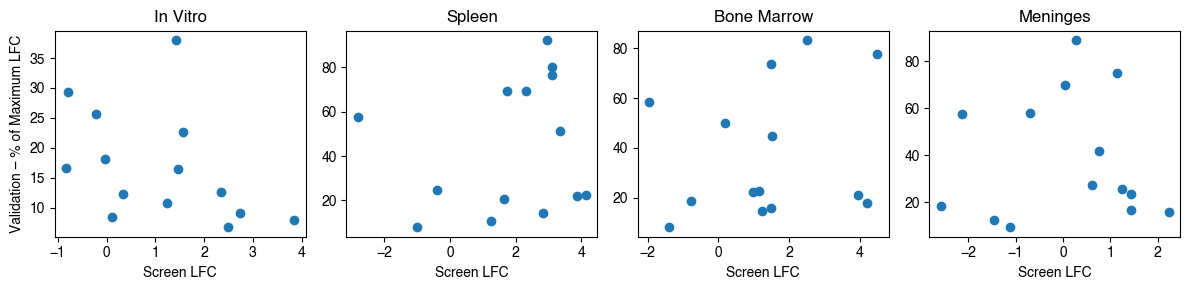

In [467]:
fig, ax = plt.subplots(1,4, figsize=(12,3)) #, sharex=True, sharey=True)



#m1 = m1[m1['gRNA_id']!='gRNA_2458']
#m1 = m1[m1['Editor']=='ABE']
ax[0].scatter(m1['LFC_median_d15'], 100*m1['perc_IV'])
ax[0].set_title('In Vitro')

ax[1].scatter(m1['LFC_median_spleen'], 100*m1['perc_Spleen'])
ax[1].set_title('Spleen')

ax[2].scatter(m1['LFC_median_bonemarrow'], 100*m1['perc_BM'])
ax[2].set_title('Bone Marrow')

ax[3].scatter(m1['LFC_median_meninges'], 100*m1['perc_Meninges'])
ax[3].set_title('Meninges')

ax[0].set_ylabel('Validation – % of Maximum LFC')


for i in range(4):
    ax[i].set_xlabel('Screen LFC')


fig.tight_layout()

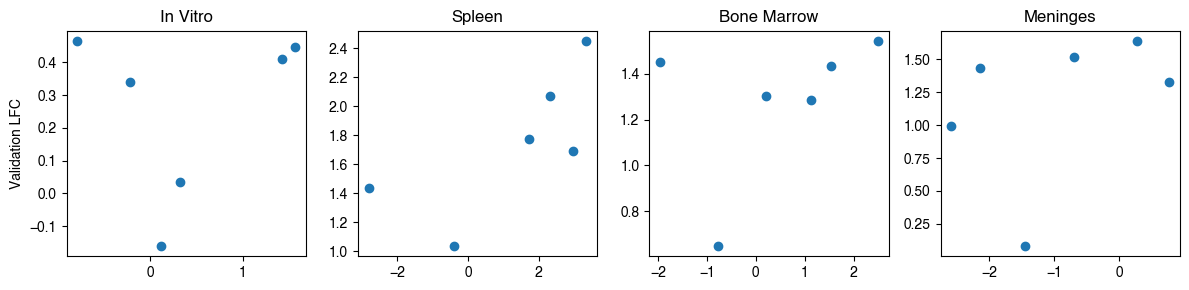

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(12,3)) #, sharex=True, sharey=True)

m2 = m1
ax[0].scatter(m2['LFC_median_d15'], m2['median_In Vitro'])
ax[0].set_title('In Vitro')

ax[1].scatter(m2['LFC_median_spleen'], m2['median_Spleen'])
ax[1].set_title('Spleen')

ax[2].scatter(m2['LFC_median_bonemarrow'], m2['median_Bone Marrow'])
ax[2].set_title('Bone Marrow')

ax[3].scatter(m2['LFC_median_meninges'], m2['median_Meninges'])
ax[3].set_title('Meninges')

ax[0].set_ylabel('Validation LFC')



fig.tight_layout()

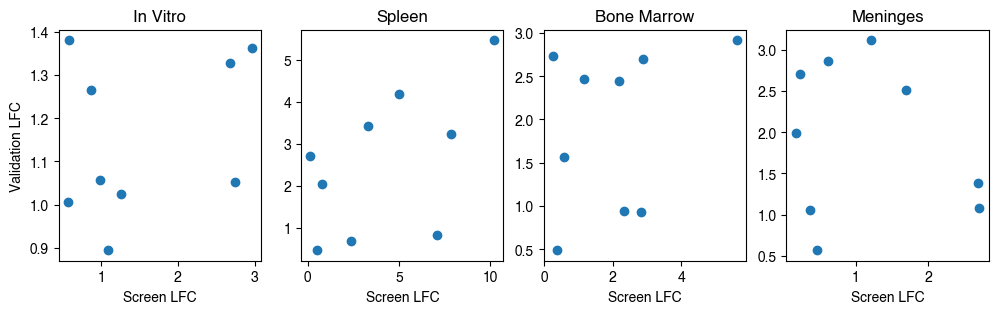

In [292]:
fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=False, sharey=False)


ax[0].scatter(2**m1['LFC_median_d15'], 2**m1['median_In Vitro'])
ax[0].set_title('In Vitro')

ax[1].scatter(2**m1['LFC_median_spleen'], 2**m1['median_Spleen'])
ax[1].set_title('Spleen')

ax[2].scatter(2**m1['LFC_median_bonemarrow'], 2**m1['median_Bone Marrow'])
ax[2].set_title('Bone Marrow')

ax[3].scatter(2**m1['LFC_median_meninges'], 2**m1['median_Meninges'])
ax[3].set_title('Meninges')

ax[0].set_ylabel('Validation LFC')


for i in range(4):
    ax[i].set_xlabel('Screen LFC')
    #ax[i].plot([-1,4],[-1,4], linestyle='dashed', color='black')
    #ax[i].plot([-4,4],[0,0], linestyle='dashed', color='black')
    #ax[i].plot([0,0],[-4,4], linestyle='dashed', color='black')

# Individual validation variant viz

In [518]:
gRNA_dict = {'ABE2':'gRNA_13607',
'ABE1':	'gRNA_12604',
'ABE8':	'gRNA_2474',
'ABE15': 'gRNA_12386',
'ABE3':	'gRNA_2458',
'ABE17':'gRNA_11607',
'CBE13': 'gRNA_10211',
'CBE14':'gRNA_4802',
'CBE16':'gRNA_13292',
'ABE6':	'gRNA_10342',
'ABE10': 'gRNA_12164',
'CBE9':	'gRNA_12312',
'CBE11':'gRNA_8280',
'CBE12':'gRNA_10131'}
#'ABE12':'gRNA_31',


ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')

ABE_guides = ['gRNA_13607','gRNA_12604','gRNA_2474','gRNA_12386','gRNA_2458','gRNA_11607','gRNA_10342','gRNA_12164']
CBE_guides = ['gRNA_10211','gRNA_4802','gRNA_13292','gRNA_12312','gRNA_8280','gRNA_10131']

In [523]:
meninges_specific = CBE_LFC[CBE_LFC['gRNA_id'].isin(CBE_guides)]

CBE_samp_dict3 = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}


meninges_specific['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in meninges_specific.iterrows()]

#get meninges
l1 = list(CBE_samp_dict3['meninges'])
melted_1 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l1, 
                     var_name='tissue', value_name='LFC')
melted_1['tissue'] = "Meninges"

#spleen
l2 = list(CBE_samp_dict3['spleen'])
melted_2 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc', 'sensor_reads','Input_median', 'Name'], value_vars=l2, 
                     var_name='tissue', value_name='LFC')
melted_2['tissue'] = 'Spleen'

#bm
l3 = list(CBE_samp_dict3['bonemarrow'])
melted_3 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l3, 
                     var_name='tissue', value_name='LFC')
melted_3['tissue'] = 'Bone Marrow'

#in vitro
l4 = list(CBE_samp_dict3['d15'])
melted_4 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc', 'sensor_reads','Input_median', 'Name'], value_vars=l4, 
                     var_name='tissue', value_name='LFC')
melted_4['tissue'] = 'In Vitro D15'


plotting_df_CBE = pd.concat((melted_1, melted_2, melted_3, melted_4))
t_ABE = plotting_df.drop_duplicates(subset='gRNA_id')[['target_base_edit_perc', 'corr_perc', 'sensor_reads', 'Name']]


####ABE
#same for ABE
meninges_specific = ABE_LFC[ABE_LFC['gRNA_id'].isin(ABE_guides)]


ABE_samp_dict3 = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],}

meninges_specific['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in meninges_specific.iterrows()]

#get meninges
l1 = list(ABE_samp_dict3['meninges'])
melted_1 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc', 'sensor_reads', 'Input_median','Name'], value_vars=l1, 
                     var_name='tissue', value_name='LFC')
melted_1['tissue'] = "Meninges"

#spleen
l2 = list(ABE_samp_dict3['spleen'])
melted_2 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l2, 
                     var_name='tissue', value_name='LFC')
melted_2['tissue'] = 'Spleen'

#bm
l3 = list(ABE_samp_dict3['bonemarrow'])
melted_3 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc','corr_perc','sensor_reads', 'Input_median','Name'], value_vars=l3, 
                     var_name='tissue', value_name='LFC')
melted_3['tissue'] = 'Bone Marrow'

#in vitro
l4 = list(ABE_samp_dict3['d15'])
melted_4 = meninges_specific.melt(id_vars=['gRNA_id', 'Gene', 'HGVSp_m', 'target_base_edit_perc', 'corr_perc','sensor_reads','Input_median', 'Name'], value_vars=l4, 
                     var_name='tissue', value_name='LFC')
melted_4['tissue'] = 'In Vitro D15'


plotting_df_ABE = pd.concat((melted_1, melted_2, melted_3, melted_4))
t_CBE = plotting_df.drop_duplicates(subset='gRNA_id')[['target_base_edit_perc', 'corr_perc','sensor_reads', 'Name']]

In [526]:
#and loading in the validation
validation = pd.read_excel('B-ALL validation.xlsx')

#exclude gRNA 4
validation = validation[validation['sgRNA']!='ABE4']

holder = []
for i in np.unique(validation['sgRNA']):
    initial_perc = validation[(validation['sgRNA']==i) & (validation['Timepoint']=='Initial')]['Percent_population'].values[0]
    subset = validation[validation['sgRNA']==i]
    subset['FoldChange'] = np.asarray(subset['Percent_population'])/initial_perc
    subset['LFC'] = np.log2(np.asarray(subset['Percent_population'])/initial_perc)
    holder.append(subset)

validation_lfc = pd.concat(holder)


gRNA_dict = {'ABE2':'gRNA_13607',
'ABE1':	'gRNA_12604',
'ABE8':	'gRNA_2474',
'ABE15': 'gRNA_12386',
'ABE3':	'gRNA_2458',
'ABE17':'gRNA_11607',
'CBE13': 'gRNA_10211',
'CBE14':'gRNA_4802',
'CBE16':'gRNA_13292',
'ABE6':	'gRNA_10342',
'ABE10': 'gRNA_12164',
'CBE9':	'gRNA_12312',
'CBE11':'gRNA_8280',
'CBE12':'gRNA_10131'}
#'ABE12':'gRNA_31',


validation_lfc['gRNA_id'] = [gRNA_dict[i] for i in validation_lfc['sgRNA']]

ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
ABE_info = ABE_LFC[['gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'classification']]
ABE_info['Editor']='ABE'

CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
CBE_info = CBE_LFC[['gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'classification']]
CBE_info['Editor']='CBE'

comb_info = pd.concat((ABE_info, CBE_info))

validation_merged = pd.merge(validation_lfc, comb_info, on='gRNA_id')

validation_merged['Name'] = [f'{val["Gene"]}\n{val["HGVSp_m"]}\n({val["gRNA_id"]})' for i, val in validation_merged.iterrows()]
validation_merged

sgRNA  Percent_population Timepoint       Tissue  FoldChange       LFC  \
0    ABE1                16.6   Initial     In Vitro    1.000000  0.000000   
1    ABE1                22.6     Final     In Vitro    1.361446  0.445140   
2    ABE1                25.2     Final     In Vitro    1.518072  0.602240   
3    ABE1                20.8     Final     In Vitro    1.253012  0.325400   
4    ABE1                69.6     Final       Spleen    4.192771  2.067904   
..    ...                 ...       ...          ...         ...       ...   
246  CBE9                18.8     Final  Bone Marrow    1.553719  0.635726   
247  CBE9                29.2     Final     Meninges    2.413223  1.270961   
248  CBE9                22.7     Final     Meninges    1.876033  0.907685   
249  CBE9                36.0     Final     Meninges    2.975207  1.572990   
250  CBE9                 8.9     Final     Meninges    0.735537 -0.443130   

        gRNA_id   Gene HGVSp_m HGVSp_h   classification Editor  \
0    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
1    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
2    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
3    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
4    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
..          ...    ...     ...     ...              ...    ...   
246  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
247  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
248  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
249  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
250  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   

                           Name  
0    Trp53\nR277G\n(gRNA_12604)  
1    Trp53\nR277G\n(gRNA_12604)  
2    Trp53\nR277G\n(gRNA_12604)  
3    Trp53\nR277G\n(gRNA_12604)  
4    Trp53\nR277G\n(gRNA_12604)  
..                          ...  
246    Tek\nR167W\n(gRNA_12312)  
247    Tek\nR167W\n(gRNA_12312)  
248    Tek\nR167W\n(gRNA_12312)  
249    Tek\nR167W\n(gRNA_12312)  
250    Tek\nR167W\n(gRNA_12312)  

[251 rows x 13 columns]

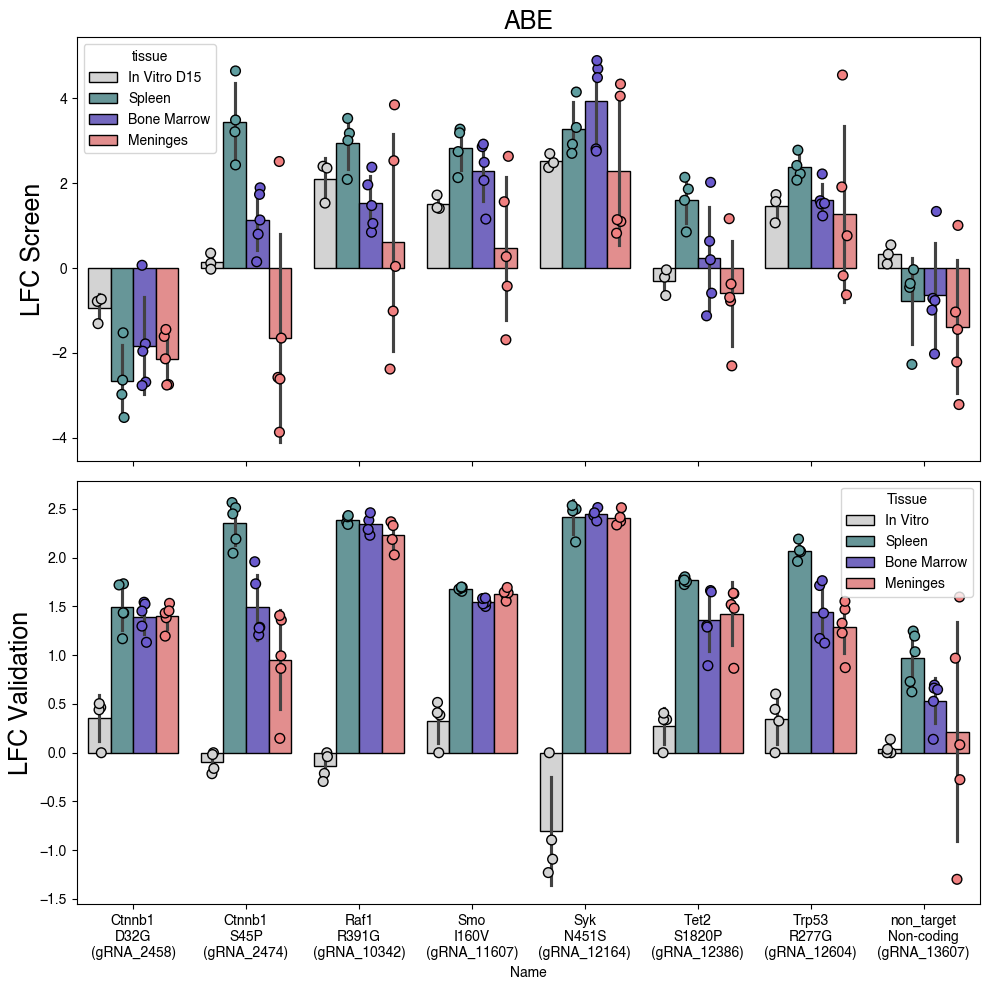

In [556]:
#and plotting
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro D15', 'Spleen', 'Bone Marrow', 'Meninges']
sns.barplot(data=plotting_df_ABE, x='Name', y='LFC', hue='tissue', hue_order=ho, palette=palette, edgecolor='black', ax=ax[0], errorbar='sd')
sns.stripplot(data=plotting_df_ABE, x='Name', y='LFC', hue='tissue', hue_order=ho, palette=palette, edgecolor='black', ax=ax[0], legend=False,linewidth=1, dodge=True, s=7)

ho = ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']

sns.barplot(data=validation_merged[validation_merged['Editor']=='ABE'], x='Name', y='LFC', hue='Tissue', ax=ax[1], edgecolor='black', palette=palette, hue_order = ho, errorbar='sd')
sns.stripplot(data=validation_merged[validation_merged['Editor']=='ABE'], x='Name', y='LFC', hue='Tissue', ax=ax[1], edgecolor='black', palette=palette, hue_order = ho,legend=False, linewidth=1, dodge=True, s=7)

ax[0].set_title('ABE', fontsize=18)
ax[0].set_ylabel('LFC Screen', fontsize=18)
ax[1].set_ylabel('LFC Validation', fontsize=18)
fig.tight_layout()



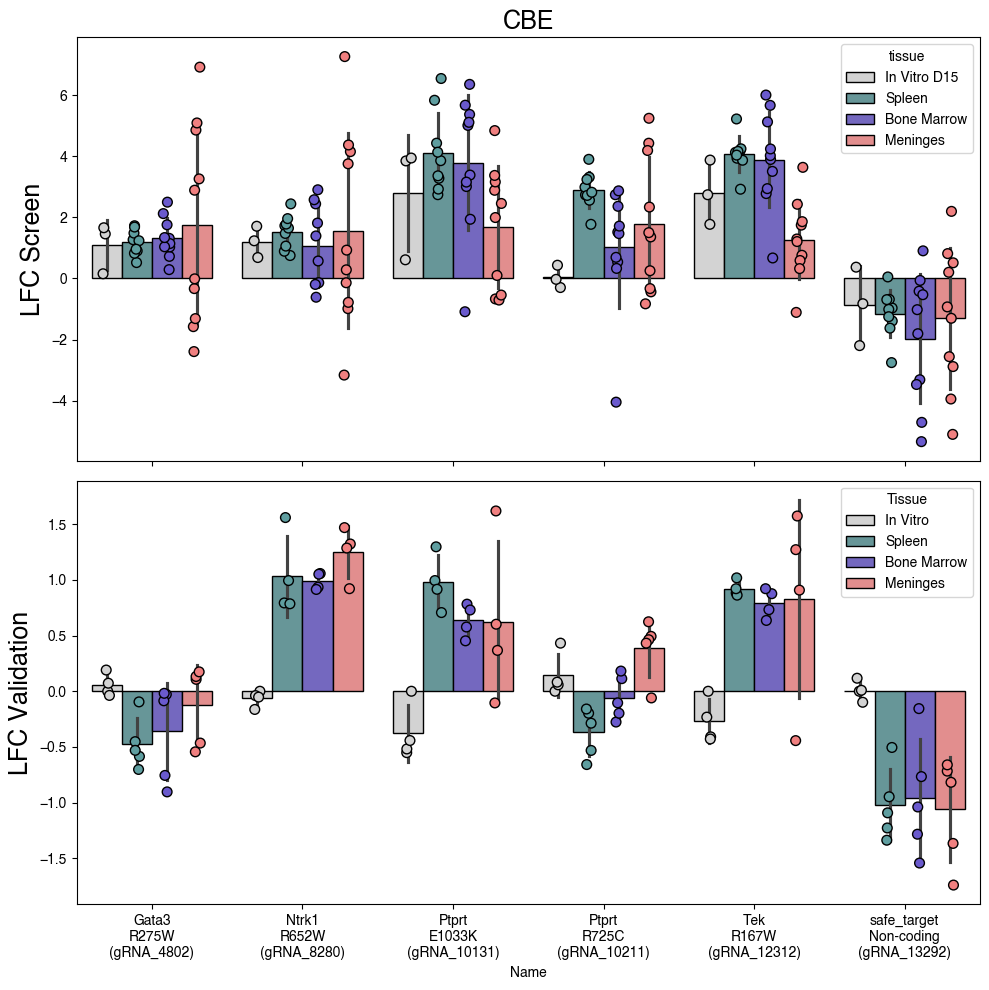

In [554]:
#and plotting
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

ho = ['In Vitro D15', 'Spleen', 'Bone Marrow', 'Meninges']
sns.barplot(data=plotting_df_CBE, x='Name', y='LFC', hue='tissue', hue_order=ho, palette=palette, edgecolor='black', ax=ax[0], errorbar='sd')
sns.stripplot(data=plotting_df_CBE, x='Name', y='LFC', hue='tissue', hue_order=ho, palette=palette, edgecolor='black', ax=ax[0], legend=False,linewidth=1, dodge=True, s=7)

ho = ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']

sns.barplot(data=validation_merged[validation_merged['Editor']=='CBE'], x='Name', y='LFC', hue='Tissue', ax=ax[1], edgecolor='black', palette=palette, hue_order = ho, errorbar='sd')
sns.stripplot(data=validation_merged[validation_merged['Editor']=='CBE'], x='Name', y='LFC', hue='Tissue', ax=ax[1], edgecolor='black', palette=palette, hue_order = ho,legend=False, linewidth=1, dodge=True, s=7)

ax[0].set_title('CBE', fontsize=18)

ax[0].set_ylabel('LFC Screen', fontsize=18)
ax[1].set_ylabel('LFC Validation', fontsize=18)

fig.tight_layout()

In [549]:
validation_merged

sgRNA  Percent_population Timepoint       Tissue  FoldChange       LFC  \
0    ABE1                16.6   Initial     In Vitro    1.000000  0.000000   
1    ABE1                22.6     Final     In Vitro    1.361446  0.445140   
2    ABE1                25.2     Final     In Vitro    1.518072  0.602240   
3    ABE1                20.8     Final     In Vitro    1.253012  0.325400   
4    ABE1                69.6     Final       Spleen    4.192771  2.067904   
..    ...                 ...       ...          ...         ...       ...   
246  CBE9                18.8     Final  Bone Marrow    1.553719  0.635726   
247  CBE9                29.2     Final     Meninges    2.413223  1.270961   
248  CBE9                22.7     Final     Meninges    1.876033  0.907685   
249  CBE9                36.0     Final     Meninges    2.975207  1.572990   
250  CBE9                 8.9     Final     Meninges    0.735537 -0.443130   

        gRNA_id   Gene HGVSp_m HGVSp_h   classification Editor  \
0    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
1    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
2    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
3    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
4    gRNA_12604  Trp53   R277G   R280G  targeting guide    ABE   
..          ...    ...     ...     ...              ...    ...   
246  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
247  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
248  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
249  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   
250  gRNA_12312    Tek   R167W   R167W  targeting guide    CBE   

                           Name  
0    Trp53\nR277G\n(gRNA_12604)  
1    Trp53\nR277G\n(gRNA_12604)  
2    Trp53\nR277G\n(gRNA_12604)  
3    Trp53\nR277G\n(gRNA_12604)  
4    Trp53\nR277G\n(gRNA_12604)  
..                          ...  
246    Tek\nR167W\n(gRNA_12312)  
247    Tek\nR167W\n(gRNA_12312)  
248    Tek\nR167W\n(gRNA_12312)  
249    Tek\nR167W\n(gRNA_12312)  
250    Tek\nR167W\n(gRNA_12312)  

[251 rows x 13 columns]

# Off-target analysis

In [138]:
OT_holder = []
for i in range(1,16):
    aa1 = pd.read_csv(f'MBESv2_OT_CasOFF/batch{i}.txt', sep='\t')
    print(i)
    mismatch_num = [0,1,2,3,4]

    guides = np.unique(aa1['crRNA'])

    num_g = len(guides)

    OT_df = pd.DataFrame(dict(zip(['gRNA_sequence', '0', '1', '2', '3', '4'], [guides, np.zeros(num_g), np.zeros(num_g), np.zeros(num_g), np.zeros(num_g), np.zeros(num_g)])))

    for mismatch in mismatch_num:
        subset = aa1[aa1['Mismatches']==mismatch]

        u, c = np.unique(subset['crRNA'], return_counts=True)
        ot_dict = dict(zip(u,c))

        for guide in u:
            OT_df.loc[OT_df['gRNA_sequence']==guide, f'{mismatch}']=ot_dict[guide]

    OT_holder.append(OT_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [141]:
OT_combined = pd.concat(OT_holder).reset_index(drop=True)

In [148]:
OT_combined

gRNA_sequence    0    1     2      3       4
0      AAAACGATTGTCATCCCAANG  2.0  1.0   6.0  111.0  1000.0
1      AAAACGTGGGTGCGCTACGNG  1.0  0.0   0.0    7.0   166.0
2      AAAATTCCTCTCTGCATCANG  1.0  1.0  21.0  254.0  1000.0
3      AAACCCCAAGATACATCTGNG  1.0  0.0  12.0  188.0  1000.0
4      AAACGGTAAGCTTCAATGANG  1.0  0.0   2.0   71.0  1000.0
...                      ...  ...  ...   ...    ...     ...
14327  TTTCGGACATATTCATCCANG  1.0  0.0   4.0   84.0  1000.0
14328  TTTCGTGGTGAGGTAAGTTNG  1.0  0.0   0.0   62.0  1000.0
14329  TTTCTGAGATATTCATTAGNG  1.0  0.0  24.0  455.0  1000.0
14330  TTTCTTCATCTAGCCCTTTNG  1.0  1.0  18.0  308.0  1000.0
14331  TTTCTTCTATAGATTGATGNG  1.0  0.0  19.0  394.0  1000.0

[14332 rows x 6 columns]

In [176]:
lib = pd.read_csv('MBESv2_CORRECTED.csv')


crRNA = [f'{i[1:]}NG' for i in lib['Protospacer']]
lib['gRNA_sequence'] = crRNA
l1 = lib[['gRNA_id', 'gRNA_sequence', 'classification', 'Pool', 'Editor']]

m1 = pd.merge(OT_combined, l1, on='gRNA_sequence')

CBE_OT = m1[(m1['Pool']=='F2-R2') & (m1['classification']=='targeting guide')]
ABE_OT = m1[(m1['Pool']=='F1-R1') & (m1['classification']=='targeting guide')]

In [190]:
bin_names = ['0','1-9','10-99','100+']
bins = [[0,0],[1,9],[10,99],[100,1e10]]

mismatch_num = [0,1,2,3,4]
count_holder = []
for mismatch in mismatch_num:

    u, c = np.unique(CBE_OT[f'{mismatch}'], return_counts=True)

    if mismatch==0:
        u = u-1
        #account for fact that 1 target when mismatch = 0 = true target

    df_ot = pd.DataFrame(dict(zip(['num_targets', 'count'], [u,c])))
    
    count = []
    for k in bins:
        low = k[0]
        high = k[1]

        subset = df_ot[(df_ot['num_targets']>=low) & (df_ot['num_targets']<=high)]
        count.append(sum(subset['count']))

    count_holder.append(count)

df_plot = pd.DataFrame(dict(zip(['No. Off-Targets', '0 Mismatches', '1 Mismatches', '2 Mismatches', '3 Mismatches', '4 Mismatches'], [bin_names] + count_holder)))


#------and then for ABE-------
count_holder = []
for mismatch in mismatch_num:

    u, c = np.unique(ABE_OT[f'{mismatch}'], return_counts=True)

    if mismatch==0:
        u = u-1
        #account for fact that 1 target when mismatch = 0 = true target

    df_ot = pd.DataFrame(dict(zip(['num_targets', 'count'], [u,c])))
    
    count = []
    for k in bins:
        low = k[0]
        high = k[1]

        subset = df_ot[(df_ot['num_targets']>=low) & (df_ot['num_targets']<=high)]
        count.append(sum(subset['count']))

    count_holder.append(count)

df_plot_ABE = pd.DataFrame(dict(zip(['No. Off-Targets', '0 Mismatches', '1 Mismatches', '2 Mismatches', '3 Mismatches', '4 Mismatches'], [bin_names] + count_holder)))


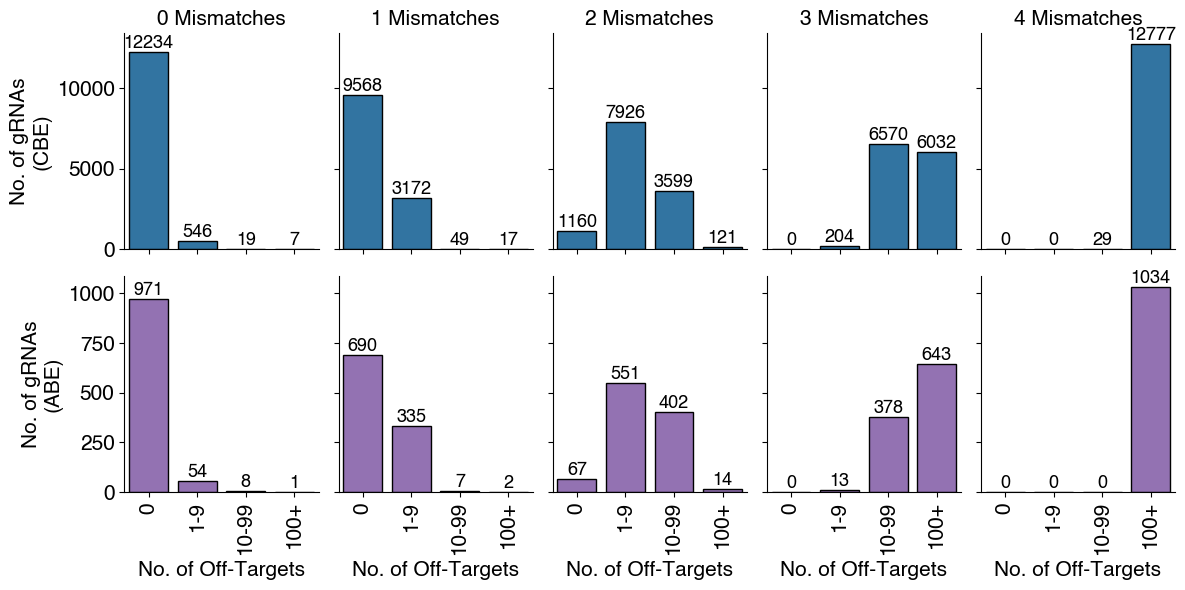

In [210]:
fig, ax = plt.subplots(2,5, figsize=(12,6), sharex=True, sharey='row')

for i in range(5):
    sns.barplot(data=df_plot, x='No. Off-Targets', y=f'{i} Mismatches', ax=ax[0][i], color='tab:blue', edgecolor='black', linewidth=1)
    ax[0][i].spines[['right', 'top']].set_visible(False)
    ax[0][i].tick_params(axis='both', which='major', labelsize=15)
    #ax[0][i].set_xticklabels(ax[0][i].get_xticklabels(), rotation=90)
    ax[0][i].set_title(f'{i} Mismatches', fontsize=15)
    ax[0][i].set_xlabel('No. of Off-Targets', fontsize=15)
    ax[0][i].bar_label(ax[0][i].containers[0], fontsize=13)

for i in range(5):
    sns.barplot(data=df_plot_ABE, x='No. Off-Targets', y=f'{i} Mismatches', ax=ax[1][i], color='tab:purple', edgecolor='black', linewidth=1)
    ax[1][i].spines[['right', 'top']].set_visible(False)
    ax[1][i].tick_params(axis='both', which='major', labelsize=15)
    ax[1][i].set_xticklabels(ax[1][i].get_xticklabels(), rotation=90)
    #ax[1][i].set_title(f'{i} Mismatches', fontsize=15)
    ax[1][i].set_xlabel('No. of Off-Targets', fontsize=15)
    ax[1][i].bar_label(ax[1][i].containers[0], fontsize=13) # only 1 container needed unless using `hue`


ax[0][0].set_ylabel('No. of gRNAs\n(CBE)', fontsize=15)
ax[1][0].set_ylabel('No. of gRNAs\n(ABE)', fontsize=15)

fig.tight_layout()

# Position of mismatches in OT sequences

In [214]:
s = "AbCd"
result = [i for i, a in enumerate(s) if a.islower()]
result

[1, 3]

In [235]:
i=1
aa1 = pd.read_csv(f'MBESv2_OT_CasOFF/batch{i}.txt', sep='\t')
mismatch = 3
subset = aa1[aa1['Mismatches']==mismatch]

In [242]:
OT_sites = subset['DNA']


h = []
for site in OT_sites:

    result = list(np.asarray([i for i, a in enumerate(site) if a.islower()])+2)
    h+=result

In [241]:
h[1]

[]

In [244]:
h = [[],[],[],[]]
for i in range(1,16):
    aa1 = pd.read_csv(f'MBESv2_OT_CasOFF/batch{i}.txt', sep='\t')
    mismatch_num = [1,2,3,4]

    guides = np.unique(aa1['crRNA'])
    print(i)
    num_g = len(guides)

    for mismatch in mismatch_num:
        subset = aa1[aa1['Mismatches']==mismatch]

        OT_sites = subset['DNA']

        for site in OT_sites:

            result = list(np.asarray([i for i, a in enumerate(site) if a.islower()])+2)
            h[mismatch-1]+=result

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


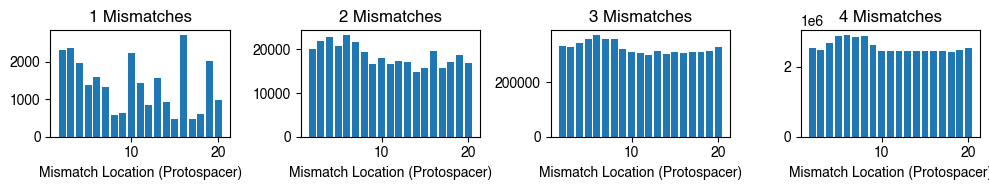

In [251]:
fig, ax = plt.subplots(1,4,figsize=(10,2))

u,c = np.unique(h[0], return_counts=True)
ax[0].bar(u,c)

u,c = np.unique(h[1], return_counts=True)
ax[1].bar(u,c)

u,c = np.unique(h[2], return_counts=True)
ax[2].bar(u,c)

u,c = np.unique(h[3], return_counts=True)
ax[3].bar(u,c)

for i in range(4):
    ax[i].set_title(f'{i+1} Mismatches')
    ax[i].set_xlabel('Mismatch Location (Protospacer)')

fig.tight_layout()

In [133]:
OT_holder = []
for i in range(1,16):
    aa1 = pd.read_csv(f'MBESv2_OT_CasOFF/batch{i}.txt', sep='\t')
    print(i)
    mismatch_num = [0,1,2,3,4]

    guides = np.unique(aa1['crRNA'])

    num_g = len(guides)

    OT_df = pd.DataFrame(dict(zip(['gRNA_sequence', '0', '1', '2', '3', '4'], [guides, np.zeros(num_g), np.zeros(num_g), np.zeros(num_g), np.zeros(num_g), np.zeros(num_g)])))

    for mismatch in mismatch_num:
        subset = aa1[aa1['Mismatches']==mismatch]

        u, c = np.unique(subset['crRNA'], return_counts=True)
        ot_dict = dict(zip(u,c))

        for guide in u:
            OT_df.loc[OT_df['gRNA_sequence']==guide, f'{mismatch}']=ot_dict[guide]

    OT_holder.append(OT_df)

gRNA_id mutation_idx gene_name_h           gene_id_h            tx_id_h  \
305  gRNA_306          245         APC  ENSG00000134982.12  ENST00000257430.4   

    chr_h  exon_num_h strand_h match      start_h  ...  \
305  chr5        15.0        +  True  112154789.0  ...   

     contains_polyT_terminator contains_RE_site num_potential_vars  \
305                      False            False                1.0   

      classification Genome_version       Hamming_BC   Pool  \
305  targeting guide         GrCm39  AACTACGAAAGCTGC  F2-R2   

                                            gRNA_oligo gene_name_m_corrected  \
305  GTGTAACCCGTAGGGCACCTAGCGTACACGTCTCACACCGTGTCTT...                   Apc   

     legacy  
305   False  

[1 rows x 58 columns]

In [106]:
ot = pd.read_csv('/Users/samgould/Desktop/OT_MBESv2.txt', sep='\t')



In [108]:
ot

#Bulge type                  crRNA                    DNA Chromosome  \
0                 X  TCTAAGGTGAAAAGCTCCGNG  gCTAAaGTcAAgAGCTCCGGG       chr8   
1                 X  TCTAAGGTGAAAAGCTCCGNG  TCaAAGGTaAAAAcCTCCaAG       chr8   
2                 X  TCTAAGGTGAAAAGCTCCGNG  TCaAAGGTaAAAAcCTCCaAG       chr8   
3                 X  TCTAAGGTGAAAAGCTCCGNG  TtTcAGGaGAAAAGCTCtGTG       chr8   
4                 X  TCTAAGGTGAAAAGCTCCGNG  gCTgAGcTGAAAAGCTCCcAG       chr8   
...             ...                    ...                    ...        ...   
1074676           X  TAAAGGTTCAGCGAGAACTNG  cAcAGGaTCAGtGAGAACTTG       chr3   
1074677           X  TAAAGGTTCAGCGAGAACTNG  aAAAGaTTaAGCaAGAACTGG       chr3   
1074678           X  TAAAGGTTCAGCGAGAACTNG  TtAAaGTTCAGCGAtAgCTGG       chr3   
1074679           X  TAAAGGTTCAGCGAGAACTNG  TcAAGGTTCAGtGAGAAaTTG       chr3   
1074680           X  TAAAGGTTCAGCGAGAACTNG  TAAAaGTTCAGaGAGAACTGG       chr3   

          Position Direction  Mismatches  Bulge Size  
0          4620609         +           4           0  
1          5140909         -           4           0  
2          7043998         -           4           0  
3         10017846         +           4           0  
4         11953963         -           4           0  
...            ...       ...         ...         ...  
1074676    8757508         +           4           0  
1074677   10752194         -           4           0  
1074678   10994500         +           4           0  
1074679   40068864         -           3           0  
1074680  148841912         +           2           0  

[1074681 rows x 8 columns]

In [111]:
uni_g = np.unique(ot['crRNA'])

uni_g_new = [f'G{i[:-2]}' for i in uni_g]

In [ ]:
uni_g_new 

In [113]:
lib[lib['Protospacer']==uni_g_new[1]]

gRNA_id mutation_idx gene_name_h          gene_id_h            tx_id_h  \
204  gRNA_205          160     ALOX12B  ENSG00000179477.5  ENST00000319144.4   

     chr_h  exon_num_h strand_h match    start_h  ...  \
204  chr17        15.0        -  True  7980435.0  ...   

     contains_polyT_terminator contains_RE_site num_potential_vars  \
204                      False            False                1.0   

      classification Genome_version       Hamming_BC   Pool  \
204  targeting guide         GrCm39  TTAGTCGCACGTGTG  F2-R2   

                                            gRNA_oligo gene_name_m_corrected  \
204  GTGTAACCCGTAGGGCACCTAGCGTACACGTCTCACACCGAAAACG...               Alox12b   

     legacy  
204   False  

[1 rows x 58 columns]

In [101]:
pool1 = lib[lib['Pool']=='F1-R1']
pool1

gRNA_id mutation_idx gene_name_h           gene_id_h  \
0          gRNA_1            0        ABL1  ENSG00000097007.13   
1          gRNA_2            0        ABL1  ENSG00000097007.13   
2          gRNA_3            0        ABL1  ENSG00000097007.13   
66        gRNA_67           59        AGO2   ENSG00000123908.7   
83        gRNA_84           68        AKT1  ENSG00000142208.11   
...           ...          ...         ...                 ...   
13603  gRNA_13604         nt_6         NaN                 NaN   
13604  gRNA_13605         nt_7         NaN                 NaN   
13605  gRNA_13606         nt_8         NaN                 NaN   
13606  gRNA_13607         nt_9         NaN                 NaN   
13607  gRNA_13608        nt_10         NaN                 NaN   

                 tx_id_h  chr_h  exon_num_h strand_h match      start_h  ...  \
0      ENST00000318560.5   chr9        11.0        +  True  133730186.0  ...   
1      ENST00000318560.5   chr9        11.0        +  True  133730186.0  ...   
2      ENST00000318560.5   chr9        11.0        +  True  133730186.0  ...   
66     ENST00000220592.5   chr8        19.0        -  True  141568614.0  ...   
83     ENST00000349310.3  chr14        13.0        -  True  105239419.0  ...   
...                  ...    ...         ...      ...   ...          ...  ...   
13603                NaN    NaN         NaN      NaN   NaN          NaN  ...   
13604                NaN    NaN         NaN      NaN   NaN          NaN  ...   
13605                NaN    NaN         NaN      NaN   NaN          NaN  ...   
13606                NaN    NaN         NaN      NaN   NaN          NaN  ...   
13607                NaN    NaN         NaN      NaN   NaN          NaN  ...   

       contains_polyT_terminator contains_RE_site num_potential_vars  \
0                          False            False                1.0   
1                          False            False                1.0   
2                          False            False                1.0   
66                         False            False                1.0   
83                         False            False                1.0   
...                          ...              ...                ...   
13603                      False            False                NaN   
13604                      False            False                NaN   
13605                      False            False                NaN   
13606                      False            False                NaN   
13607                      False            False                NaN   

              classification Genome_version       Hamming_BC   Pool  \
0            targeting guide         GrCm39  CACATACGCACTACG  F1-R1   
1            targeting guide         GrCm39  CCTATACCCGAATCT  F1-R1   
2            targeting guide         GrCm39  TATACAATTCGCAGC  F1-R1   
66           targeting guide         GrCm39  GAAGATCGAGGTTAA  F1-R1   
83           targeting guide         GrCm39  TGTACTGCGGCTATG  F1-R1   
...                      ...            ...              ...    ...   
13603  non-targeting control            NaN  CGGTCAACAGCATCT  F1-R1   
13604  non-targeting control            NaN  GGTCGAGCTTGCGAA  F1-R1   
13605  non-targeting control            NaN  CATCGCAAGTTCCGA  F1-R1   
13606  non-targeting control            NaN  TATGTCCTTGTTAGT  F1-R1   
13607  non-targeting control            NaN  AGATGTGCAACTTAA  F1-R1   

                                              gRNA_oligo  \
0      AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGTCTAAG...   
1      AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGTTCTAA...   
2      AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGTTTCTA...   
66     AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGGCAATG...   
83     AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGGGAGGA...   
...                                                  ...   
13603  AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGGATATT...   
13604  AGGCACTTGCTCGTACGACGAGCGTACACGTCTCACACCGGCTTAG...  